# 📌 Intro.
- 그동안 배운 딥러닝개념 및 실습의 내용을 활용해 총 3개의 프로젝트를 진행합니다.
    - Boston 주택 가격 예측 모델 : 주택 가격을 예측하는 회귀(Regression)모델 by 딥러닝
    - Reuters 딥러닝 모델 : Reuters의 뉴스기사/금융정보 데이터를 분류하는 모델
    - CIFAR10 딥러닝 모델 : 다양한 동물(10개클래스) 데이터를 분류하는 모델

---

- 이중 두번째 프로젝트인 Reuters 데이터 셋으로 각 데이터의 정보 종류를 분류하는 모델을 생성합니다.

In [1]:
# GPU 세팅
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 메모리 사용 제한을 위한 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # 특정 GPU만 사용하도록 설정
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
        # 런타임 오류 발생 시 예외 처리가 필요함
        print(e)
        
import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore")

Num GPUs Available:  1


## 데이터 EDA

- Reuters 데이터셋이 어떤 데이터인지 간단하게 확인해 보겠습니다.
- Reuters 데이터셋은 케라스 내장함수로 제공하는 데이터셋으로 load_data를 하면 기본적으로 모델에 사용하기 위해 토큰화 및 정수변환이 완료된 벡터 형태로 가공해 데이터를 반환합니다.
- 즉, 실제는 텍스트로된 데이터지만 어떤 데이터인지 확인할 수 있는 방법이 없습니다.
- 이 데이터를 다시 텍스트로 변환해서 간단한 EDA를 해보도록 하겠습니다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

print('훈련용 뉴스 기사 : {}'.format(len(X_train)))
print('테스트용 뉴스 기사 : {}'.format(len(X_test)))
num_classes = len(set(y_train))
print('카테고리 : {}'.format(num_classes))

훈련용 뉴스 기사 : 8982
테스트용 뉴스 기사 : 2246
카테고리 : 46


In [3]:
print('첫번째 훈련용 뉴스 기사 :',X_train[0])
print('첫번째 훈련용 뉴스 기사의 레이블 :',y_train[0])

첫번째 훈련용 뉴스 기사 : [1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
첫번째 훈련용 뉴스 기사의 레이블 : 3


뉴스 기사의 최대 길이 :2376
뉴스 기사의 평균 길이 :145.5398574927633


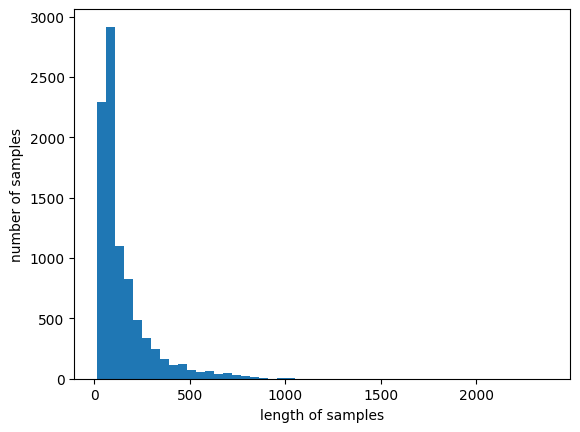

In [4]:
print('뉴스 기사의 최대 길이 :{}'.format(max(len(sample) for sample in X_train)))
print('뉴스 기사의 평균 길이 :{}'.format(sum(map(len, X_train))/len(X_train)))

plt.hist([len(sample) for sample in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 대체적으로 대부분의 뉴스가 100~200 사이의 길이를 가집니다. 
- 뉴스 길이자체가 그리 길지 않은 문장으로 구성되어 있음을 알 수 있습니다.
- 각 뉴스의 레이블 값의 분포를 보겠습니다.

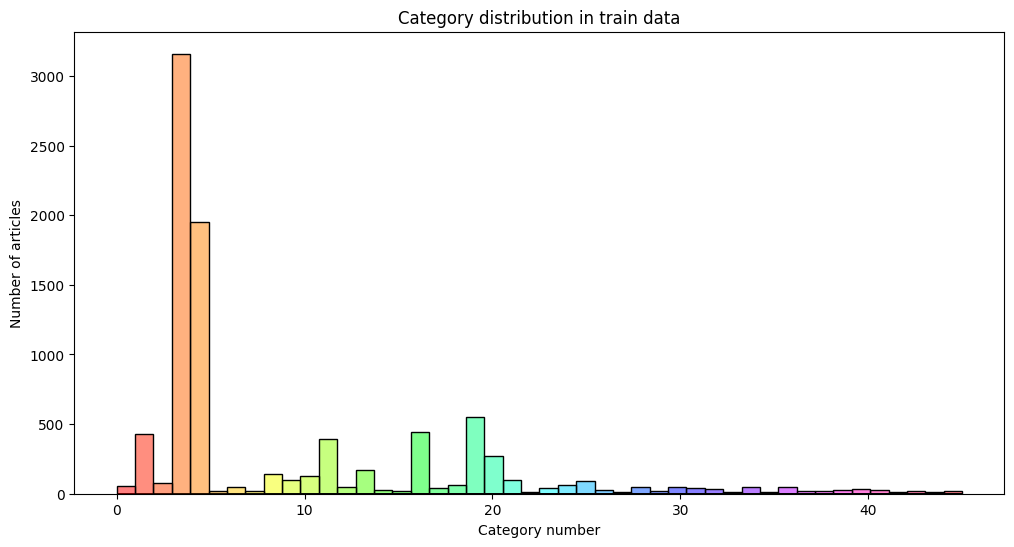

In [5]:
import seaborn as sns
import pandas as pd

# 데이터셋의 레이블값 분포를 플롯
data_train = pd.DataFrame(y_train, columns=['Category'])

plt.figure(figsize=(12, 6))
sns.histplot(data=data_train, x='Category', bins=num_classes, hue='Category', palette='hsv', legend=False)
plt.title('Category distribution in train data')
plt.xlabel('Category number')
plt.ylabel('Number of articles')
plt.show()

In [6]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements))) # 앞쪽 행렬은 레이블, 뒷쪽 행렬은 레이블의 count 값

각 레이블에 대한 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


- 4번 레이블이 가장 많은 빈도수를 보이고 있습니다. 
    - 3번 레이블은 총 3,159개가 존재하고 4번 레이블은 총 1,949개가 존재하는 것을 확인할 수 있습니다. 
- 데이터 셋에 들어있는 숫자들이 원래 어떤 텍스트인지 확인해보겠습니다.

In [7]:
word_to_index = reuters.get_word_index()
print(word_to_index)

{'mdbl': 10996, 'fawc': 16260, 'degussa': 12089, 'woods': 8803, 'hanging': 13796, 'localized': 20672, 'sation': 20673, 'chanthaburi': 20675, 'refunding': 10997, 'hermann': 8804, 'passsengers': 20676, 'stipulate': 20677, 'heublein': 8352, 'screaming': 20713, 'tcby': 16261, 'four': 185, 'grains': 1642, 'broiler': 20680, 'wooden': 12090, 'wednesday': 1220, 'highveld': 13797, 'duffour': 7593, '0053': 20681, 'elections': 3914, '270': 2563, '271': 3551, '272': 5113, '273': 3552, '274': 3400, 'rudman': 7975, '276': 3401, '277': 3478, '278': 3632, '279': 4309, 'dormancy': 9381, 'errors': 7247, 'deferred': 3086, 'sptnd': 20683, 'cooking': 8805, 'stratabit': 20684, 'designing': 16262, 'metalurgicos': 20685, 'databank': 13798, '300er': 20686, 'shocks': 20687, 'nawg': 7972, 'tnta': 20688, 'perforations': 20689, 'affiliates': 2891, '27p': 20690, 'ching': 16263, 'china': 595, 'wagyu': 16264, 'affiliated': 3189, 'chino': 16265, 'chinh': 16266, 'slickline': 20692, 'doldrums': 13799, 'kids': 12092, 'cl

- word_to_index에서 key와 value를 반대로 저장한 index_to_word를 만듭니다. 
- reuters.get_word_index()에 저장된 값에 +3을 해야 실제 맵핑되는 정수입니다.(로이터 데이터셋에서 정의한 룰)

In [8]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key
    
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[4]))
print('빈도수 상위 128등 단어 : {}'.format(index_to_word[131]))
print('빈도수 상위 10000등 단어 : {}'.format(index_to_word[1003]))
print('빈도수 상위 10000등 단어 : {}'.format(index_to_word[10003]))

빈도수 상위 1번 단어 : the
빈도수 상위 128등 단어 : tax
빈도수 상위 10000등 단어 : limit
빈도수 상위 10000등 단어 : profoundly


- index_to_word에서 숫자 0은 패딩을 의미하는 토큰인 pad, 숫자 1은 문장의 시작을 의미하는 sos, 숫자 2는 OOV를 위한 토큰인 unk라는 특별 토큰에 맵핑되어야 합니다. (로이터 데이터셋의 룰)

In [9]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token

# 첫번재 원소의 문장 살펴보기
print(' '.join([index_to_word[index] for index in X_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


- `load_data` 를 하면서 이미 어느정도 전처리가 된 상태여서 깔끔한 문장형태를 보이지는 않습니다.
- 차후에 데이터 증강을 고려하고있는데, 이 경우 처리결과가 좋지 않을 수도 있겠다는 생각이 듭니다.

## 데이터 로드 및 전처리

In [10]:
# 필요한 라이브러리를 임포트
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# TensorFlow 및 Keras에서 필요한 모듈을 임포트
from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

# reuters 데이터셋을 로드 및 데이터 분리
from tensorflow.keras.datasets import reuters
from sklearn.model_selection import train_test_split

In [11]:
# reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리

# Reuters 데이터를 로드
# num_words 는 전체 데이터에서 단어빈도수 상위 n개를 의미
# 즉, 전체 데이터셋에서 num_words 빈도만큼 등장하는 단어들을 사용하겠다는 의미
# 여기서는 전체 데이터셋의 단어중에서 등장빈도 상위 10000개의 단어들을 사용해서 문서를 표현하겠다는 의미
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000, test_split=0.2)

# 훈련 데이터와 검증 데이터를 분리
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력
print("훈련 데이터 수:", len(train_data))
print("검증 데이터 수:", len(val_data))
print("테스트 데이터 수:", len(test_data))
print("레이블 종류 수:", len(set(train_labels)))

훈련 데이터 수: 6736
검증 데이터 수: 2246
테스트 데이터 수: 2246
레이블 종류 수: 46


- 10000개의 단어를 사용해서 뉴스를 표현했으므로, 모델에 전달될 데이터도 10000개의 차원을 가져야 합니다.
- 즉, 각단어를 원핫 인코딩하여 백터화 할때, 이 백터의 크기또한 단어의 총 수와 같아야 합니다.

In [12]:
from tensorflow.keras.utils import to_categorical

# one_hot_encoding 함수 정의
def one_hot_encoding(data, dim=10000):
    # 결과 배열을 초기화. 
    # 크기 = 데이터의 길이 x dim
    results = np.zeros((len(data), dim))
    
    # 데이터를 하나씩 처리하며 one-hot encoding을 수행
    for i, sequence in enumerate(data):
        results[i, sequence] = 1.0
    
    return results

# 훈련 데이터, 검증 데이터, 테스트 데이터에 대한 one-hot encoding을 수행
x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들은 범주형 형태로 변환 to_categorical 함수를 사용
y_train = to_categorical(train_labels)
y_val = to_categorical(val_labels)
y_test = to_categorical(test_labels)

## 모델 구성 및 컴파일
- BatchNormalization과 Dropout을 적용하여 빠르게 학습하면서 과대적합을 방지하고, 46개의 뉴스 주제를 분류하는 딥러닝 모델을 만들고자 합니다.
- 노드 영상에 표현된 이미지 대로 구조를 설정합니다.

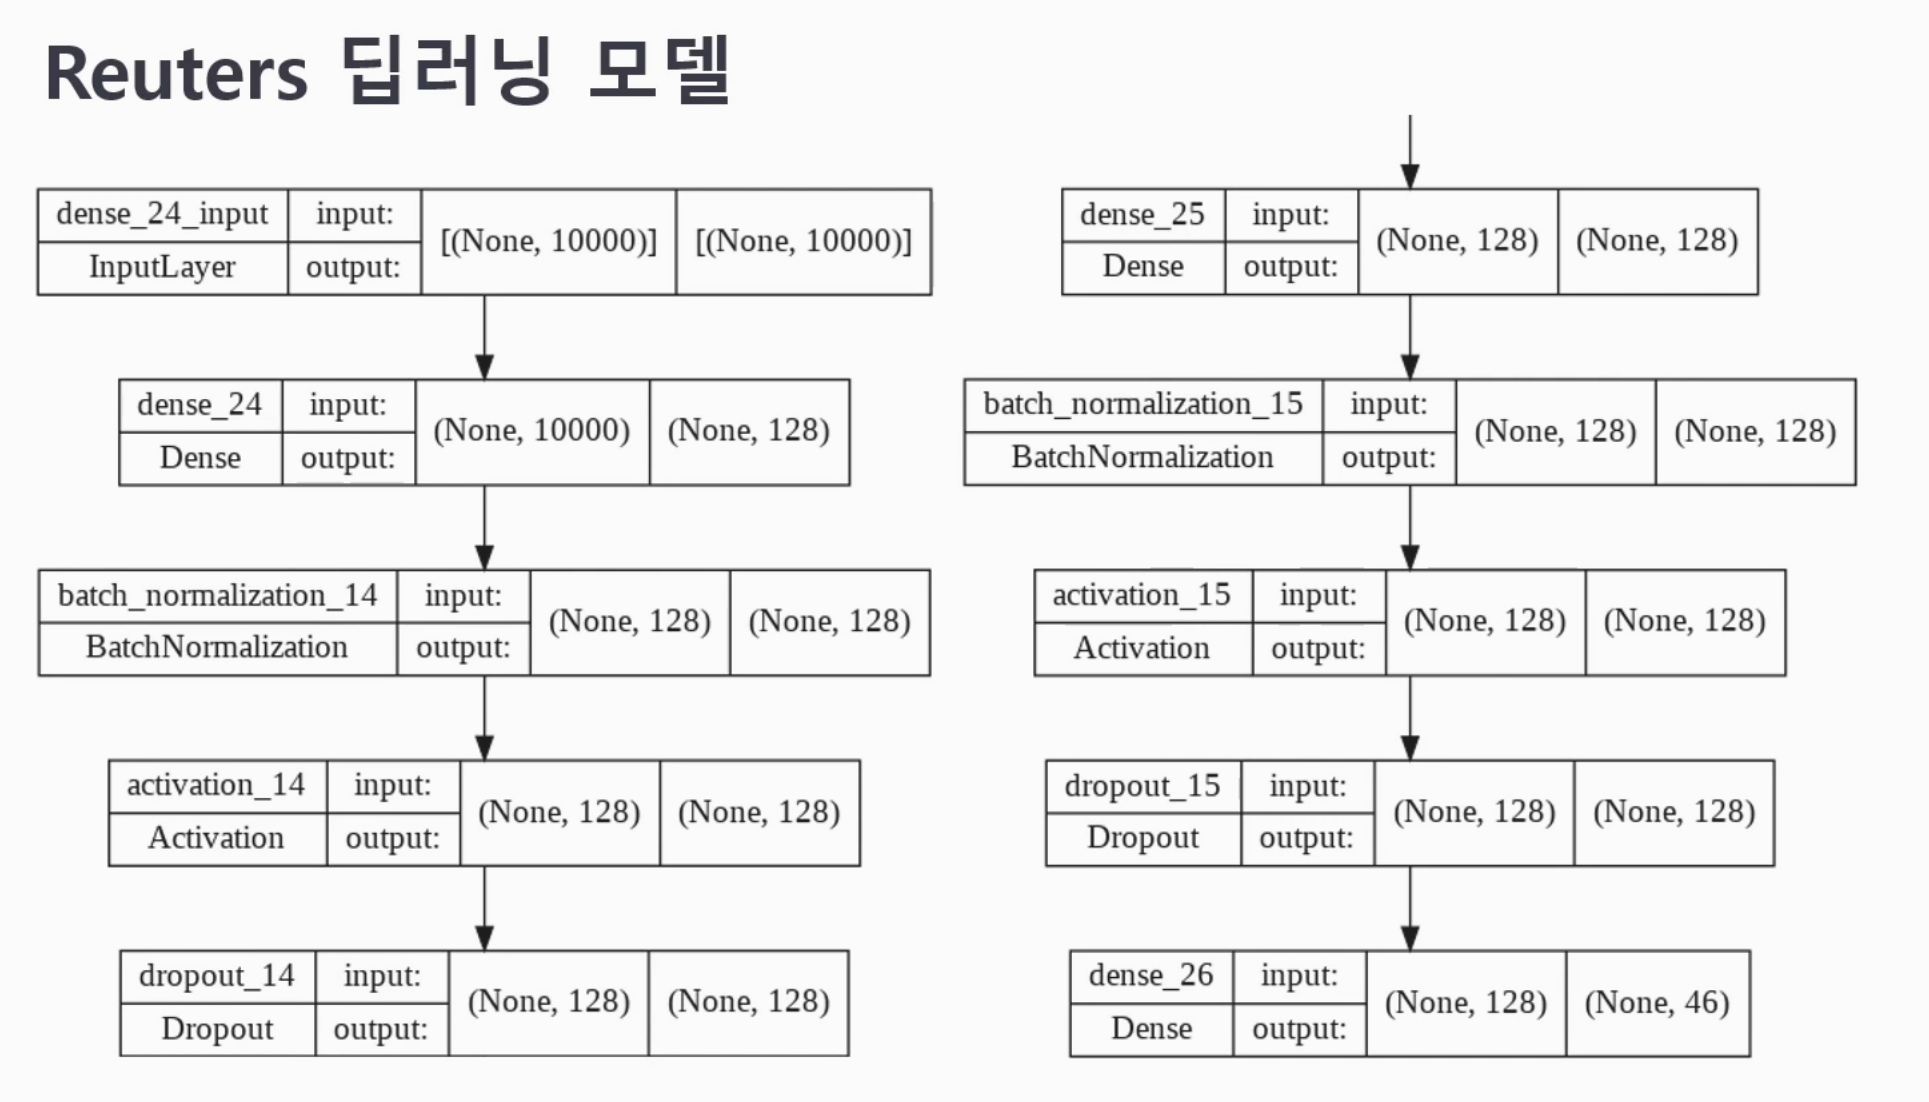

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout

# Sequential 모델을 생성
model = Sequential()

# 데이터의 표현에 10000개의 단어를 사용했고, 이 수만큼 원핫 인코딩을 했으므로, 입력차원도 동일한 수로 해야 함
# 입력 레이어를 추가 (입력 차원은 10000)
model.add(Dense(128, input_shape=(10000,)))

# BatchNormalization 레이어를 추가 이는 입력 데이터를 정규화
model.add(BatchNormalization())

# 활성화 함수로 'relu'를 사용하는 레이어를 추가
model.add(Activation('relu'))

# Dropout 레이어를 추가 50%의 뉴런을 랜덤하게 비활성화
model.add(Dropout(0.5))

# 두 번째 은닉 레이어를 추가 128개의 뉴런을 가짐
model.add(Dense(128))

# BatchNormalization 레이어를 추가
model.add(BatchNormalization())

# 활성화 함수로 'relu'를 사용하는 레이어를 추가
model.add(Activation('relu'))

# Dropout 레이어를 추가
model.add(Dropout(0.5))

# 출력 레이어를 추가 클래스 수가 46개이므로 'softmax' 활성화 함수를 사용
model.add(Dense(46, activation='softmax'))

# 모델 요약 출력
model.summary()

# 모델을 컴파일 'adam' 옵티마이저와 'categorical_crossentropy' 손실 함수를 사용
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280128   
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0

## 모델 학습

- ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
- 조기 종료를 통해 모델이 과적합 되는 것을 방지합니다.

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ModelCheckpoint: 모델 저장 경로 및 설정
model_checkpoint = ModelCheckpoint(
    filepath='baseline_model.h5',  # 모델을 저장할 파일 경로
    save_best_only=True,  # 가장 좋은 모델만 저장
    monitor='val_loss',  # 검증 손실을 기준으로 최적의 모델을 판단
    verbose=1  # 로그를 출력
)

# EarlyStopping: 조기 종료 조건 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준으로 조기 종료를 판단
    patience=5,  # 성능 향상이 없는 epoch를 얼마나 기다릴 것인지
    verbose=1  # 로그를 출력
)

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(
    x_train,  # 훈련 데이터
    y_train,  # 훈련 데이터 레이블
    epochs=100,  # 최대 epoch 수
    batch_size=512,  # 배치 크기
    validation_data=(x_val, y_val),  # 검증 데이터
    callbacks=[model_checkpoint, early_stopping],  # 콜백 함수 리스트
    verbose=2  # epoch마다 진행 상황을 어떻게 출력할지 결정
)

Epoch 1/100
14/14 - 1s - loss: 3.3173 - accuracy: 0.2571 - val_loss: 3.4345 - val_accuracy: 0.5423

Epoch 00001: val_loss improved from inf to 3.43446, saving model to baseline_model.h5
Epoch 2/100
14/14 - 0s - loss: 1.9390 - accuracy: 0.5784 - val_loss: 2.9327 - val_accuracy: 0.6402

Epoch 00002: val_loss improved from 3.43446 to 2.93274, saving model to baseline_model.h5
Epoch 3/100
14/14 - 0s - loss: 1.5230 - accuracy: 0.6574 - val_loss: 2.5759 - val_accuracy: 0.6852

Epoch 00003: val_loss improved from 2.93274 to 2.57593, saving model to baseline_model.h5
Epoch 4/100
14/14 - 0s - loss: 1.2748 - accuracy: 0.7041 - val_loss: 2.3525 - val_accuracy: 0.7066

Epoch 00004: val_loss improved from 2.57593 to 2.35249, saving model to baseline_model.h5
Epoch 5/100
14/14 - 0s - loss: 1.1319 - accuracy: 0.7365 - val_loss: 2.1726 - val_accuracy: 0.7297

Epoch 00005: val_loss improved from 2.35249 to 2.17264, saving model to baseline_model.h5
Epoch 6/100
14/14 - 0s - loss: 0.9948 - accuracy: 0.76

#### 학습 결과 과적합 판단 함수 생성

In [15]:
def analyze_model_performance(history, max_epochs):
    # history 객체에서 데이터 추출
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # 실제 학습된 epoch 수 확인
    actual_epochs = len(train_loss)

    # 조기 종료 여부 확인
    early_stopping = actual_epochs < max_epochs

    # 과적합 판단을 위한 내부 함수 정의
    def check_accuracy_gap():
        accuracy_gap = train_acc[-1] - val_acc[-1]
        return accuracy_gap > 0.05, f"최종 epoch의 훈련 정확도가 검증 정확도보다 {accuracy_gap:.2f}만큼 높습니다."

    def check_loss_trend():
        for epoch in range(1, actual_epochs):
            if train_loss[epoch] < train_loss[epoch - 1] and val_loss[epoch] < val_loss[epoch - 1]:
                continue
            elif val_loss[epoch] > val_loss[epoch - 1]:
                return True, f"Epoch {epoch + 1} 이후 검증 손실이 증가하고 있습니다."
        return False, ""

    def check_accuracy_over_epochs():
        return np.argmax(val_acc) < actual_epochs - 1, f"검증 정확도가 Epoch {np.argmax(val_acc)+1} 이후로 감소하고 있습니다."

    def check_loss_over_epochs():
        return np.argmin(val_loss) < actual_epochs - 1, f"검증 손실이 Epoch {np.argmin(val_loss)+1} 이후로 증가하고 있습니다."

    # 과적합 판단 기준 적용
    overfitting_criteria = {
        'accuracy_gap': check_accuracy_gap(),
        'loss_trend': check_loss_trend(),
        'accuracy_over_epochs': check_accuracy_over_epochs(),
        'loss_over_epochs': check_loss_over_epochs()
    }

    # 과적합 여부 최종 판단
    overfitting_detected = any(result for result, _ in overfitting_criteria.values())

    # 결과 출력
    print(f"과적합 판단 결과: {'과적합의 의심됩니다.' if overfitting_detected else '과적합이 의심되지 않습니다.'}")
    print('그 이유는 아래와 같습니다.')
    print('-'*70)
    for criterion, (result, reason) in overfitting_criteria.items():
        print(f"{criterion} 기준: {reason} ({'과적합' if result else '정상'})")

    # 조기 종료 여부에 따른 추가 메시지
    if early_stopping:
        print(f"주의: 학습이 조기 종료되었습니다 (최대 Epoch: {max_epochs}, 실제 Epoch: {actual_epochs}).")
        print("검증 손실이 최적화되지 않은 상태에서 학습이 중단될 수 있으므로, 추가적인 조정이 필요할 수 있습니다.")
        print('-'*70)

    # 추가적인 과적합 판단 및 해결 방안 제시 로직
    if overfitting_detected:
        # 과적합 시작 에포크 파악
        overfitting_start_epoch = None
        for epoch in range(1, actual_epochs):
            if val_loss[epoch] > val_loss[epoch - 1]:
                overfitting_start_epoch = epoch + 1
                break

        if overfitting_start_epoch is not None:
            print(f"  과적합이 시작되는 에포크는 대략 {overfitting_start_epoch}입니다.")
        
        # 학습 정확도와 검증 정확도의 차이가 큰 경우
        if train_acc[-1] > 0.75 and val_acc[-1] < 0.75:
            print("  - 학습 정확도는 높지만 검증 정확도가 낮으므로 드롭아웃을 시도해 보세요.")
            print('-'*70)

        # 학습 손실의 변동폭이 큰 경우
        if max(train_loss) - min(train_loss) > 0.5:
            print("  - 학습 손실의 변동폭이 크니 가중치 규제를 추가해보세요.")
            print('-'*70)

        # 과적합이 비교적 일찍 시작된 경우
        if overfitting_start_epoch is not None and overfitting_start_epoch < actual_epochs * 0.75:
            print("  - 과적합이 비교적 일찍 시작되었으니 조기 종료를 시도해보세요.")
            print('-'*70)

        # 학습률 관련 조정 필요 여부
        if train_loss[-1] > train_loss[0]:
            print("  - 학습률이 너무 높을 수 있습니다. 학습률을 줄여보세요.")
            print('-'*70)
        if (train_loss[-1] - min(train_loss)) > 0.1:
            print("  - 학습률이 너무 낮을 수 있습니다. 학습률을 늘려보세요.")
            print('-'*70)
    else:
        print("  과적합의 명확한 시작 지점을 찾을 수 없습니다. 모델이 잘 일반화되고 있는 것으로 보입니다.")
        print('-'*70)
    
    # 모델 성능 전반에 관한 추가 조언
    if train_loss[-1] > train_loss[0] and val_loss[-1] > val_loss[0]:
        print("  모델의 성능이 전반적으로 개선되지 않고 있습니다. 다음을 고려해보세요:")
        print("  - 현재 모델 구조가 데이터에 적합하지 않을 수 있습니다. 모델 구조 변경을 시도해 보세요.")
        print("  - 데이터 다양성 증가: 데이터셋의 다양성을 높이거나 데이터 양을 늘려보세요.")
        print('-'*70)
    elif not overfitting_detected and (train_loss[-1] < train_loss[0] or val_loss[-1] < val_loss[0]):
        print("  모델이 적절히 학습되고 있는것 같습니다. 추가적인 성능 향상을 위해 다음을 고려해보세요:")
        print("  - 하이퍼파라미터 튜닝: 학습률, 배치 크기 등을 조정해보세요.")
        print("  - 추가 데이터 활용: 더 많은 데이터를 사용하여 모델을 학습시키세요.")
        print('-'*70)
    
    print("다만, 이는 학습데이터에 대한 검증 결과이므로 테스트 데이터에 모델을 적용해서 정확한 판단을 할 필요가 있습니다.")

### 학습 결과 시각화

In [16]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

def plot_history(history, max_epochs):
    # 학습 히스토리에서 데이터 추출
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    # 실제 학습된 epoch 수
    actual_epochs = len(loss)

    # 조기 종료가 있었다면, 해당 epoch까지만 데이터를 사용
    if actual_epochs < max_epochs:
        epochs = range(1, actual_epochs + 1)
    else:
        epochs = range(1, max_epochs + 1)

    # 그림판을 생성
    fig = plt.figure(figsize=(12, 5))

    # 왼쪽 subplot 생성 및 손실 그래프 그리기
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(epochs, loss[:actual_epochs], 'b-', label='Train Loss')
    ax1.plot(epochs, val_loss[:actual_epochs], 'r-', label='Val Loss')
    ax1.set_title('Train & Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('손실')
    ax1.grid()
    ax1.legend()

    # 오른쪽 subplot 생성 및 정확도 그래프 그리기
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(epochs, accuracy[:actual_epochs], 'b-', label='Train Accuracy')
    ax2.plot(epochs, val_accuracy[:actual_epochs], 'r-', label='Val Accuracy')
    ax2.set_title('Train & Val Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid()
    ax2.legend()

    # 그래프 표시
    plt.show()

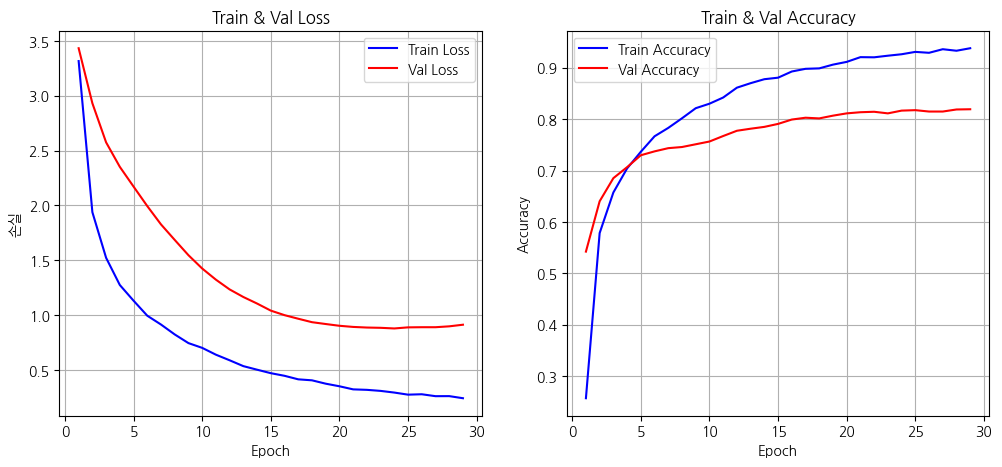

In [17]:
plot_history(history, max_epochs=100)

- val_loss가 감소하는 추세를 보이다가 다시 증가하는 경향을 보입니다.
- 조기종료가 되었음에도 모델의 과적합이 다소 의심되는 정확이 여럿있습니다. 
- 일단, 이 모델을 사용해 테스트 결과를 확인해보겠습니다.

## 학습결과 확인

In [18]:
import seaborn as sns

# 모델별로 테스트 결과를 가로 막대 그래프로 시각화하고, 막대 가운데에 수치를 표시하는 함수 (Seaborn 사용)
def plot_test_results(test_results):
    # 테스트 손실과 정확도를 분리하여 DataFrame으로 변환
    import pandas as pd
    data = []
    for model, metrics in test_results.items():
        data.append({'Model': model, 'Metric': 'Loss', 'Value': metrics['test_loss']})
        data.append({'Model': model, 'Metric': 'Accuracy', 'Value': metrics['test_accuracy']})
    df = pd.DataFrame(data)

    # 데이터 개수에 따라 그래프 크기 조절
    fig_height = max(4, 0.6 * len(df['Model'].unique()))

    # Seaborn 스타일 설정
    sns.set(style="whitegrid")

    # 가로 막대 그래프 그리기
    plt.figure(figsize=(12, fig_height))
    g = sns.barplot(x="Value", y="Model", hue="Metric", data=df, palette="muted")

    # 막대 가운데에 수치 표시
    for p in g.patches:
        width = p.get_width()
        plt.text(width / 2, p.get_y() + p.get_height() / 2,
                 f'{width:.4f}',
                 ha='center', va='center')

    plt.xlabel('Value')
    plt.title('Test Metrics per Model')
    plt.legend(loc='upper right')  # 범례 위치 변경
    plt.tight_layout()
    plt.show()

In [19]:
# 모델 평가 결과를 저장하고 업데이트하는 함수
def update_test_results(model_name, test_loss, test_accuracy, test_results=None):
    """
    주어진 모델 이름, 테스트 손실, 테스트 정확도를 받아서
    test_results 딕셔너리에 추가하거나 업데이트
    test_results 딕셔너리가 제공되지 않으면 직접 생성

    :param model_name: 모델의 이름 (string)
    :param test_loss: 모델의 테스트 손실 (float)
    :param test_accuracy: 모델의 테스트 정확도 (float)
    :param test_results: 모델 평가 결과를 저장하는 딕셔너리 (dict)
    :return: 업데이트된 test_results 딕셔너리
    """
    if test_results is None:
        test_results = {}
    test_results[model_name] = {'test_loss': test_loss, 'test_accuracy': test_accuracy}
    return test_results

In [20]:
from tensorflow.keras.models import load_model

# 가장 좋은 모델을 불러오기
best_model = load_model('baseline_model.h5')

# 불러온 모델로 테스트 데이터를 평가
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)

test_results = update_test_results('baseline_model', test_loss, test_accuracy)

print(f'테스트 손실: {test_loss:.4f}')
print(f'테스트 정확도: {test_accuracy:.4f}')

71/71 [==============================] - 0s 2ms/step - loss: 0.9601 - accuracy: 0.8028
테스트 손실: 0.9601
테스트 정확도: 0.8028


- 테스트 결과 상당히 높은 정확도(약 78%) 을 보여주고 있고, 손실값도 낮은 편입니다.

## 모델 성능 개선 - Part 1. 기존 데이터활용

- 이미 모델의 성능은 상당히 좋은 편이지만 몇가지 작업을 통해 모델 성능 향상을 시도해보겠습니다.
- 모델 성능 향상을 위해 하이퍼파라미터 튜닝, 데이터증강, 정규화, 모델 구조 변경, 교차검증, 앙상블 등 다양한 작업을 시도할 수 있습니다.
- 하지만 아래의 블로그에서 본 내용이 흥미로워 이를 적용해서 모델 구조 변경을 하고 결과를 비교해 보겠습니다.
    - [BatchNormalization, Dropout, Pooling 적용 순서](https://gaussian37.github.io/dl-concept-order_of_regularization_term/)
    - 해당 블로그에서는 `Convolution - Batch Normalization - Activation - Dropout - Pooling 순서로 네트워크를 구성` 할 것을 추천하고 있습니다.
    - 다만, 이 경우 CNN 모델에 대한 구조여서  'Batch Normalization' - 'Activation' - 'Dropout' 순서만 참고하겠습니다.

### 모델 구조 변경

In [21]:
model = Sequential()
# 첫 번째 Dense 레이어
model.add(Dense(128, input_shape=(10000,)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Dropout 비율은 조정 가능

# 두 번째 Dense 레이어
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  # 마찬가지로 Dropout 비율은 조정 가능

# 출력 레이어
model.add(Dense(46, activation='softmax'))  # 46개 클래스 분류를 위한 softmax 활성화 함수

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1280128   
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
activation_3 (Activation)    (None, 128)              

### 모델 재학습 (조기 종료 유지)

In [22]:
# ModelCheckpoint: 모델 저장 경로 및 설정
model_checkpoint = ModelCheckpoint(
    filepath='best_model_2.h5',  # 모델을 저장할 파일 경로
    save_best_only=True,  # 가장 좋은 모델만 저장
    monitor='val_loss',  # 검증 손실을 기준으로 최적의 모델을 판단
    verbose=1  # 로그를 출력
)

# EarlyStopping: 조기 종료 조건 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준으로 조기 종료를 판단
    patience=10,  # 성능 향상이 없는 epoch를 얼마나 기다릴 것인지
    verbose=1  # 로그를 출력
)

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history2 = model.fit(
    x_train,  # 훈련 데이터
    y_train,  # 훈련 데이터 레이블
    epochs=100,  # 최대 epoch 수
    batch_size=512,  # 배치 크기
    validation_data=(x_val, y_val),  # 검증 데이터
    callbacks=[model_checkpoint, early_stopping],  # 콜백 함수 리스트
    verbose=2  # epoch마다 진행 상황을 어떻게 출력할지 결정
)

Epoch 1/100
14/14 - 1s - loss: 3.1183 - accuracy: 0.3245 - val_loss: 3.4268 - val_accuracy: 0.5641

Epoch 00001: val_loss improved from inf to 3.42679, saving model to best_model_2.h5
Epoch 2/100
14/14 - 0s - loss: 1.9060 - accuracy: 0.5779 - val_loss: 2.9501 - val_accuracy: 0.6483

Epoch 00002: val_loss improved from 3.42679 to 2.95014, saving model to best_model_2.h5
Epoch 3/100
14/14 - 0s - loss: 1.4901 - accuracy: 0.6655 - val_loss: 2.6348 - val_accuracy: 0.6959

Epoch 00003: val_loss improved from 2.95014 to 2.63484, saving model to best_model_2.h5
Epoch 4/100
14/14 - 0s - loss: 1.2677 - accuracy: 0.7043 - val_loss: 2.4113 - val_accuracy: 0.7133

Epoch 00004: val_loss improved from 2.63484 to 2.41125, saving model to best_model_2.h5
Epoch 5/100
14/14 - 0s - loss: 1.1277 - accuracy: 0.7349 - val_loss: 2.2038 - val_accuracy: 0.7257

Epoch 00005: val_loss improved from 2.41125 to 2.20383, saving model to best_model_2.h5
Epoch 6/100
14/14 - 0s - loss: 1.0088 - accuracy: 0.7577 - val_l

#### 다수의 모델 학습 결과를 비교하는 시각화함수 생성 

In [23]:
import koreanize_matplotlib
def diff_history(history1, history2):
    # 두 개의 모델 히스토리를 받아오기
    history1_dict = history1.history
    history2_dict = history2.history
    
    # 각 모델의 훈련 손실 및 검증 손실을 가져오기
    h1_loss = history1_dict['loss']
    h1_val_loss = history1_dict['val_loss']
    h2_loss = history2_dict['loss']
    h2_val_loss = history2_dict['val_loss']

    # epoch 범위를 설정
    epochs1 = range(1, len(h1_loss) + 1)
    epochs2 = range(1, len(h2_loss) + 1)

    # 그래프를 생성
    fig = plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # 첫 번째 서브플롯: 훈련 및 검증 손실 그래프
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(epochs1, h1_loss, 'b-', label='train_loss')  # 첫 번째 모델의 훈련 손실
    ax1.plot(epochs1, h1_val_loss, 'r-', label='val_loss')  # 첫 번째 모델의 검증 손실
    ax1.plot(epochs2, h2_loss, 'b--', label='train_loss')  # 두 번째 모델의 훈련 손실
    ax1.plot(epochs2, h2_val_loss, 'r--', label='val_loss')  # 두 번째 모델의 검증 손실
    ax1.set_title('Train & Val Loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend()

    # 각 모델의 훈련 정확도 및 검증 정확도를 가져오기
    h1_accuracy = history1_dict['accuracy']
    h1_val_accuracy = history1_dict['val_accuracy']
    h2_accuracy = history2_dict['accuracy']
    h2_val_accuracy = history2_dict['val_accuracy']

    # 두 번째 서브플롯: 훈련 및 검증 정확도 그래프
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(epochs1, h1_accuracy, 'b-', label='train_accuracy')  # 첫 번째 모델의 훈련 정확도
    ax2.plot(epochs1, h1_val_accuracy, 'r-', label='val_accuracy')  # 첫 번째 모델의 검증 정확도
    ax2.plot(epochs2, h2_accuracy, 'b--', label='train_accuracy')  # 두 번째 모델의 훈련 정확도
    ax2.plot(epochs2, h2_val_accuracy, 'r--', label='val_accuracy')  # 두 번째 모델의 검증 정확도
    ax2.set_title('Train & Val Acc')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid()
    ax2.legend()

    # 그래프를 표시
    plt.show()

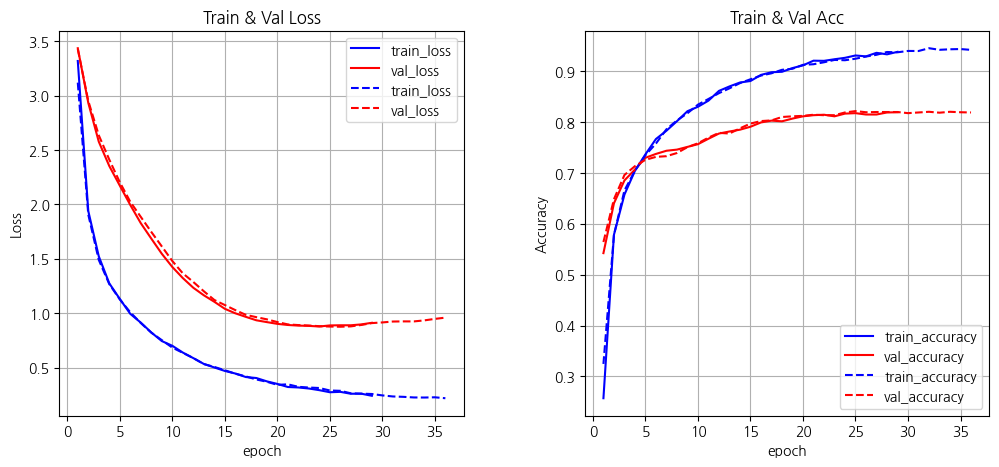

In [24]:
diff_history(history, history2)

### 학습 결과 확인(모델구조 변경 ver)

71/71 [==============================] - 0s 2ms/step - loss: 0.9820 - accuracy: 0.8010


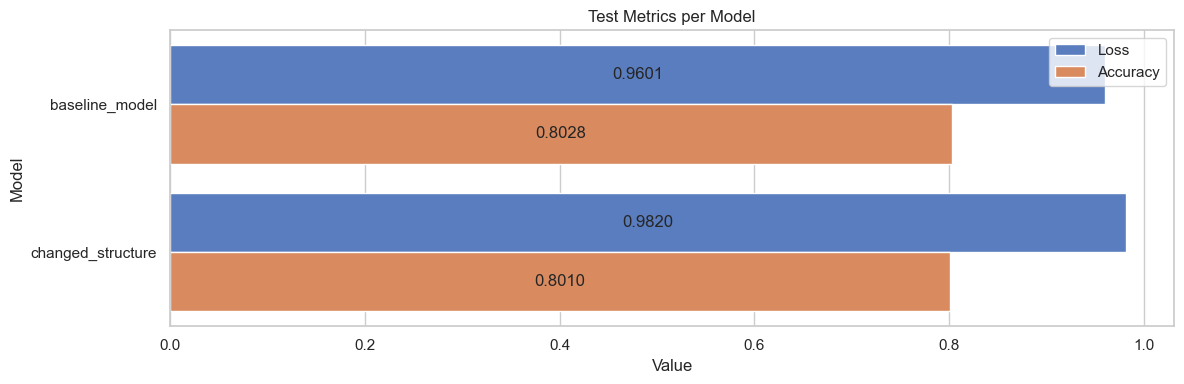

테스트 손실: 0.9820
테스트 정확도: 0.8010


In [25]:
# 가장 좋은 모델을 불러오기
best_model = load_model('best_model_2.h5')

# 불러온 모델로 테스트 데이터를 평가
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)

# 모델 결과 저장
test_results = update_test_results('changed_structure', test_loss, test_accuracy, test_results)

# 테스트 결과 비교
plot_test_results(test_results)

print(f'테스트 손실: {test_loss:.4f}')
print(f'테스트 정확도: {test_accuracy:.4f}')

- 기존 모델에 레이어의 적용순서에 변경을 주었더니 성능이 소폭 향상했습니다.
- 모델 학습시에 val_loss의 변동이 있으므로 규제를 적용해 손실 변동을 줄이고 모델 일반화 능력을 높여보겠습니다.

### 규제 적용

- 조기 종료로 인해 대체적인 과적합을 억제할수는 있었지만, 모델 구조 자체에 규제를 추가함으로서 모델의 안정성을 좀 더 늘려보면 좋을 것 같습니다.
- L2 규제를 사용해서 모델을 재구성하여 학습해보도록 하겠습니다.

---

- 입력 레이어에 규제를 적용함으로 각 입력 특성의 가중치에 대한 규제를 강화해 입력 데이터의 특성을 모델이 동등하게 받아들이고, 가중치를 공유하도록 모델을 공유할 수 있습니다.
- 이런 방식은 입력 차원이 크고, 특성간 상호 작용이 복잡한 경우 유용할 수 있고, 현재 데이터가 텍스트데이터로 특성간 상호 작용이 복잡하고, 입력차원도 10000으로 큰편이라 유용할 것 같아 적용해보았습니다.

---

#### 모델 구성 및 컴파일

In [26]:
from tensorflow.keras.regularizers import l2

# Sequential 모델을 생성
model = Sequential()

# 입력 레이어를 추가 (입력 차원은 10000)
model.add(Dense(128, input_shape=(10000,), kernel_regularizer=l2(0.01)))

# BatchNormalization 레이어를 추가 이는 입력 데이터를 정규화
model.add(BatchNormalization())

# 활성화 함수로 'relu'를 사용하는 레이어를 추가
model.add(Activation('relu'))

# 두 번째 은닉 레이어를 추가 128개의 뉴런을 가짐
model.add(Dense(128, kernel_regularizer=l2(0.01)))

# BatchNormalization 레이어를 추가
model.add(BatchNormalization())

# 활성화 함수로 'relu'를 사용하는 레이어를 추가
model.add(Activation('relu'))

# Dropout 레이어를 추가 활성화 함수 이후에 50%의 뉴런을 랜덤하게 비활성화
model.add(Dropout(0.5))

# 출력 레이어를 추가 클래스 수가 46개이므로 'softmax' 활성화 함수를 사용
model.add(Dense(46, activation='softmax'))

# 모델 요약 출력
model.summary()

# 모델을 컴파일 'adam' 옵티마이저와 'categorical_crossentropy' 손실 함수를 사용
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1280128   
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

#### 모델 재학습(L2 규제 적용)

In [27]:
# ModelCheckpoint: 모델 저장 경로 및 설정
model_checkpoint = ModelCheckpoint(
    filepath='L2_model.h5',  # 모델을 저장할 파일 경로
    save_best_only=True,  # 가장 좋은 모델만 저장
    monitor='val_loss',  # 검증 손실을 기준으로 최적의 모델을 판단
    verbose=1  # 로그를 출력
)

# EarlyStopping: 조기 종료 조건 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준으로 조기 종료를 판단
    patience=10,  # 성능 향상이 없는 epoch를 얼마나 기다릴 것인지
    verbose=1  # 로그를 출력
)

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history3 = model.fit(
    x_train,  # 훈련 데이터
    y_train,  # 훈련 데이터 레이블
    epochs=100,  # 최대 epoch 수
    batch_size=512,  # 배치 크기 (GPU 메모리 한계로 512에서 64로변경) # 이 부분이 성능악화에 영향을 미칠수도 있을 것 같음
    validation_data=(x_val, y_val),  # 검증 데이터
    callbacks=[model_checkpoint, early_stopping],  # 콜백 함수 리스트
    verbose=2  # epoch마다 진행 상황을 어떻게 출력할지 결정
)

Epoch 1/100
14/14 - 1s - loss: 5.9960 - accuracy: 0.3934 - val_loss: 6.1813 - val_accuracy: 0.6238

Epoch 00001: val_loss improved from inf to 6.18125, saving model to L2_model.h5
Epoch 2/100
14/14 - 0s - loss: 3.8999 - accuracy: 0.7133 - val_loss: 5.3809 - val_accuracy: 0.7146

Epoch 00002: val_loss improved from 6.18125 to 5.38087, saving model to L2_model.h5
Epoch 3/100
14/14 - 0s - loss: 2.9972 - accuracy: 0.7931 - val_loss: 4.8329 - val_accuracy: 0.7413

Epoch 00003: val_loss improved from 5.38087 to 4.83295, saving model to L2_model.h5
Epoch 4/100
14/14 - 0s - loss: 2.3799 - accuracy: 0.8417 - val_loss: 4.3945 - val_accuracy: 0.7155

Epoch 00004: val_loss improved from 4.83295 to 4.39455, saving model to L2_model.h5
Epoch 5/100
14/14 - 0s - loss: 1.9300 - accuracy: 0.8796 - val_loss: 4.0583 - val_accuracy: 0.5957

Epoch 00005: val_loss improved from 4.39455 to 4.05825, saving model to L2_model.h5
Epoch 6/100
14/14 - 0s - loss: 1.5957 - accuracy: 0.9109 - val_loss: 3.7815 - val_ac

14/14 - 0s - loss: 0.4730 - accuracy: 0.9567 - val_loss: 1.3831 - val_accuracy: 0.7939

Epoch 00048: val_loss did not improve from 1.23609
Epoch 49/100
14/14 - 0s - loss: 0.4960 - accuracy: 0.9562 - val_loss: 1.3568 - val_accuracy: 0.7996

Epoch 00049: val_loss did not improve from 1.23609
Epoch 50/100
14/14 - 0s - loss: 0.5221 - accuracy: 0.9534 - val_loss: 1.3717 - val_accuracy: 0.7930

Epoch 00050: val_loss did not improve from 1.23609
Epoch 51/100
14/14 - 0s - loss: 0.5133 - accuracy: 0.9574 - val_loss: 1.3862 - val_accuracy: 0.7992

Epoch 00051: val_loss did not improve from 1.23609
Epoch 52/100
14/14 - 0s - loss: 0.4907 - accuracy: 0.9595 - val_loss: 1.4137 - val_accuracy: 0.7885

Epoch 00052: val_loss did not improve from 1.23609
Epoch 00052: early stopping


#### 학습 결과 확인

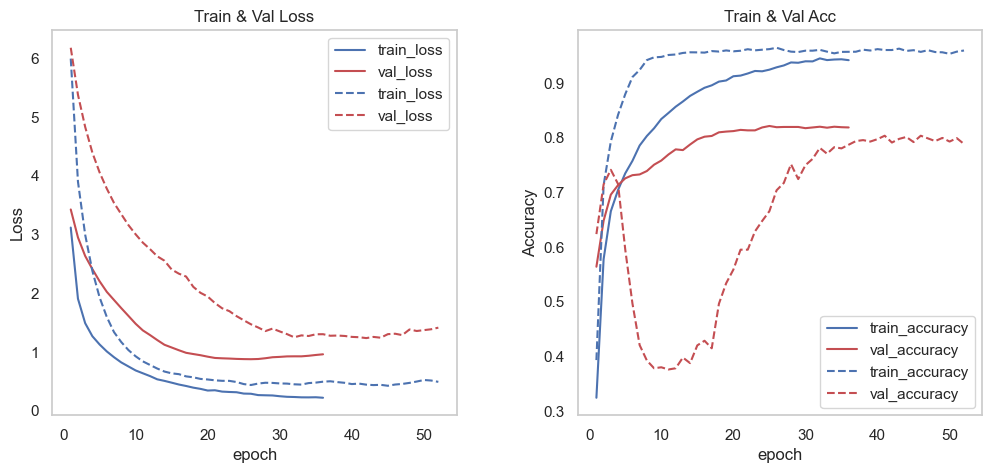

In [28]:
diff_history(history2, history3)

71/71 [==============================] - 0s 2ms/step - loss: 1.3352 - accuracy: 0.7756


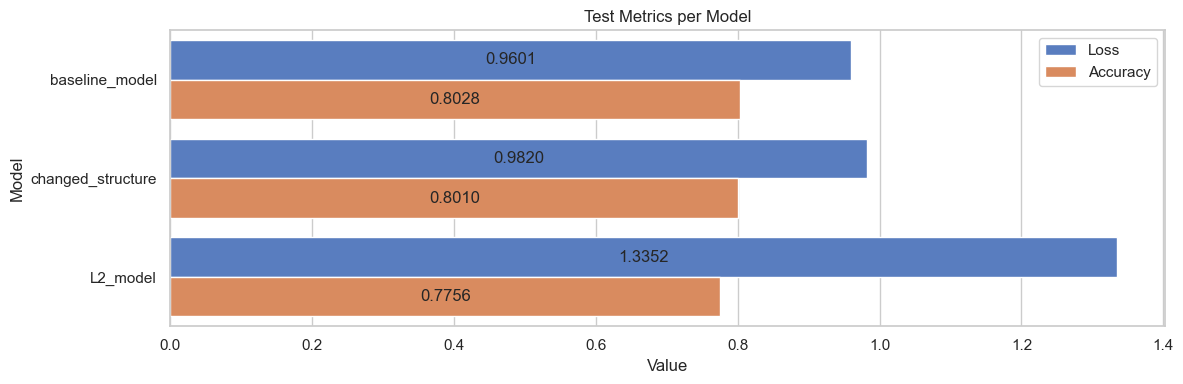

테스트 손실: 1.3352
테스트 정확도: 0.7756


In [29]:
# 가장 좋은 모델을 불러오기
best_model = load_model('L2_model.h5')

# 불러온 모델로 테스트 데이터를 평가
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)

# 모델 결과 저장
test_results = update_test_results('L2_model', test_loss, test_accuracy, test_results)

# 테스트 결과 비교
plot_test_results(test_results)

print(f'테스트 손실: {test_loss:.4f}')
print(f'테스트 정확도: {test_accuracy:.4f}')

- 규제를 가한 결과 모델의 성능이 더 떨어진 것을 확인할 수 있습니다.
- L2 규제 강도를 0.01로 설정했는데, 모델에 대한 규제가 너무 강해 복잡한 패턴 학습에 실패한 것 같습니다.
- L2 규제의 경우 이론적으로 손실함수에 추가적인 항을 더하는 개념이라 최적화 과정에 영향을 미칩니다. 이로 인해 학습률이나 최적화 관련 하이퍼파라미터의 조정이 필요할 수 있습니다.
- 모델 개선을 위해서 L2 규제 강도를 조절하고, 학습률 스케줄링등을 사용해 학습률 조정을 시도해보겠습니다.

### 규제강도 하락

- 일단 규제강도를 낮추서 테스트를 해본 이후, 성능 개선이 이뤄지지 않는다면, 학습률 조정을 고려해보겠습니다.

#### 모델 구성 및 컴파일

In [30]:
# 모델 생성
model = Sequential()

# L2 규제의 강도를 낮춥니다. 이전보다 낮은 0.001 값을 사용합니다.
l2_reg = l2(0.001)

# 입력 레이어를 추가합니다.
model.add(Dense(128, input_shape=(10000,), kernel_regularizer=l2_reg))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 두 번째 은닉 레이어를 추가합니다.
model.add(Dense(128, kernel_regularizer=l2_reg))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 출력 레이어를 추가합니다.
model.add(Dense(46, activation='softmax'))

# 모델 요약 출력
model.summary()

# 모델 컴파일. 학습률을 조정할 수 있습니다. 
# Adam 옵티마이저의 기본 학습률은 0.001입니다. 필요에 따라 조정할 수 있습니다.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               1280128   
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
activation_6 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
activation_7 (Activation)    (None, 128)              

#### 모델 학습 (조기종료 유지)

In [31]:
# ModelCheckpoint: 모델 저장 경로 및 설정
model_checkpoint = ModelCheckpoint(
    filepath='L2_low_regulation.h5',  # 모델을 저장할 파일 경로
    save_best_only=True,  # 가장 좋은 모델만 저장
    monitor='val_loss',  # 검증 손실을 기준으로 최적의 모델을 판단
    verbose=1  # 로그를 출력
)

# EarlyStopping: 조기 종료 조건 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준으로 조기 종료를 판단
    patience=10,  # 성능 향상이 없는 epoch를 얼마나 기다릴 것인지
    verbose=1  # 로그를 출력
)

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history4 = model.fit(
    x_train,  # 훈련 데이터
    y_train,  # 훈련 데이터 레이블
    epochs=100,  # 최대 epoch 수
    batch_size=512,  # 배치 크기
    validation_data=(x_val, y_val),  # 검증 데이터
    callbacks=[model_checkpoint, early_stopping],  # 콜백 함수 리스트
    verbose=2  # epoch마다 진행 상황을 어떻게 출력할지 결정
)

Epoch 1/100
14/14 - 1s - loss: 3.7578 - accuracy: 0.2677 - val_loss: 3.8127 - val_accuracy: 0.5864

Epoch 00001: val_loss improved from inf to 3.81268, saving model to L2_low_regulation.h5
Epoch 2/100
14/14 - 0s - loss: 2.3192 - accuracy: 0.5849 - val_loss: 3.3492 - val_accuracy: 0.6607

Epoch 00002: val_loss improved from 3.81268 to 3.34917, saving model to L2_low_regulation.h5
Epoch 3/100
14/14 - 0s - loss: 1.8268 - accuracy: 0.6669 - val_loss: 2.9672 - val_accuracy: 0.7021

Epoch 00003: val_loss improved from 3.34917 to 2.96719, saving model to L2_low_regulation.h5
Epoch 4/100
14/14 - 0s - loss: 1.5810 - accuracy: 0.7132 - val_loss: 2.7021 - val_accuracy: 0.7128

Epoch 00004: val_loss improved from 2.96719 to 2.70208, saving model to L2_low_regulation.h5
Epoch 5/100
14/14 - 0s - loss: 1.4505 - accuracy: 0.7328 - val_loss: 2.4971 - val_accuracy: 0.7133

Epoch 00005: val_loss improved from 2.70208 to 2.49710, saving model to L2_low_regulation.h5
Epoch 6/100
14/14 - 0s - loss: 1.3161 -

#### 학습 결과 확인

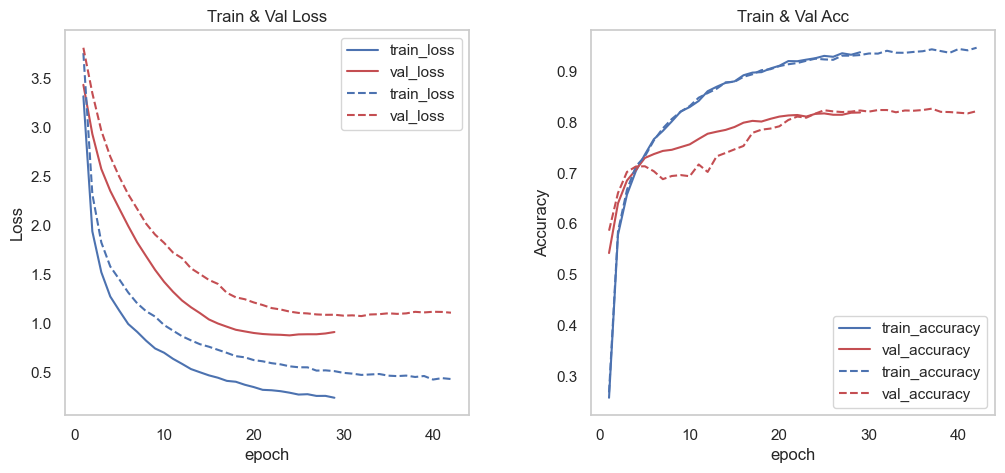

In [32]:
diff_history(history, history4)

71/71 [==============================] - 0s 2ms/step - loss: 1.1737 - accuracy: 0.8014


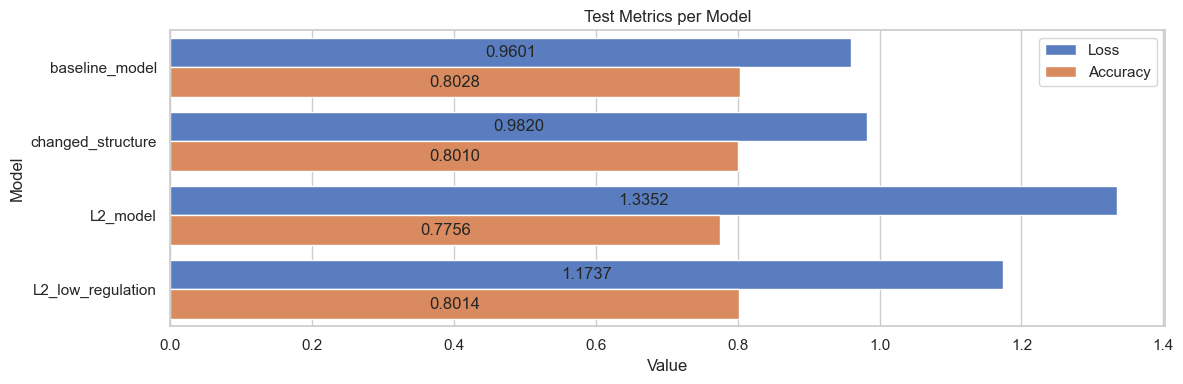

테스트 손실: 1.1737
테스트 정확도: 0.8014


In [33]:
# 가장 좋은 모델을 불러오기
best_model = load_model('L2_low_regulation.h5')

# 불러온 모델로 테스트 데이터를 평가
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)

# 모델 결과 저장
test_results = update_test_results('L2_low_regulation', test_loss, test_accuracy, test_results)

# 테스트 결과 비교
plot_test_results(test_results)

print(f'테스트 손실: {test_loss:.4f}')
print(f'테스트 정확도: {test_accuracy:.4f}')

- 규제강도를 낮췄더니 손실과 정확도 모두 상승된 결과를 보여줍니다.
- 규제의 강도가 너무 강했던 것이 원인임이 명확해 보입니다.

### 학습률 조정

- 규제를 유지한 상태에서 학습률 조정을 시도해보겠습니다.

#### 모델 구성 및 컴파일

In [34]:
# 모델 생성
model = Sequential()

# L2 규제의 강도를 낮춥니다. 이전보다 낮은 0.001 값을 사용합니다.
l2_reg = l2(0.001)

# 입력 레이어를 추가합니다.
model.add(Dense(128, input_shape=(10000,), kernel_regularizer=l2_reg))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 두 번째 은닉 레이어를 추가합니다.
model.add(Dense(128, kernel_regularizer=l2_reg))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 출력 레이어를 추가합니다.
model.add(Dense(46, activation='softmax'))

# 모델 요약 출력
model.summary()

from tensorflow.keras.optimizers import Adam

# Adam 옵티마이저를 생성하고, 학습률을 설정
# 예를 들어, 학습률을 0.0001로 설정
adam = Adam(learning_rate=0.0001)

# 모델 컴파일. 학습률을 조정할 수 있습니다. 
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               1280128   
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512       
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
activation_9 (Activation)    (None, 128)              

In [35]:
# ModelCheckpoint: 모델 저장 경로 및 설정
model_checkpoint = ModelCheckpoint(
    filepath='advancde_L2_low_learningrate.h5',  # 모델을 저장할 파일 경로
    save_best_only=True,  # 가장 좋은 모델만 저장
    monitor='val_loss',  # 검증 손실을 기준으로 최적의 모델을 판단
    verbose=1  # 로그를 출력
)

# EarlyStopping: 조기 종료 조건 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준으로 조기 종료를 판단
    patience=10,  # 성능 향상이 없는 epoch를 얼마나 기다릴 것인지
    verbose=1  # 로그를 출력
)

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history5 = model.fit(
    x_train,  # 훈련 데이터
    y_train,  # 훈련 데이터 레이블
    epochs=100,  # 최대 epoch 수
    batch_size=512,  # 배치 크기
    validation_data=(x_val, y_val),  # 검증 데이터
    callbacks=[model_checkpoint, early_stopping],  # 콜백 함수 리스트
    verbose=2  # epoch마다 진행 상황을 어떻게 출력할지 결정
)

Epoch 1/100
14/14 - 1s - loss: 3.6251 - accuracy: 0.2634 - val_loss: 3.8046 - val_accuracy: 0.5801

Epoch 00001: val_loss improved from inf to 3.80461, saving model to advancde_L2_low_learningrate.h5
Epoch 2/100
14/14 - 0s - loss: 2.2510 - accuracy: 0.5805 - val_loss: 3.3262 - val_accuracy: 0.6554

Epoch 00002: val_loss improved from 3.80461 to 3.32617, saving model to advancde_L2_low_learningrate.h5
Epoch 3/100
14/14 - 0s - loss: 1.8142 - accuracy: 0.6606 - val_loss: 2.9863 - val_accuracy: 0.6803

Epoch 00003: val_loss improved from 3.32617 to 2.98627, saving model to advancde_L2_low_learningrate.h5
Epoch 4/100
14/14 - 0s - loss: 1.5845 - accuracy: 0.7081 - val_loss: 2.7415 - val_accuracy: 0.7008

Epoch 00004: val_loss improved from 2.98627 to 2.74149, saving model to advancde_L2_low_learningrate.h5
Epoch 5/100
14/14 - 0s - loss: 1.4228 - accuracy: 0.7383 - val_loss: 2.5446 - val_accuracy: 0.7164

Epoch 00005: val_loss improved from 2.74149 to 2.54462, saving model to advancde_L2_low_

#### 학습 결과 확인

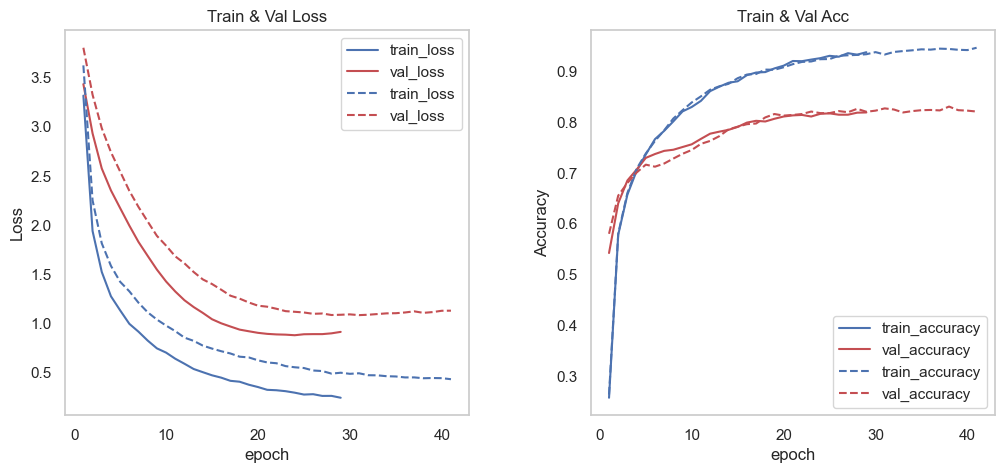

In [36]:
diff_history(history, history5)

In [37]:
analyze_model_performance(history5, 100)

과적합 판단 결과: 과적합의 의심됩니다.
그 이유는 아래와 같습니다.
----------------------------------------------------------------------
accuracy_gap 기준: 최종 epoch의 훈련 정확도가 검증 정확도보다 0.13만큼 높습니다. (과적합)
loss_trend 기준: Epoch 27 이후 검증 손실이 증가하고 있습니다. (과적합)
accuracy_over_epochs 기준: 검증 정확도가 Epoch 38 이후로 감소하고 있습니다. (과적합)
loss_over_epochs 기준: 검증 손실이 Epoch 31 이후로 증가하고 있습니다. (과적합)
주의: 학습이 조기 종료되었습니다 (최대 Epoch: 100, 실제 Epoch: 41).
검증 손실이 최적화되지 않은 상태에서 학습이 중단될 수 있으므로, 추가적인 조정이 필요할 수 있습니다.
----------------------------------------------------------------------
  과적합이 시작되는 에포크는 대략 27입니다.
  - 학습 손실의 변동폭이 크니 가중치 규제를 추가해보세요.
----------------------------------------------------------------------
  - 과적합이 비교적 일찍 시작되었으니 조기 종료를 시도해보세요.
----------------------------------------------------------------------
다만, 이는 학습데이터에 대한 검증 결과이므로 테스트 데이터에 모델을 적용해서 정확한 판단을 할 필요가 있습니다.


71/71 [==============================] - 0s 2ms/step - loss: 1.1855 - accuracy: 0.8019


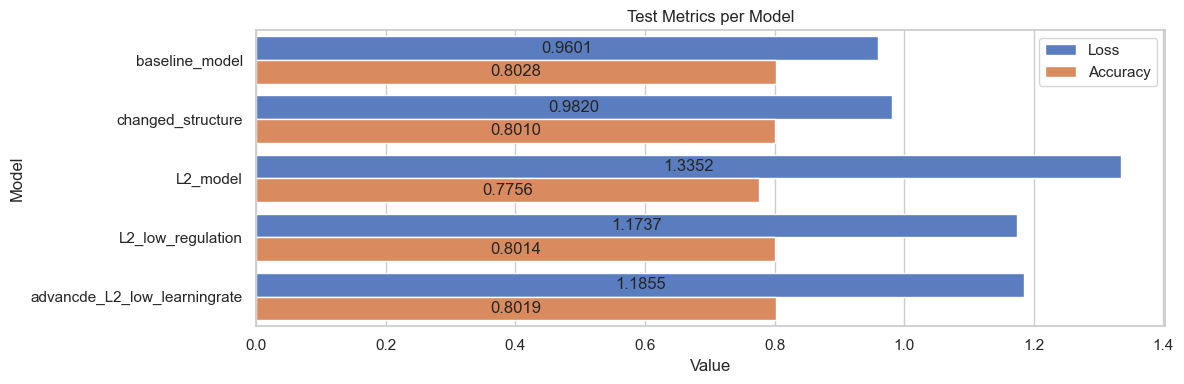

테스트 손실: 1.1855
테스트 정확도: 0.8019


In [38]:
# 가장 좋은 모델을 불러오기
best_model = load_model('advancde_L2_low_learningrate.h5')

# 불러온 모델로 테스트 데이터를 평가
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)

# 모델 결과 저장
test_results = update_test_results('advancde_L2_low_learningrate', test_loss, test_accuracy, test_results)

# 테스트 결과 비교
plot_test_results(test_results)

print(f'테스트 손실: {test_loss:.4f}')
print(f'테스트 정확도: {test_accuracy:.4f}')

- L2 규제의 강도를 낮추고 학습률을 더 세밀하게 조정(0.001 → 0.0001) 로 조정했더니 모델의 성능이 소폭 향상되었습니다.
- 학습률 스케줄링을 적용해 학습률을 동적으로 조정해 성능 향상을 시도해보겠습니다.

### 학습률 스케줄링 적용

#### 모델 구성 및 컴파일

In [39]:
# 모델 생성
model = Sequential()

# L2 규제의 강도
l2_reg = l2(0.001)

# 입력 레이어를 추가
model.add(Dense(128, input_shape=(10000,), kernel_regularizer=l2_reg))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 두 번째 은닉 레이어를 추가
model.add(Dense(128, kernel_regularizer=l2_reg))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 출력 레이어를 추가
model.add(Dense(46, activation='softmax'))

# 모델 요약 출력
model.summary()

# Adam 옵티마이저를 생성하고, 학습률을 설정
# 학습률을 0.0001로 설정
adam = Adam(learning_rate=0.0001)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               1280128   
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
activation_10 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_11 (Batc (None, 128)               512       
_________________________________________________________________
activation_11 (Activation)   (None, 128)              

In [40]:
# ModelCheckpoint: 모델 저장 경로 및 설정
model_checkpoint = ModelCheckpoint(
    filepath='advancde_L2_low_learningrate_scheduling.h5',  # 모델을 저장할 파일 경로
    save_best_only=True,  # 가장 좋은 모델만 저장
    monitor='val_loss',  # 검증 손실을 기준으로 최적의 모델을 판단
    verbose=1  # 로그를 출력
)

# EarlyStopping: 조기 종료 조건 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준으로 조기 종료를 판단
    patience=10,  # 성능 향상이 없는 epoch를 얼마나 기다릴 것인지
    verbose=1  # 로그를 출력
)

# 학습률 스케줄링 함수를 정의 
# 학습률을 10번 에포크마다 10%씩 줄이는 함수 정의 (학습률이 0이 되는 것 방지)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

    
from tensorflow.keras.callbacks import LearningRateScheduler
# LearningRateScheduler 콜백을 생성
lr_scheduler = LearningRateScheduler(scheduler)


# 모델 컴파일
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history6 = model.fit(
    x_train,  # 훈련 데이터
    y_train,  # 훈련 데이터 레이블
    epochs=100,  # 최대 epoch 수
    batch_size=512,  # 배치 크기
    validation_data=(x_val, y_val),  # 검증 데이터
    callbacks=[lr_scheduler, model_checkpoint, early_stopping], # 학습률 스케줄러, 모델 체크포인트, 조기 종료 콜백 추가
    verbose=2  # epoch마다 진행 상황을 어떻게 출력할지 결정
)

Epoch 1/100
14/14 - 1s - loss: 4.5896 - accuracy: 0.0393 - val_loss: 4.1626 - val_accuracy: 0.1260

Epoch 00001: val_loss improved from inf to 4.16261, saving model to advancde_L2_low_learningrate_scheduling.h5
Epoch 2/100
14/14 - 0s - loss: 4.1714 - accuracy: 0.1162 - val_loss: 4.1116 - val_accuracy: 0.3255

Epoch 00002: val_loss improved from 4.16261 to 4.11160, saving model to advancde_L2_low_learningrate_scheduling.h5
Epoch 3/100
14/14 - 0s - loss: 3.8565 - accuracy: 0.1893 - val_loss: 4.0493 - val_accuracy: 0.4341

Epoch 00003: val_loss improved from 4.11160 to 4.04927, saving model to advancde_L2_low_learningrate_scheduling.h5
Epoch 4/100
14/14 - 0s - loss: 3.5945 - accuracy: 0.2496 - val_loss: 3.9770 - val_accuracy: 0.4911

Epoch 00004: val_loss improved from 4.04927 to 3.97700, saving model to advancde_L2_low_learningrate_scheduling.h5
Epoch 5/100
14/14 - 0s - loss: 3.3325 - accuracy: 0.3226 - val_loss: 3.8944 - val_accuracy: 0.5289

Epoch 00005: val_loss improved from 3.97700 


Epoch 00039: val_loss improved from 1.92708 to 1.91752, saving model to advancde_L2_low_learningrate_scheduling.h5
Epoch 40/100
14/14 - 0s - loss: 1.8653 - accuracy: 0.6781 - val_loss: 1.9090 - val_accuracy: 0.7137

Epoch 00040: val_loss improved from 1.91752 to 1.90896, saving model to advancde_L2_low_learningrate_scheduling.h5
Epoch 41/100
14/14 - 0s - loss: 1.8561 - accuracy: 0.6783 - val_loss: 1.9005 - val_accuracy: 0.7142

Epoch 00041: val_loss improved from 1.90896 to 1.90048, saving model to advancde_L2_low_learningrate_scheduling.h5
Epoch 42/100
14/14 - 0s - loss: 1.8608 - accuracy: 0.6741 - val_loss: 1.8944 - val_accuracy: 0.7146

Epoch 00042: val_loss improved from 1.90048 to 1.89438, saving model to advancde_L2_low_learningrate_scheduling.h5
Epoch 43/100
14/14 - 0s - loss: 1.8576 - accuracy: 0.6817 - val_loss: 1.8886 - val_accuracy: 0.7142

Epoch 00043: val_loss improved from 1.89438 to 1.88859, saving model to advancde_L2_low_learningrate_scheduling.h5
Epoch 44/100
14/14 -

14/14 - 0s - loss: 1.8506 - accuracy: 0.6816 - val_loss: 1.8439 - val_accuracy: 0.7150

Epoch 00079: val_loss improved from 1.84438 to 1.84389, saving model to advancde_L2_low_learningrate_scheduling.h5
Epoch 80/100
14/14 - 0s - loss: 1.8433 - accuracy: 0.6814 - val_loss: 1.8436 - val_accuracy: 0.7150

Epoch 00080: val_loss improved from 1.84389 to 1.84355, saving model to advancde_L2_low_learningrate_scheduling.h5
Epoch 81/100
14/14 - 0s - loss: 1.8411 - accuracy: 0.6771 - val_loss: 1.8441 - val_accuracy: 0.7155

Epoch 00081: val_loss did not improve from 1.84355
Epoch 82/100
14/14 - 0s - loss: 1.8562 - accuracy: 0.6802 - val_loss: 1.8440 - val_accuracy: 0.7155

Epoch 00082: val_loss did not improve from 1.84355
Epoch 83/100
14/14 - 0s - loss: 1.8334 - accuracy: 0.6827 - val_loss: 1.8439 - val_accuracy: 0.7155

Epoch 00083: val_loss did not improve from 1.84355
Epoch 84/100
14/14 - 0s - loss: 1.8460 - accuracy: 0.6848 - val_loss: 1.8442 - val_accuracy: 0.7155

Epoch 00084: val_loss di

#### 학습 결과 확인

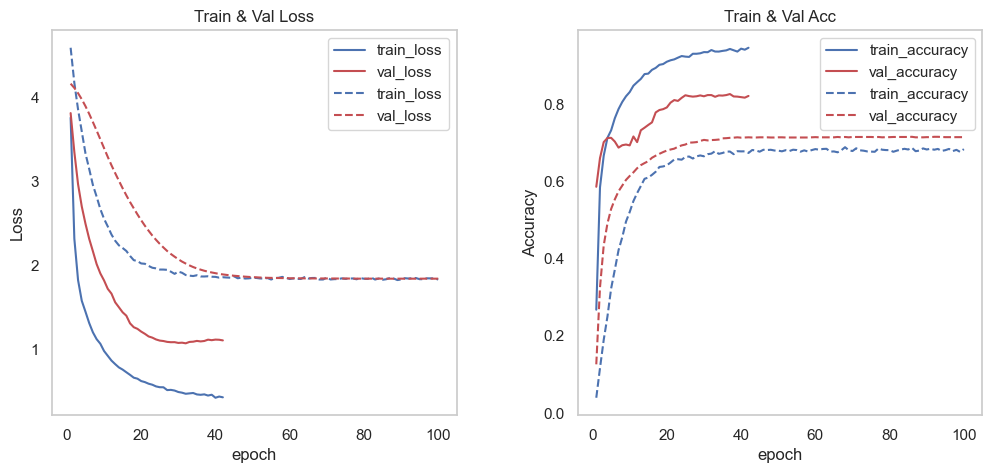

In [41]:
diff_history(history4, history6)

71/71 [==============================] - 0s 2ms/step - loss: 1.8731 - accuracy: 0.6990


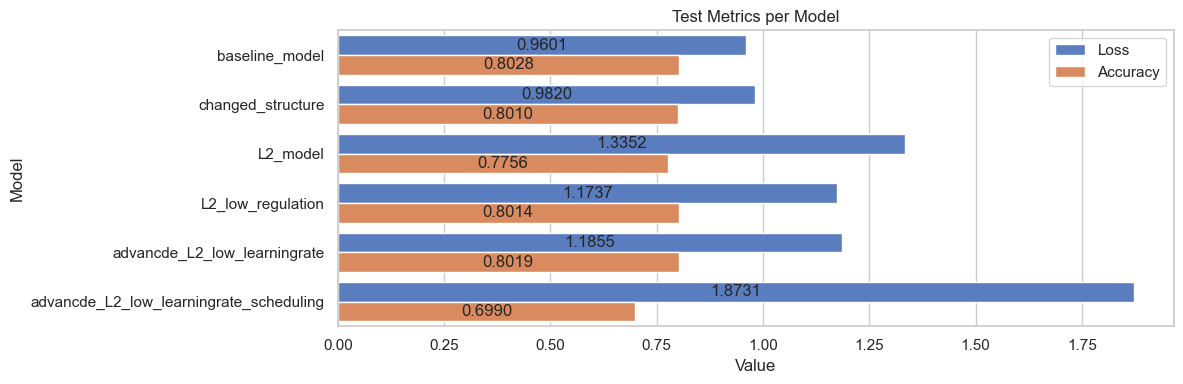

테스트 손실: 1.8731
테스트 정확도: 0.6990


In [42]:
# 가장 좋은 모델을 불러오기
best_model = load_model('advancde_L2_low_learningrate_scheduling.h5')

# 불러온 모델로 테스트 데이터를 평가
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)

# 모델 결과 저장
test_results = update_test_results('advancde_L2_low_learningrate_scheduling', test_loss, test_accuracy, test_results)

# 테스트 결과 비교
plot_test_results(test_results)

print(f'테스트 손실: {test_loss:.4f}')
print(f'테스트 정확도: {test_accuracy:.4f}')

- 전반적으로 베이스 모델에서 구조를 바꾼 버전까지는 성능 향상이 이뤄졌지만, 이후 해당 모델을 개선하기 위한 시도(L2규제, 학습률 조정) 등에서는 외려 모델 성능이 하락하는 결과를 가져왔습니다.
- 현재까지의 베스트 모델인 2번재 모델을 기반으로 베이지안 최적화를 수행헤 최적의 파라미터를 찾아보겠습니다.

### 베이지안 최적화를 활용한 최적 파라미터 튜닝

#### 베이지안 최적화를 위한 함수 생성

- 튜닝할 하이퍼 파라미터
    - 학습률, 드롭아웃비율, 은닉층 뉴런수, 배치크기, 활성화함수
    
- 베이지안 최적화를 할때 `scikit-optimize (skopt)` 를 활용하는데, 이 라이브러리는 목적함수의 값을 최소화하는 것을 목표로 합니다.
- 하지만 정확도는 더 높을수록 좋은 모델을 의미하기에, 정확도를 최대화 하기 위해서는 최적화 문제로 변환을 시켜야 합니다.
- 이를 위해 목적함수(`fitness`)에서 정확도를 음수값으로 return 합니다.

In [45]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# 모델 생성 함수
def create_model(learning_rate, dropout_rate, n_neurons):
    model = Sequential()
    l2_reg = l2(0.001)
    model.add(Dense(n_neurons, input_shape=(10000,), kernel_regularizer=l2_reg))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(n_neurons))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(46, activation='softmax'))
    model.summary()
    
    return model

# 베이지안 최적화에서 조절할 하이퍼파라미터의 범위
dimensions = [
    Real(1e-5, 1e-1, "log-uniform", name='learning_rate'),
    Real(0.05, 0.95, name='dropout_rate'),
    Integer(32, 512, name='n_neurons'),
]


# 최고의 정확도를 저장할 변수 초기화
best_accuracy = 0.0
# 최적의 모델을 저장할 경로 설정
best_model_path = "best_model_basic_baysian.h5"


# ModelCheckpoint 콜백 설정
model_checkpoint = ModelCheckpoint(
    filepath='best_model_basic_baysian.h5',  # 모델 파일 경로
    save_best_only=True,                     # 가장 좋은 모델만 저장
    monitor='val_loss',                      # 검증 손실을 기준으로 최적 모델 결정
    verbose=1                                # 정보 출력
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 모니터링
    patience=5,          # 5 에포크 동안 개선이 없으면 종료
    verbose=1,           # 로그 출력
    restore_best_weights=True  # 종료 시 최적 가중치로 복원
)

# 베이지안 최적화의 목적 함수
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, dropout_rate, n_neurons):
    # 모델 생성 함수를 호출하여 학습할 모델을 생성
    model = create_model(learning_rate, dropout_rate, n_neurons)
    
    # 모델 컴파일 단계: 옵티마이저, 손실 함수, 평가 지표를 설정
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # fitness 함수 내에서 ModelCheckpoint와 EarlyStopping을 callbacks에 추가
    history = model.fit(
        x_train,  # 학습 데이터
        y_train,  # 학습 데이터의 레이블
        epochs=100,  # 에포크 횟수
        batch_size=512,  # 배치 크기
        validation_data=(x_val, y_val),  # 검증 데이터
        callbacks=[model_checkpoint, early_stopping],  # 콜백 함수 추가
        verbose=2  # 학습 진행 상황 출력
    )

    # 모델을 테스트 데이터로 평가하고 정확도를 계산
    score = model.evaluate(x_test, y_test)
    accuracy = score[1]  # 정확도는 두 번째 요소에 저장

    # 목적 함수는 정확도의 음수값을 반환 (최적화 목표를 위해)
    return -accuracy

#### 최적화 수행

In [46]:
# 베이지안 최적화 실행
search_result = gp_minimize(func=fitness,                  # 최적화할 함수
                     dimensions=dimensions,         # 하이퍼파라미터 범위
                     acq_func='EI',                 # 탐색 전략
                     n_calls=50,                    # 반복 횟수
                     x0=[1e-4, 0.5, 128])           # 초기 추정치

print("최적의 하이퍼파라미터: {}".format(search_result.x))
print("최고 정확도: {:.2f}%".format(-100 * search_result.fun))

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (None, 128)               1280128   
_________________________________________________________________
batch_normalization_98 (Batc (None, 128)               512       
_________________________________________________________________
activation_98 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_97 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_148 (Dense)            (None, 128)               16512     
_________________________________________________________________
batch_normalization_99 (Batc (None, 128)               512       
_________________________________________________________________
activation_99 (Activation)   (None, 128)             


Epoch 00034: val_loss improved from 1.55214 to 1.52517, saving model to best_model_basic_baysian.h5
Epoch 35/100
14/14 - 0s - loss: 1.2612 - accuracy: 0.7641 - val_loss: 1.5039 - val_accuracy: 0.7542

Epoch 00035: val_loss improved from 1.52517 to 1.50387, saving model to best_model_basic_baysian.h5
Epoch 36/100
14/14 - 0s - loss: 1.2458 - accuracy: 0.7619 - val_loss: 1.4849 - val_accuracy: 0.7556

Epoch 00036: val_loss improved from 1.50387 to 1.48493, saving model to best_model_basic_baysian.h5
Epoch 37/100
14/14 - 0s - loss: 1.2234 - accuracy: 0.7699 - val_loss: 1.4652 - val_accuracy: 0.7556

Epoch 00037: val_loss improved from 1.48493 to 1.46520, saving model to best_model_basic_baysian.h5
Epoch 38/100
14/14 - 0s - loss: 1.2049 - accuracy: 0.7772 - val_loss: 1.4458 - val_accuracy: 0.7596

Epoch 00038: val_loss improved from 1.46520 to 1.44580, saving model to best_model_basic_baysian.h5
Epoch 39/100
14/14 - 0s - loss: 1.1810 - accuracy: 0.7761 - val_loss: 1.4282 - val_accuracy: 0.


Epoch 00075: val_loss improved from 1.19411 to 1.19004, saving model to best_model_basic_baysian.h5
Epoch 76/100
14/14 - 0s - loss: 0.7392 - accuracy: 0.8651 - val_loss: 1.1869 - val_accuracy: 0.7996

Epoch 00076: val_loss improved from 1.19004 to 1.18691, saving model to best_model_basic_baysian.h5
Epoch 77/100
14/14 - 0s - loss: 0.7428 - accuracy: 0.8648 - val_loss: 1.1826 - val_accuracy: 0.8001

Epoch 00077: val_loss improved from 1.18691 to 1.18264, saving model to best_model_basic_baysian.h5
Epoch 78/100
14/14 - 0s - loss: 0.7267 - accuracy: 0.8673 - val_loss: 1.1810 - val_accuracy: 0.8010

Epoch 00078: val_loss improved from 1.18264 to 1.18097, saving model to best_model_basic_baysian.h5
Epoch 79/100
14/14 - 0s - loss: 0.7208 - accuracy: 0.8688 - val_loss: 1.1797 - val_accuracy: 0.8005

Epoch 00079: val_loss improved from 1.18097 to 1.17973, saving model to best_model_basic_baysian.h5
Epoch 80/100
14/14 - 0s - loss: 0.7223 - accuracy: 0.8674 - val_loss: 1.1786 - val_accuracy: 0.

Epoch 1/100
14/14 - 1s - loss: 3.3806 - accuracy: 0.4045 - val_loss: 4.0647 - val_accuracy: 0.6215

Epoch 00001: val_loss did not improve from 1.13791
Epoch 2/100
14/14 - 0s - loss: 1.9307 - accuracy: 0.6969 - val_loss: 3.7108 - val_accuracy: 0.6950

Epoch 00002: val_loss did not improve from 1.13791
Epoch 3/100
14/14 - 0s - loss: 1.5088 - accuracy: 0.7792 - val_loss: 3.4597 - val_accuracy: 0.7097

Epoch 00003: val_loss did not improve from 1.13791
Epoch 4/100
14/14 - 0s - loss: 1.2433 - accuracy: 0.8319 - val_loss: 3.2381 - val_accuracy: 0.7044

Epoch 00004: val_loss did not improve from 1.13791
Epoch 5/100
14/14 - 0s - loss: 1.0540 - accuracy: 0.8821 - val_loss: 3.0297 - val_accuracy: 0.6803

Epoch 00005: val_loss did not improve from 1.13791
Epoch 6/100
14/14 - 0s - loss: 0.9157 - accuracy: 0.9121 - val_loss: 2.8415 - val_accuracy: 0.6465

Epoch 00006: val_loss did not improve from 1.13791
Epoch 7/100
14/14 - 0s - loss: 0.8094 - accuracy: 0.9317 - val_loss: 2.6571 - val_accuracy: 0.


Epoch 00002: val_loss did not improve from 1.04241
Epoch 3/100
14/14 - 0s - loss: 2.3262 - accuracy: 0.8428 - val_loss: 2.3108 - val_accuracy: 0.7694

Epoch 00003: val_loss did not improve from 1.04241
Epoch 4/100
14/14 - 0s - loss: 1.6793 - accuracy: 0.8717 - val_loss: 2.1898 - val_accuracy: 0.7801

Epoch 00004: val_loss did not improve from 1.04241
Epoch 5/100
14/14 - 0s - loss: 1.7518 - accuracy: 0.8830 - val_loss: 2.3628 - val_accuracy: 0.7930

Epoch 00005: val_loss did not improve from 1.04241
Epoch 6/100
14/14 - 0s - loss: 1.9897 - accuracy: 0.8826 - val_loss: 2.5607 - val_accuracy: 0.7916

Epoch 00006: val_loss did not improve from 1.04241
Epoch 7/100
14/14 - 0s - loss: 2.1127 - accuracy: 0.8870 - val_loss: 2.6379 - val_accuracy: 0.7988

Epoch 00007: val_loss did not improve from 1.04241
Epoch 8/100
14/14 - 0s - loss: 2.2119 - accuracy: 0.8818 - val_loss: 2.8441 - val_accuracy: 0.7649

Epoch 00008: val_loss did not improve from 1.04241
Epoch 9/100
14/14 - 0s - loss: 2.2283 - ac

14/14 - 0s - loss: 0.2385 - accuracy: 0.9690 - val_loss: 1.2469 - val_accuracy: 0.6946

Epoch 00013: val_loss did not improve from 1.04241
Epoch 14/100
14/14 - 0s - loss: 0.2272 - accuracy: 0.9676 - val_loss: 1.2860 - val_accuracy: 0.6692

Epoch 00014: val_loss did not improve from 1.04241
Epoch 15/100
14/14 - 0s - loss: 0.2214 - accuracy: 0.9669 - val_loss: 1.2215 - val_accuracy: 0.6990

Epoch 00015: val_loss did not improve from 1.04241
Epoch 16/100
14/14 - 0s - loss: 0.2174 - accuracy: 0.9670 - val_loss: 1.1364 - val_accuracy: 0.7364

Epoch 00016: val_loss did not improve from 1.04241
Epoch 17/100
14/14 - 0s - loss: 0.2054 - accuracy: 0.9662 - val_loss: 1.1032 - val_accuracy: 0.7516

Epoch 00017: val_loss did not improve from 1.04241
Epoch 18/100
14/14 - 0s - loss: 0.2040 - accuracy: 0.9675 - val_loss: 1.1310 - val_accuracy: 0.7431

Epoch 00018: val_loss did not improve from 1.04241
Epoch 19/100
14/14 - 0s - loss: 0.2038 - accuracy: 0.9675 - val_loss: 1.0790 - val_accuracy: 0.7685



14/14 - 0s - loss: 0.1636 - accuracy: 0.9673 - val_loss: 1.0089 - val_accuracy: 0.7916

Epoch 00026: val_loss did not improve from 0.99104
Epoch 27/100
14/14 - 0s - loss: 0.1642 - accuracy: 0.9667 - val_loss: 0.9836 - val_accuracy: 0.7983

Epoch 00027: val_loss improved from 0.99104 to 0.98364, saving model to best_model_basic_baysian.h5
Epoch 28/100
14/14 - 0s - loss: 0.1693 - accuracy: 0.9669 - val_loss: 1.0039 - val_accuracy: 0.7925

Epoch 00028: val_loss did not improve from 0.98364
Epoch 29/100
14/14 - 0s - loss: 0.1762 - accuracy: 0.9669 - val_loss: 1.0301 - val_accuracy: 0.8019

Epoch 00029: val_loss did not improve from 0.98364
Epoch 30/100
14/14 - 0s - loss: 0.1690 - accuracy: 0.9672 - val_loss: 1.0312 - val_accuracy: 0.7939

Epoch 00030: val_loss did not improve from 0.98364
Epoch 31/100
14/14 - 0s - loss: 0.1697 - accuracy: 0.9669 - val_loss: 1.0156 - val_accuracy: 0.7961

Epoch 00031: val_loss did not improve from 0.98364
Epoch 32/100
14/14 - 0s - loss: 0.1591 - accuracy: 0

Epoch 1/100
14/14 - 1s - loss: 3.5690 - accuracy: 0.4308 - val_loss: 3.5159 - val_accuracy: 0.6340

Epoch 00001: val_loss did not improve from 0.98364
Epoch 2/100
14/14 - 0s - loss: 2.0981 - accuracy: 0.6829 - val_loss: 2.9682 - val_accuracy: 0.7199

Epoch 00002: val_loss did not improve from 0.98364
Epoch 3/100
14/14 - 0s - loss: 1.7908 - accuracy: 0.7409 - val_loss: 2.6802 - val_accuracy: 0.7320

Epoch 00003: val_loss did not improve from 0.98364
Epoch 4/100
14/14 - 0s - loss: 1.5537 - accuracy: 0.7840 - val_loss: 2.5137 - val_accuracy: 0.7164

Epoch 00004: val_loss did not improve from 0.98364
Epoch 5/100
14/14 - 0s - loss: 1.3908 - accuracy: 0.8195 - val_loss: 2.3596 - val_accuracy: 0.7289

Epoch 00005: val_loss did not improve from 0.98364
Epoch 6/100
14/14 - 0s - loss: 1.2039 - accuracy: 0.8567 - val_loss: 2.2185 - val_accuracy: 0.7333

Epoch 00006: val_loss did not improve from 0.98364
Epoch 7/100
14/14 - 0s - loss: 1.1036 - accuracy: 0.8686 - val_loss: 2.0709 - val_accuracy: 0.

14/14 - 0s - loss: 1.2600 - accuracy: 0.7586 - val_loss: 1.9167 - val_accuracy: 0.7293

Epoch 00017: val_loss did not improve from 0.98364
Epoch 18/100
14/14 - 0s - loss: 1.2186 - accuracy: 0.7605 - val_loss: 1.8425 - val_accuracy: 0.7324

Epoch 00018: val_loss did not improve from 0.98364
Epoch 19/100
14/14 - 0s - loss: 1.1942 - accuracy: 0.7677 - val_loss: 1.7622 - val_accuracy: 0.7302

Epoch 00019: val_loss did not improve from 0.98364
Epoch 20/100
14/14 - 0s - loss: 1.1424 - accuracy: 0.7718 - val_loss: 1.6850 - val_accuracy: 0.7360

Epoch 00020: val_loss did not improve from 0.98364
Epoch 21/100
14/14 - 0s - loss: 1.1228 - accuracy: 0.7794 - val_loss: 1.6122 - val_accuracy: 0.7427

Epoch 00021: val_loss did not improve from 0.98364
Epoch 22/100
14/14 - 0s - loss: 1.0865 - accuracy: 0.7791 - val_loss: 1.5571 - val_accuracy: 0.7435

Epoch 00022: val_loss did not improve from 0.98364
Epoch 23/100
14/14 - 0s - loss: 1.0484 - accuracy: 0.7890 - val_loss: 1.5090 - val_accuracy: 0.7524



14/14 - 0s - loss: 0.5282 - accuracy: 0.8808 - val_loss: 1.0523 - val_accuracy: 0.7983

Epoch 00071: val_loss did not improve from 0.98364
Epoch 72/100
14/14 - 0s - loss: 0.5155 - accuracy: 0.8875 - val_loss: 1.0504 - val_accuracy: 0.8028

Epoch 00072: val_loss did not improve from 0.98364
Epoch 73/100
14/14 - 0s - loss: 0.5218 - accuracy: 0.8869 - val_loss: 1.0500 - val_accuracy: 0.8010

Epoch 00073: val_loss did not improve from 0.98364
Epoch 74/100
14/14 - 0s - loss: 0.5287 - accuracy: 0.8830 - val_loss: 1.0461 - val_accuracy: 0.8019

Epoch 00074: val_loss did not improve from 0.98364
Epoch 75/100
14/14 - 0s - loss: 0.5225 - accuracy: 0.8857 - val_loss: 1.0418 - val_accuracy: 0.8050

Epoch 00075: val_loss did not improve from 0.98364
Epoch 76/100
14/14 - 0s - loss: 0.5101 - accuracy: 0.8857 - val_loss: 1.0507 - val_accuracy: 0.8019

Epoch 00076: val_loss did not improve from 0.98364
Epoch 77/100
14/14 - 0s - loss: 0.4993 - accuracy: 0.8875 - val_loss: 1.0452 - val_accuracy: 0.8023



14/14 - 0s - loss: 2.2901 - accuracy: 0.6339 - val_loss: 2.2622 - val_accuracy: 0.7075

Epoch 00028: val_loss did not improve from 0.98364
Epoch 29/100
14/14 - 0s - loss: 2.2683 - accuracy: 0.6443 - val_loss: 2.2246 - val_accuracy: 0.7093

Epoch 00029: val_loss did not improve from 0.98364
Epoch 30/100
14/14 - 0s - loss: 2.2217 - accuracy: 0.6514 - val_loss: 2.1908 - val_accuracy: 0.7173

Epoch 00030: val_loss did not improve from 0.98364
Epoch 31/100
14/14 - 0s - loss: 2.2257 - accuracy: 0.6514 - val_loss: 2.1596 - val_accuracy: 0.7204

Epoch 00031: val_loss did not improve from 0.98364
Epoch 32/100
14/14 - 0s - loss: 2.1570 - accuracy: 0.6615 - val_loss: 2.1302 - val_accuracy: 0.7222

Epoch 00032: val_loss did not improve from 0.98364
Epoch 33/100
14/14 - 0s - loss: 2.1642 - accuracy: 0.6591 - val_loss: 2.1045 - val_accuracy: 0.7248

Epoch 00033: val_loss did not improve from 0.98364
Epoch 34/100
14/14 - 0s - loss: 2.1451 - accuracy: 0.6629 - val_loss: 2.0800 - val_accuracy: 0.7284



14/14 - 0s - loss: 1.3975 - accuracy: 0.8000 - val_loss: 1.6535 - val_accuracy: 0.7867

Epoch 00082: val_loss did not improve from 0.98364
Epoch 83/100
14/14 - 0s - loss: 1.3885 - accuracy: 0.8027 - val_loss: 1.6485 - val_accuracy: 0.7863

Epoch 00083: val_loss did not improve from 0.98364
Epoch 84/100
14/14 - 0s - loss: 1.3625 - accuracy: 0.8089 - val_loss: 1.6433 - val_accuracy: 0.7885

Epoch 00084: val_loss did not improve from 0.98364
Epoch 85/100
14/14 - 0s - loss: 1.3569 - accuracy: 0.8098 - val_loss: 1.6383 - val_accuracy: 0.7894

Epoch 00085: val_loss did not improve from 0.98364
Epoch 86/100
14/14 - 0s - loss: 1.3600 - accuracy: 0.8067 - val_loss: 1.6351 - val_accuracy: 0.7903

Epoch 00086: val_loss did not improve from 0.98364
Epoch 87/100
14/14 - 0s - loss: 1.3446 - accuracy: 0.8124 - val_loss: 1.6317 - val_accuracy: 0.7890

Epoch 00087: val_loss did not improve from 0.98364
Epoch 88/100
14/14 - 0s - loss: 1.3239 - accuracy: 0.8162 - val_loss: 1.6259 - val_accuracy: 0.7912




Epoch 00025: val_loss did not improve from 0.98364
Epoch 26/100
14/14 - 0s - loss: 5.8790 - accuracy: 0.2197 - val_loss: 3.7117 - val_accuracy: 0.4497

Epoch 00026: val_loss did not improve from 0.98364
Epoch 27/100
14/14 - 0s - loss: 5.8289 - accuracy: 0.2306 - val_loss: 3.6748 - val_accuracy: 0.4506

Epoch 00027: val_loss did not improve from 0.98364
Epoch 28/100
14/14 - 0s - loss: 5.8396 - accuracy: 0.2257 - val_loss: 3.6378 - val_accuracy: 0.4510

Epoch 00028: val_loss did not improve from 0.98364
Epoch 29/100
14/14 - 0s - loss: 5.6866 - accuracy: 0.2433 - val_loss: 3.5998 - val_accuracy: 0.4519

Epoch 00029: val_loss did not improve from 0.98364
Epoch 30/100
14/14 - 0s - loss: 5.5844 - accuracy: 0.2507 - val_loss: 3.5638 - val_accuracy: 0.4519

Epoch 00030: val_loss did not improve from 0.98364
Epoch 31/100
14/14 - 0s - loss: 5.5064 - accuracy: 0.2585 - val_loss: 3.5278 - val_accuracy: 0.4519

Epoch 00031: val_loss did not improve from 0.98364
Epoch 32/100
14/14 - 0s - loss: 5.52


Epoch 00079: val_loss did not improve from 0.98364
Epoch 80/100
14/14 - 0s - loss: 3.9751 - accuracy: 0.3722 - val_loss: 2.7962 - val_accuracy: 0.5013

Epoch 00080: val_loss did not improve from 0.98364
Epoch 81/100
14/14 - 0s - loss: 3.9280 - accuracy: 0.3749 - val_loss: 2.7911 - val_accuracy: 0.5045

Epoch 00081: val_loss did not improve from 0.98364
Epoch 82/100
14/14 - 0s - loss: 3.8957 - accuracy: 0.3778 - val_loss: 2.7856 - val_accuracy: 0.5062

Epoch 00082: val_loss did not improve from 0.98364
Epoch 83/100
14/14 - 0s - loss: 3.9184 - accuracy: 0.3667 - val_loss: 2.7798 - val_accuracy: 0.5080

Epoch 00083: val_loss did not improve from 0.98364
Epoch 84/100
14/14 - 0s - loss: 3.8381 - accuracy: 0.3787 - val_loss: 2.7741 - val_accuracy: 0.5102

Epoch 00084: val_loss did not improve from 0.98364
Epoch 85/100
14/14 - 0s - loss: 3.9799 - accuracy: 0.3725 - val_loss: 2.7694 - val_accuracy: 0.5116

Epoch 00085: val_loss did not improve from 0.98364
Epoch 86/100
14/14 - 0s - loss: 3.84

14/14 - 0s - loss: 2.2266 - accuracy: 0.6663 - val_loss: 2.8350 - val_accuracy: 0.5939

Epoch 00023: val_loss did not improve from 0.98364
Epoch 24/100
14/14 - 0s - loss: 2.1920 - accuracy: 0.6732 - val_loss: 2.7704 - val_accuracy: 0.5988

Epoch 00024: val_loss did not improve from 0.98364
Epoch 25/100
14/14 - 0s - loss: 2.1493 - accuracy: 0.6839 - val_loss: 2.7043 - val_accuracy: 0.6055

Epoch 00025: val_loss did not improve from 0.98364
Epoch 26/100
14/14 - 0s - loss: 2.1212 - accuracy: 0.6908 - val_loss: 2.6447 - val_accuracy: 0.6109

Epoch 00026: val_loss did not improve from 0.98364
Epoch 27/100
14/14 - 0s - loss: 2.0822 - accuracy: 0.7046 - val_loss: 2.5865 - val_accuracy: 0.6149

Epoch 00027: val_loss did not improve from 0.98364
Epoch 28/100
14/14 - 0s - loss: 2.0503 - accuracy: 0.7115 - val_loss: 2.5336 - val_accuracy: 0.6229

Epoch 00028: val_loss did not improve from 0.98364
Epoch 29/100
14/14 - 0s - loss: 2.0187 - accuracy: 0.7208 - val_loss: 2.4838 - val_accuracy: 0.6296



14/14 - 0s - loss: 0.9833 - accuracy: 0.8746 - val_loss: 1.5922 - val_accuracy: 0.7333

Epoch 00077: val_loss did not improve from 0.98364
Epoch 78/100
14/14 - 0s - loss: 0.9750 - accuracy: 0.8738 - val_loss: 1.5793 - val_accuracy: 0.7342

Epoch 00078: val_loss did not improve from 0.98364
Epoch 79/100
14/14 - 0s - loss: 0.9644 - accuracy: 0.8732 - val_loss: 1.5716 - val_accuracy: 0.7333

Epoch 00079: val_loss did not improve from 0.98364
Epoch 80/100
14/14 - 0s - loss: 0.9484 - accuracy: 0.8790 - val_loss: 1.5648 - val_accuracy: 0.7342

Epoch 00080: val_loss did not improve from 0.98364
Epoch 81/100
14/14 - 0s - loss: 0.9362 - accuracy: 0.8783 - val_loss: 1.5575 - val_accuracy: 0.7355

Epoch 00081: val_loss did not improve from 0.98364
Epoch 82/100
14/14 - 0s - loss: 0.9209 - accuracy: 0.8814 - val_loss: 1.5471 - val_accuracy: 0.7378

Epoch 00082: val_loss did not improve from 0.98364
Epoch 83/100
14/14 - 0s - loss: 0.9130 - accuracy: 0.8817 - val_loss: 1.5468 - val_accuracy: 0.7360




Epoch 00020: val_loss did not improve from 0.98364
Epoch 21/100
14/14 - 0s - loss: 3.4311 - accuracy: 0.1568 - val_loss: 3.5025 - val_accuracy: 0.4889

Epoch 00021: val_loss did not improve from 0.98364
Epoch 22/100
14/14 - 0s - loss: 3.4122 - accuracy: 0.1572 - val_loss: 3.4596 - val_accuracy: 0.5009

Epoch 00022: val_loss did not improve from 0.98364
Epoch 23/100
14/14 - 0s - loss: 3.3754 - accuracy: 0.1695 - val_loss: 3.4170 - val_accuracy: 0.5111

Epoch 00023: val_loss did not improve from 0.98364
Epoch 24/100
14/14 - 0s - loss: 3.3391 - accuracy: 0.1774 - val_loss: 3.3722 - val_accuracy: 0.5254

Epoch 00024: val_loss did not improve from 0.98364
Epoch 25/100
14/14 - 0s - loss: 3.2948 - accuracy: 0.1980 - val_loss: 3.3260 - val_accuracy: 0.5383

Epoch 00025: val_loss did not improve from 0.98364
Epoch 26/100
14/14 - 0s - loss: 3.2759 - accuracy: 0.2069 - val_loss: 3.2804 - val_accuracy: 0.5472

Epoch 00026: val_loss did not improve from 0.98364
Epoch 27/100
14/14 - 0s - loss: 3.24


Epoch 00074: val_loss did not improve from 0.98364
Epoch 75/100
14/14 - 0s - loss: 2.2529 - accuracy: 0.5496 - val_loss: 2.1105 - val_accuracy: 0.6794

Epoch 00075: val_loss did not improve from 0.98364
Epoch 76/100
14/14 - 0s - loss: 2.2537 - accuracy: 0.5511 - val_loss: 2.0979 - val_accuracy: 0.6817

Epoch 00076: val_loss did not improve from 0.98364
Epoch 77/100
14/14 - 0s - loss: 2.2377 - accuracy: 0.5505 - val_loss: 2.0848 - val_accuracy: 0.6812

Epoch 00077: val_loss did not improve from 0.98364
Epoch 78/100
14/14 - 0s - loss: 2.2101 - accuracy: 0.5616 - val_loss: 2.0715 - val_accuracy: 0.6830

Epoch 00078: val_loss did not improve from 0.98364
Epoch 79/100
14/14 - 0s - loss: 2.2020 - accuracy: 0.5618 - val_loss: 2.0595 - val_accuracy: 0.6857

Epoch 00079: val_loss did not improve from 0.98364
Epoch 80/100
14/14 - 0s - loss: 2.1887 - accuracy: 0.5699 - val_loss: 2.0461 - val_accuracy: 0.6866

Epoch 00080: val_loss did not improve from 0.98364
Epoch 81/100
14/14 - 0s - loss: 2.18

14/14 - 0s - loss: 4.2846 - accuracy: 0.0573 - val_loss: 3.7584 - val_accuracy: 0.1545

Epoch 00018: val_loss did not improve from 0.98364
Epoch 19/100
14/14 - 0s - loss: 4.2618 - accuracy: 0.0632 - val_loss: 3.7460 - val_accuracy: 0.1776

Epoch 00019: val_loss did not improve from 0.98364
Epoch 20/100
14/14 - 0s - loss: 4.2445 - accuracy: 0.0586 - val_loss: 3.7329 - val_accuracy: 0.2150

Epoch 00020: val_loss did not improve from 0.98364
Epoch 21/100
14/14 - 0s - loss: 4.1835 - accuracy: 0.0586 - val_loss: 3.7195 - val_accuracy: 0.2516

Epoch 00021: val_loss did not improve from 0.98364
Epoch 22/100
14/14 - 0s - loss: 4.2370 - accuracy: 0.0646 - val_loss: 3.7055 - val_accuracy: 0.2934

Epoch 00022: val_loss did not improve from 0.98364
Epoch 23/100
14/14 - 0s - loss: 4.1841 - accuracy: 0.0687 - val_loss: 3.6908 - val_accuracy: 0.3313

Epoch 00023: val_loss did not improve from 0.98364
Epoch 24/100
14/14 - 0s - loss: 4.1787 - accuracy: 0.0675 - val_loss: 3.6741 - val_accuracy: 0.3606




Epoch 00072: val_loss did not improve from 0.98364
Epoch 73/100
14/14 - 0s - loss: 3.4938 - accuracy: 0.1793 - val_loss: 3.0657 - val_accuracy: 0.5859

Epoch 00073: val_loss did not improve from 0.98364
Epoch 74/100
14/14 - 0s - loss: 3.4338 - accuracy: 0.1921 - val_loss: 3.0566 - val_accuracy: 0.5864

Epoch 00074: val_loss did not improve from 0.98364
Epoch 75/100
14/14 - 0s - loss: 3.4494 - accuracy: 0.1810 - val_loss: 3.0477 - val_accuracy: 0.5873

Epoch 00075: val_loss did not improve from 0.98364
Epoch 76/100
14/14 - 0s - loss: 3.4630 - accuracy: 0.1884 - val_loss: 3.0377 - val_accuracy: 0.5886

Epoch 00076: val_loss did not improve from 0.98364
Epoch 77/100
14/14 - 0s - loss: 3.4632 - accuracy: 0.1822 - val_loss: 3.0297 - val_accuracy: 0.5904

Epoch 00077: val_loss did not improve from 0.98364
Epoch 78/100
14/14 - 0s - loss: 3.4578 - accuracy: 0.1876 - val_loss: 3.0226 - val_accuracy: 0.5908

Epoch 00078: val_loss did not improve from 0.98364
Epoch 79/100
14/14 - 0s - loss: 3.42

Epoch 1/100
14/14 - 1s - loss: 4.5407 - accuracy: 0.0312 - val_loss: 3.9662 - val_accuracy: 0.0156

Epoch 00001: val_loss did not improve from 0.98364
Epoch 2/100
14/14 - 0s - loss: 4.5274 - accuracy: 0.0344 - val_loss: 3.9629 - val_accuracy: 0.0169

Epoch 00002: val_loss did not improve from 0.98364
Epoch 3/100
14/14 - 0s - loss: 4.4982 - accuracy: 0.0338 - val_loss: 3.9585 - val_accuracy: 0.0151

Epoch 00003: val_loss did not improve from 0.98364
Epoch 4/100
14/14 - 0s - loss: 4.4640 - accuracy: 0.0405 - val_loss: 3.9532 - val_accuracy: 0.0151

Epoch 00004: val_loss did not improve from 0.98364
Epoch 5/100
14/14 - 0s - loss: 4.4225 - accuracy: 0.0401 - val_loss: 3.9477 - val_accuracy: 0.0142

Epoch 00005: val_loss did not improve from 0.98364
Epoch 6/100
14/14 - 0s - loss: 4.3890 - accuracy: 0.0451 - val_loss: 3.9426 - val_accuracy: 0.0134

Epoch 00006: val_loss did not improve from 0.98364
Epoch 7/100
14/14 - 0s - loss: 4.3886 - accuracy: 0.0407 - val_loss: 3.9371 - val_accuracy: 0.

14/14 - 0s - loss: 3.6807 - accuracy: 0.1507 - val_loss: 3.2094 - val_accuracy: 0.4608

Epoch 00055: val_loss did not improve from 0.98364
Epoch 56/100
14/14 - 0s - loss: 3.6457 - accuracy: 0.1496 - val_loss: 3.1993 - val_accuracy: 0.4639

Epoch 00056: val_loss did not improve from 0.98364
Epoch 57/100
14/14 - 0s - loss: 3.6396 - accuracy: 0.1565 - val_loss: 3.1884 - val_accuracy: 0.4671

Epoch 00057: val_loss did not improve from 0.98364
Epoch 58/100
14/14 - 0s - loss: 3.6143 - accuracy: 0.1646 - val_loss: 3.1783 - val_accuracy: 0.4724

Epoch 00058: val_loss did not improve from 0.98364
Epoch 59/100
14/14 - 0s - loss: 3.6239 - accuracy: 0.1626 - val_loss: 3.1673 - val_accuracy: 0.4742

Epoch 00059: val_loss did not improve from 0.98364
Epoch 60/100
14/14 - 0s - loss: 3.5979 - accuracy: 0.1703 - val_loss: 3.1564 - val_accuracy: 0.4760

Epoch 00060: val_loss did not improve from 0.98364
Epoch 61/100
14/14 - 0s - loss: 3.5702 - accuracy: 0.1722 - val_loss: 3.1468 - val_accuracy: 0.4768



Epoch 1/100
14/14 - 1s - loss: 4.7853 - accuracy: 0.0232 - val_loss: 4.2217 - val_accuracy: 0.0485

Epoch 00001: val_loss did not improve from 0.98364
Epoch 2/100
14/14 - 0s - loss: 4.5557 - accuracy: 0.0423 - val_loss: 4.2111 - val_accuracy: 0.0467

Epoch 00002: val_loss did not improve from 0.98364
Epoch 3/100
14/14 - 0s - loss: 4.3464 - accuracy: 0.0814 - val_loss: 4.1943 - val_accuracy: 0.0476

Epoch 00003: val_loss did not improve from 0.98364
Epoch 4/100
14/14 - 0s - loss: 4.1416 - accuracy: 0.1404 - val_loss: 4.1696 - val_accuracy: 0.0534

Epoch 00004: val_loss did not improve from 0.98364
Epoch 5/100
14/14 - 0s - loss: 3.9622 - accuracy: 0.1963 - val_loss: 4.1376 - val_accuracy: 0.0761

Epoch 00005: val_loss did not improve from 0.98364
Epoch 6/100
14/14 - 0s - loss: 3.7704 - accuracy: 0.2528 - val_loss: 4.0991 - val_accuracy: 0.1282

Epoch 00006: val_loss did not improve from 0.98364
Epoch 7/100
14/14 - 0s - loss: 3.6333 - accuracy: 0.2933 - val_loss: 4.0525 - val_accuracy: 0.

14/14 - 0s - loss: 1.3705 - accuracy: 0.7908 - val_loss: 1.6436 - val_accuracy: 0.7489

Epoch 00055: val_loss did not improve from 0.98364
Epoch 56/100
14/14 - 0s - loss: 1.3448 - accuracy: 0.7939 - val_loss: 1.6343 - val_accuracy: 0.7511

Epoch 00056: val_loss did not improve from 0.98364
Epoch 57/100
14/14 - 0s - loss: 1.3412 - accuracy: 0.7932 - val_loss: 1.6246 - val_accuracy: 0.7520

Epoch 00057: val_loss did not improve from 0.98364
Epoch 58/100
14/14 - 0s - loss: 1.3261 - accuracy: 0.7944 - val_loss: 1.6154 - val_accuracy: 0.7520

Epoch 00058: val_loss did not improve from 0.98364
Epoch 59/100
14/14 - 0s - loss: 1.3078 - accuracy: 0.8015 - val_loss: 1.6058 - val_accuracy: 0.7542

Epoch 00059: val_loss did not improve from 0.98364
Epoch 60/100
14/14 - 0s - loss: 1.2928 - accuracy: 0.8031 - val_loss: 1.5974 - val_accuracy: 0.7542

Epoch 00060: val_loss did not improve from 0.98364
Epoch 61/100
14/14 - 0s - loss: 1.2898 - accuracy: 0.8031 - val_loss: 1.5899 - val_accuracy: 0.7556



Epoch 1/100
14/14 - 1s - loss: 5.3275 - accuracy: 0.0334 - val_loss: 4.7346 - val_accuracy: 0.0997

Epoch 00001: val_loss did not improve from 0.98364
Epoch 2/100
14/14 - 0s - loss: 5.0976 - accuracy: 0.0677 - val_loss: 4.6919 - val_accuracy: 0.1995

Epoch 00002: val_loss did not improve from 0.98364
Epoch 3/100
14/14 - 0s - loss: 4.8553 - accuracy: 0.1136 - val_loss: 4.6401 - val_accuracy: 0.2498

Epoch 00003: val_loss did not improve from 0.98364
Epoch 4/100
14/14 - 0s - loss: 4.6401 - accuracy: 0.1735 - val_loss: 4.5817 - val_accuracy: 0.2947

Epoch 00004: val_loss did not improve from 0.98364
Epoch 5/100
14/14 - 0s - loss: 4.4456 - accuracy: 0.2242 - val_loss: 4.5197 - val_accuracy: 0.3232

Epoch 00005: val_loss did not improve from 0.98364
Epoch 6/100
14/14 - 0s - loss: 4.2416 - accuracy: 0.2711 - val_loss: 4.4531 - val_accuracy: 0.3508

Epoch 00006: val_loss did not improve from 0.98364
Epoch 7/100
14/14 - 0s - loss: 4.1058 - accuracy: 0.3079 - val_loss: 4.3840 - val_accuracy: 0.

14/14 - 0s - loss: 2.0193 - accuracy: 0.7233 - val_loss: 2.1197 - val_accuracy: 0.7391

Epoch 00055: val_loss did not improve from 0.98364
Epoch 56/100
14/14 - 0s - loss: 1.9871 - accuracy: 0.7279 - val_loss: 2.1097 - val_accuracy: 0.7409

Epoch 00056: val_loss did not improve from 0.98364
Epoch 57/100
14/14 - 0s - loss: 1.9793 - accuracy: 0.7316 - val_loss: 2.1007 - val_accuracy: 0.7427

Epoch 00057: val_loss did not improve from 0.98364
Epoch 58/100
14/14 - 0s - loss: 1.9750 - accuracy: 0.7294 - val_loss: 2.0921 - val_accuracy: 0.7435

Epoch 00058: val_loss did not improve from 0.98364
Epoch 59/100
14/14 - 0s - loss: 1.9507 - accuracy: 0.7326 - val_loss: 2.0832 - val_accuracy: 0.7453

Epoch 00059: val_loss did not improve from 0.98364
Epoch 60/100
14/14 - 0s - loss: 1.9472 - accuracy: 0.7374 - val_loss: 2.0755 - val_accuracy: 0.7458

Epoch 00060: val_loss did not improve from 0.98364
Epoch 61/100
14/14 - 0s - loss: 1.9278 - accuracy: 0.7412 - val_loss: 2.0686 - val_accuracy: 0.7467



Epoch 1/100
14/14 - 1s - loss: 24.1459 - accuracy: 0.5101 - val_loss: 30.4207 - val_accuracy: 0.5476

Epoch 00001: val_loss did not improve from 0.98364
Epoch 2/100
14/14 - 0s - loss: 12.4079 - accuracy: 0.6421 - val_loss: 7.8826 - val_accuracy: 0.6278

Epoch 00002: val_loss did not improve from 0.98364
Epoch 3/100
14/14 - 0s - loss: 4.7554 - accuracy: 0.6735 - val_loss: 4.1528 - val_accuracy: 0.6848

Epoch 00003: val_loss did not improve from 0.98364
Epoch 4/100
14/14 - 0s - loss: 4.4621 - accuracy: 0.7007 - val_loss: 4.7551 - val_accuracy: 0.7093

Epoch 00004: val_loss did not improve from 0.98364
Epoch 5/100
14/14 - 0s - loss: 4.7313 - accuracy: 0.7200 - val_loss: 5.0258 - val_accuracy: 0.7110

Epoch 00005: val_loss did not improve from 0.98364
Epoch 6/100
14/14 - 0s - loss: 5.2158 - accuracy: 0.7236 - val_loss: 5.3945 - val_accuracy: 0.7262

Epoch 00006: val_loss did not improve from 0.98364
Epoch 7/100
14/14 - 0s - loss: 5.7538 - accuracy: 0.7271 - val_loss: 5.7890 - val_accuracy:

Epoch 1/100
14/14 - 1s - loss: 7.1395 - accuracy: 0.5842 - val_loss: 10.7712 - val_accuracy: 0.6959

Epoch 00001: val_loss did not improve from 0.98364
Epoch 2/100
14/14 - 0s - loss: 5.7578 - accuracy: 0.7457 - val_loss: 4.7879 - val_accuracy: 0.7142

Epoch 00002: val_loss did not improve from 0.98364
Epoch 3/100
14/14 - 0s - loss: 2.7089 - accuracy: 0.7928 - val_loss: 2.5695 - val_accuracy: 0.7435

Epoch 00003: val_loss did not improve from 0.98364
Epoch 4/100
14/14 - 0s - loss: 2.0519 - accuracy: 0.8299 - val_loss: 2.6922 - val_accuracy: 0.7596

Epoch 00004: val_loss did not improve from 0.98364
Epoch 5/100
14/14 - 0s - loss: 2.3450 - accuracy: 0.8469 - val_loss: 2.8713 - val_accuracy: 0.7783

Epoch 00005: val_loss did not improve from 0.98364
Epoch 6/100
14/14 - 0s - loss: 2.4044 - accuracy: 0.8615 - val_loss: 2.9563 - val_accuracy: 0.7818

Epoch 00006: val_loss did not improve from 0.98364
Epoch 7/100
14/14 - 0s - loss: 2.6180 - accuracy: 0.8612 - val_loss: 3.2610 - val_accuracy: 0


Epoch 00015: val_loss did not improve from 0.98364
Epoch 16/100
14/14 - 0s - loss: 3.8260 - accuracy: 0.2499 - val_loss: 3.8749 - val_accuracy: 0.4221

Epoch 00016: val_loss did not improve from 0.98364
Epoch 17/100
14/14 - 0s - loss: 3.7595 - accuracy: 0.2651 - val_loss: 3.8347 - val_accuracy: 0.4350

Epoch 00017: val_loss did not improve from 0.98364
Epoch 18/100
14/14 - 0s - loss: 3.7052 - accuracy: 0.2853 - val_loss: 3.7929 - val_accuracy: 0.4479

Epoch 00018: val_loss did not improve from 0.98364
Epoch 19/100
14/14 - 0s - loss: 3.6514 - accuracy: 0.3017 - val_loss: 3.7488 - val_accuracy: 0.4586

Epoch 00019: val_loss did not improve from 0.98364
Epoch 20/100
14/14 - 0s - loss: 3.6134 - accuracy: 0.3125 - val_loss: 3.7028 - val_accuracy: 0.4715

Epoch 00020: val_loss did not improve from 0.98364
Epoch 21/100
14/14 - 0s - loss: 3.5558 - accuracy: 0.3257 - val_loss: 3.6540 - val_accuracy: 0.4826

Epoch 00021: val_loss did not improve from 0.98364
Epoch 22/100
14/14 - 0s - loss: 3.49


Epoch 00069: val_loss did not improve from 0.98364
Epoch 70/100
14/14 - 0s - loss: 2.2407 - accuracy: 0.6039 - val_loss: 2.2083 - val_accuracy: 0.6625

Epoch 00070: val_loss did not improve from 0.98364
Epoch 71/100
14/14 - 0s - loss: 2.2156 - accuracy: 0.6146 - val_loss: 2.1971 - val_accuracy: 0.6634

Epoch 00071: val_loss did not improve from 0.98364
Epoch 72/100
14/14 - 0s - loss: 2.2228 - accuracy: 0.6115 - val_loss: 2.1857 - val_accuracy: 0.6679

Epoch 00072: val_loss did not improve from 0.98364
Epoch 73/100
14/14 - 0s - loss: 2.1837 - accuracy: 0.6214 - val_loss: 2.1753 - val_accuracy: 0.6687

Epoch 00073: val_loss did not improve from 0.98364
Epoch 74/100
14/14 - 0s - loss: 2.1797 - accuracy: 0.6249 - val_loss: 2.1652 - val_accuracy: 0.6705

Epoch 00074: val_loss did not improve from 0.98364
Epoch 75/100
14/14 - 0s - loss: 2.1617 - accuracy: 0.6223 - val_loss: 2.1540 - val_accuracy: 0.6728

Epoch 00075: val_loss did not improve from 0.98364
Epoch 76/100
14/14 - 0s - loss: 2.15


Epoch 00013: val_loss did not improve from 0.98364
Epoch 14/100
14/14 - 0s - loss: 0.6700 - accuracy: 0.9676 - val_loss: 2.1505 - val_accuracy: 0.6759

Epoch 00014: val_loss did not improve from 0.98364
Epoch 15/100
14/14 - 0s - loss: 0.6423 - accuracy: 0.9676 - val_loss: 2.0362 - val_accuracy: 0.6892

Epoch 00015: val_loss did not improve from 0.98364
Epoch 16/100
14/14 - 0s - loss: 0.6148 - accuracy: 0.9696 - val_loss: 1.9425 - val_accuracy: 0.7021

Epoch 00016: val_loss did not improve from 0.98364
Epoch 17/100
14/14 - 0s - loss: 0.5950 - accuracy: 0.9697 - val_loss: 1.8529 - val_accuracy: 0.7182

Epoch 00017: val_loss did not improve from 0.98364
Epoch 18/100
14/14 - 0s - loss: 0.5710 - accuracy: 0.9693 - val_loss: 1.7655 - val_accuracy: 0.7275

Epoch 00018: val_loss did not improve from 0.98364
Epoch 19/100
14/14 - 0s - loss: 0.5545 - accuracy: 0.9688 - val_loss: 1.6911 - val_accuracy: 0.7400

Epoch 00019: val_loss did not improve from 0.98364
Epoch 20/100
14/14 - 0s - loss: 0.53


Epoch 00067: val_loss did not improve from 0.98364
Epoch 68/100
14/14 - 0s - loss: 0.1805 - accuracy: 0.9715 - val_loss: 1.1345 - val_accuracy: 0.8059

Epoch 00068: val_loss did not improve from 0.98364
Epoch 69/100
14/14 - 0s - loss: 0.1807 - accuracy: 0.9696 - val_loss: 1.1226 - val_accuracy: 0.8059

Epoch 00069: val_loss did not improve from 0.98364
Epoch 70/100
14/14 - 0s - loss: 0.1757 - accuracy: 0.9715 - val_loss: 1.1362 - val_accuracy: 0.8041

Epoch 00070: val_loss did not improve from 0.98364
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
71/71 [==============================] - 0s 1ms/step - loss: 1.1957 - accuracy: 0.7961
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_225 (Dense)            (None, 447)               4470447   
_________________________________________________________________
batch_normalization_150 (Bat (None


Epoch 00021: val_loss did not improve from 0.98364
Epoch 22/100
14/14 - 0s - loss: 0.5565 - accuracy: 0.9593 - val_loss: 1.2801 - val_accuracy: 0.8170

Epoch 00022: val_loss did not improve from 0.98364
Epoch 23/100
14/14 - 0s - loss: 0.5414 - accuracy: 0.9584 - val_loss: 1.2467 - val_accuracy: 0.8192

Epoch 00023: val_loss did not improve from 0.98364
Epoch 24/100
14/14 - 0s - loss: 0.5243 - accuracy: 0.9593 - val_loss: 1.2246 - val_accuracy: 0.8192

Epoch 00024: val_loss did not improve from 0.98364
Epoch 25/100
14/14 - 0s - loss: 0.5110 - accuracy: 0.9602 - val_loss: 1.1974 - val_accuracy: 0.8215

Epoch 00025: val_loss did not improve from 0.98364
Epoch 26/100
14/14 - 0s - loss: 0.4959 - accuracy: 0.9608 - val_loss: 1.1749 - val_accuracy: 0.8224

Epoch 00026: val_loss did not improve from 0.98364
Epoch 27/100
14/14 - 0s - loss: 0.4849 - accuracy: 0.9627 - val_loss: 1.1645 - val_accuracy: 0.8268

Epoch 00027: val_loss did not improve from 0.98364
Epoch 28/100
14/14 - 0s - loss: 0.47


Epoch 00025: val_loss did not improve from 0.98364
Epoch 26/100
14/14 - 0s - loss: 2.8015 - accuracy: 0.5977 - val_loss: 3.1510 - val_accuracy: 0.6318

Epoch 00026: val_loss did not improve from 0.98364
Epoch 27/100
14/14 - 0s - loss: 2.7476 - accuracy: 0.6109 - val_loss: 3.0850 - val_accuracy: 0.6371

Epoch 00027: val_loss did not improve from 0.98364
Epoch 28/100
14/14 - 0s - loss: 2.7234 - accuracy: 0.6075 - val_loss: 3.0231 - val_accuracy: 0.6451

Epoch 00028: val_loss did not improve from 0.98364
Epoch 29/100
14/14 - 0s - loss: 2.6584 - accuracy: 0.6296 - val_loss: 2.9648 - val_accuracy: 0.6505

Epoch 00029: val_loss did not improve from 0.98364
Epoch 30/100
14/14 - 0s - loss: 2.6399 - accuracy: 0.6274 - val_loss: 2.9097 - val_accuracy: 0.6572

Epoch 00030: val_loss did not improve from 0.98364
Epoch 31/100
14/14 - 0s - loss: 2.6070 - accuracy: 0.6338 - val_loss: 2.8593 - val_accuracy: 0.6616

Epoch 00031: val_loss did not improve from 0.98364
Epoch 32/100
14/14 - 0s - loss: 2.55


Epoch 00079: val_loss did not improve from 0.98364
Epoch 80/100
14/14 - 0s - loss: 1.6937 - accuracy: 0.8214 - val_loss: 2.0987 - val_accuracy: 0.7614

Epoch 00080: val_loss did not improve from 0.98364
Epoch 81/100
14/14 - 0s - loss: 1.6795 - accuracy: 0.8287 - val_loss: 2.0930 - val_accuracy: 0.7614

Epoch 00081: val_loss did not improve from 0.98364
Epoch 82/100
14/14 - 0s - loss: 1.6852 - accuracy: 0.8275 - val_loss: 2.0871 - val_accuracy: 0.7622

Epoch 00082: val_loss did not improve from 0.98364
Epoch 83/100
14/14 - 0s - loss: 1.6538 - accuracy: 0.8334 - val_loss: 2.0813 - val_accuracy: 0.7636

Epoch 00083: val_loss did not improve from 0.98364
Epoch 84/100
14/14 - 0s - loss: 1.6503 - accuracy: 0.8352 - val_loss: 2.0756 - val_accuracy: 0.7631

Epoch 00084: val_loss did not improve from 0.98364
Epoch 85/100
14/14 - 0s - loss: 1.6290 - accuracy: 0.8404 - val_loss: 2.0698 - val_accuracy: 0.7645

Epoch 00085: val_loss did not improve from 0.98364
Epoch 86/100
14/14 - 0s - loss: 1.63


Epoch 00004: val_loss did not improve from 0.98364
Epoch 5/100
14/14 - 0s - loss: 2.0016 - accuracy: 0.7599 - val_loss: 2.1820 - val_accuracy: 0.7645

Epoch 00005: val_loss did not improve from 0.98364
Epoch 6/100
14/14 - 0s - loss: 2.1354 - accuracy: 0.7712 - val_loss: 2.2974 - val_accuracy: 0.7631

Epoch 00006: val_loss did not improve from 0.98364
Epoch 7/100
14/14 - 0s - loss: 2.1966 - accuracy: 0.7782 - val_loss: 2.3836 - val_accuracy: 0.7667

Epoch 00007: val_loss did not improve from 0.98364
Epoch 8/100
14/14 - 0s - loss: 2.2994 - accuracy: 0.7724 - val_loss: 2.4562 - val_accuracy: 0.7734

Epoch 00008: val_loss did not improve from 0.98364
Epoch 9/100
14/14 - 0s - loss: 2.4232 - accuracy: 0.7711 - val_loss: 2.5703 - val_accuracy: 0.7743

Epoch 00009: val_loss did not improve from 0.98364
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
71/71 [==============================] - 0s 1ms/step - loss: 2.0953 - accuracy: 0.7435
Model: "sequential_80"


Epoch 00038: val_loss did not improve from 0.98364
Epoch 39/100
14/14 - 0s - loss: 0.2842 - accuracy: 0.9682 - val_loss: 1.0547 - val_accuracy: 0.8197

Epoch 00039: val_loss did not improve from 0.98364
Epoch 40/100
14/14 - 0s - loss: 0.2727 - accuracy: 0.9696 - val_loss: 1.0533 - val_accuracy: 0.8183

Epoch 00040: val_loss did not improve from 0.98364
Epoch 41/100
14/14 - 0s - loss: 0.2687 - accuracy: 0.9716 - val_loss: 1.0535 - val_accuracy: 0.8192

Epoch 00041: val_loss did not improve from 0.98364
Epoch 42/100
14/14 - 0s - loss: 0.2632 - accuracy: 0.9676 - val_loss: 1.0471 - val_accuracy: 0.8210

Epoch 00042: val_loss did not improve from 0.98364
Epoch 43/100
14/14 - 0s - loss: 0.2670 - accuracy: 0.9676 - val_loss: 1.0557 - val_accuracy: 0.8206

Epoch 00043: val_loss did not improve from 0.98364
Epoch 44/100
14/14 - 0s - loss: 0.2665 - accuracy: 0.9660 - val_loss: 1.0675 - val_accuracy: 0.8215

Epoch 00044: val_loss did not improve from 0.98364
Epoch 45/100
14/14 - 0s - loss: 0.25


Epoch 00034: val_loss did not improve from 0.98364
Epoch 35/100
14/14 - 0s - loss: 2.1462 - accuracy: 0.7211 - val_loss: 2.5440 - val_accuracy: 0.6670

Epoch 00035: val_loss did not improve from 0.98364
Epoch 36/100
14/14 - 0s - loss: 2.1091 - accuracy: 0.7280 - val_loss: 2.5075 - val_accuracy: 0.6710

Epoch 00036: val_loss did not improve from 0.98364
Epoch 37/100
14/14 - 0s - loss: 2.0798 - accuracy: 0.7307 - val_loss: 2.4737 - val_accuracy: 0.6750

Epoch 00037: val_loss did not improve from 0.98364
Epoch 38/100
14/14 - 0s - loss: 2.0606 - accuracy: 0.7362 - val_loss: 2.4417 - val_accuracy: 0.6790

Epoch 00038: val_loss did not improve from 0.98364
Epoch 39/100
14/14 - 0s - loss: 2.0235 - accuracy: 0.7424 - val_loss: 2.4120 - val_accuracy: 0.6812

Epoch 00039: val_loss did not improve from 0.98364
Epoch 40/100
14/14 - 0s - loss: 1.9953 - accuracy: 0.7481 - val_loss: 2.3848 - val_accuracy: 0.6852

Epoch 00040: val_loss did not improve from 0.98364
Epoch 41/100
14/14 - 0s - loss: 1.96


Epoch 00088: val_loss did not improve from 0.98364
Epoch 89/100
14/14 - 0s - loss: 1.2676 - accuracy: 0.8990 - val_loss: 1.8694 - val_accuracy: 0.7569

Epoch 00089: val_loss did not improve from 0.98364
Epoch 90/100
14/14 - 0s - loss: 1.2579 - accuracy: 0.8995 - val_loss: 1.8644 - val_accuracy: 0.7578

Epoch 00090: val_loss did not improve from 0.98364
Epoch 91/100
14/14 - 0s - loss: 1.2469 - accuracy: 0.9014 - val_loss: 1.8595 - val_accuracy: 0.7587

Epoch 00091: val_loss did not improve from 0.98364
Epoch 92/100
14/14 - 0s - loss: 1.2400 - accuracy: 0.9041 - val_loss: 1.8545 - val_accuracy: 0.7582

Epoch 00092: val_loss did not improve from 0.98364
Epoch 93/100
14/14 - 0s - loss: 1.2370 - accuracy: 0.9013 - val_loss: 1.8497 - val_accuracy: 0.7587

Epoch 00093: val_loss did not improve from 0.98364
Epoch 94/100
14/14 - 0s - loss: 1.2283 - accuracy: 0.9029 - val_loss: 1.8451 - val_accuracy: 0.7596

Epoch 00094: val_loss did not improve from 0.98364
Epoch 95/100
14/14 - 0s - loss: 1.22

14/14 - 0s - loss: 0.6267 - accuracy: 0.8692 - val_loss: 1.0554 - val_accuracy: 0.8054

Epoch 00032: val_loss did not improve from 0.98364
Epoch 33/100
14/14 - 0s - loss: 0.6174 - accuracy: 0.8753 - val_loss: 1.0694 - val_accuracy: 0.8072

Epoch 00033: val_loss did not improve from 0.98364
Epoch 34/100
14/14 - 0s - loss: 0.6201 - accuracy: 0.8765 - val_loss: 1.0544 - val_accuracy: 0.8072

Epoch 00034: val_loss did not improve from 0.98364
Epoch 35/100
14/14 - 0s - loss: 0.6003 - accuracy: 0.8765 - val_loss: 1.0542 - val_accuracy: 0.8077

Epoch 00035: val_loss did not improve from 0.98364
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
71/71 [==============================] - 0s 1ms/step - loss: 1.1306 - accuracy: 0.7774
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_249 (Dense)            (None, 254)               2540254   
_____________


Epoch 00019: val_loss did not improve from 0.98364
Epoch 20/100
14/14 - 0s - loss: 2.4641 - accuracy: 0.6265 - val_loss: 3.3015 - val_accuracy: 0.5245

Epoch 00020: val_loss did not improve from 0.98364
Epoch 21/100
14/14 - 0s - loss: 2.4099 - accuracy: 0.6349 - val_loss: 3.2245 - val_accuracy: 0.5401

Epoch 00021: val_loss did not improve from 0.98364
Epoch 22/100
14/14 - 0s - loss: 2.3566 - accuracy: 0.6505 - val_loss: 3.1476 - val_accuracy: 0.5467

Epoch 00022: val_loss did not improve from 0.98364
Epoch 23/100
14/14 - 0s - loss: 2.3053 - accuracy: 0.6606 - val_loss: 3.0726 - val_accuracy: 0.5583

Epoch 00023: val_loss did not improve from 0.98364
Epoch 24/100
14/14 - 0s - loss: 2.2583 - accuracy: 0.6737 - val_loss: 2.9999 - val_accuracy: 0.5690

Epoch 00024: val_loss did not improve from 0.98364
Epoch 25/100
14/14 - 0s - loss: 2.2084 - accuracy: 0.6832 - val_loss: 2.9309 - val_accuracy: 0.5784

Epoch 00025: val_loss did not improve from 0.98364
Epoch 26/100
14/14 - 0s - loss: 2.16


Epoch 00073: val_loss did not improve from 0.98364
Epoch 74/100
14/14 - 0s - loss: 1.1591 - accuracy: 0.9034 - val_loss: 1.8410 - val_accuracy: 0.7400

Epoch 00074: val_loss did not improve from 0.98364
Epoch 75/100
14/14 - 0s - loss: 1.1487 - accuracy: 0.9059 - val_loss: 1.8349 - val_accuracy: 0.7418

Epoch 00075: val_loss did not improve from 0.98364
Epoch 76/100
14/14 - 0s - loss: 1.1329 - accuracy: 0.9115 - val_loss: 1.8284 - val_accuracy: 0.7431

Epoch 00076: val_loss did not improve from 0.98364
Epoch 77/100
14/14 - 0s - loss: 1.1275 - accuracy: 0.9121 - val_loss: 1.8218 - val_accuracy: 0.7440

Epoch 00077: val_loss did not improve from 0.98364
Epoch 78/100
14/14 - 0s - loss: 1.1151 - accuracy: 0.9136 - val_loss: 1.8152 - val_accuracy: 0.7453

Epoch 00078: val_loss did not improve from 0.98364
Epoch 79/100
14/14 - 0s - loss: 1.1052 - accuracy: 0.9140 - val_loss: 1.8093 - val_accuracy: 0.7458

Epoch 00079: val_loss did not improve from 0.98364
Epoch 80/100
14/14 - 0s - loss: 1.09

Epoch 1/100
14/14 - 1s - loss: 4.5467 - accuracy: 0.0781 - val_loss: 4.3903 - val_accuracy: 0.1086

Epoch 00001: val_loss did not improve from 0.98364
Epoch 2/100
14/14 - 0s - loss: 4.3144 - accuracy: 0.1409 - val_loss: 4.3763 - val_accuracy: 0.1407

Epoch 00002: val_loss did not improve from 0.98364
Epoch 3/100
14/14 - 0s - loss: 4.0813 - accuracy: 0.2167 - val_loss: 4.3496 - val_accuracy: 0.1732

Epoch 00003: val_loss did not improve from 0.98364
Epoch 4/100
14/14 - 0s - loss: 3.8797 - accuracy: 0.2748 - val_loss: 4.3140 - val_accuracy: 0.2409

Epoch 00004: val_loss did not improve from 0.98364
Epoch 5/100
14/14 - 0s - loss: 3.6964 - accuracy: 0.3177 - val_loss: 4.2710 - val_accuracy: 0.2796

Epoch 00005: val_loss did not improve from 0.98364
Epoch 6/100
14/14 - 0s - loss: 3.5256 - accuracy: 0.3536 - val_loss: 4.2209 - val_accuracy: 0.3045

Epoch 00006: val_loss did not improve from 0.98364
Epoch 7/100
14/14 - 0s - loss: 3.3859 - accuracy: 0.3838 - val_loss: 4.1671 - val_accuracy: 0.

14/14 - 0s - loss: 1.4559 - accuracy: 0.7965 - val_loss: 1.7925 - val_accuracy: 0.7560

Epoch 00055: val_loss did not improve from 0.98364
Epoch 56/100
14/14 - 0s - loss: 1.4337 - accuracy: 0.8046 - val_loss: 1.7834 - val_accuracy: 0.7560

Epoch 00056: val_loss did not improve from 0.98364
Epoch 57/100
14/14 - 0s - loss: 1.4312 - accuracy: 0.8082 - val_loss: 1.7742 - val_accuracy: 0.7565

Epoch 00057: val_loss did not improve from 0.98364
Epoch 58/100
14/14 - 0s - loss: 1.4064 - accuracy: 0.8106 - val_loss: 1.7656 - val_accuracy: 0.7578

Epoch 00058: val_loss did not improve from 0.98364
Epoch 59/100
14/14 - 0s - loss: 1.4044 - accuracy: 0.8046 - val_loss: 1.7582 - val_accuracy: 0.7596

Epoch 00059: val_loss did not improve from 0.98364
Epoch 60/100
14/14 - 0s - loss: 1.3848 - accuracy: 0.8146 - val_loss: 1.7511 - val_accuracy: 0.7600

Epoch 00060: val_loss did not improve from 0.98364
Epoch 61/100
14/14 - 0s - loss: 1.3817 - accuracy: 0.8164 - val_loss: 1.7437 - val_accuracy: 0.7600



Epoch 1/100
14/14 - 1s - loss: 5.4420 - accuracy: 0.0135 - val_loss: 4.8109 - val_accuracy: 0.0151

Epoch 00001: val_loss did not improve from 0.98364
Epoch 2/100
14/14 - 0s - loss: 5.1349 - accuracy: 0.0509 - val_loss: 4.7940 - val_accuracy: 0.0191

Epoch 00002: val_loss did not improve from 0.98364
Epoch 3/100
14/14 - 0s - loss: 4.8718 - accuracy: 0.1237 - val_loss: 4.7695 - val_accuracy: 0.0276

Epoch 00003: val_loss did not improve from 0.98364
Epoch 4/100
14/14 - 0s - loss: 4.6098 - accuracy: 0.2162 - val_loss: 4.7374 - val_accuracy: 0.0485

Epoch 00004: val_loss did not improve from 0.98364
Epoch 5/100
14/14 - 0s - loss: 4.3731 - accuracy: 0.2699 - val_loss: 4.6971 - val_accuracy: 0.0988

Epoch 00005: val_loss did not improve from 0.98364
Epoch 6/100
14/14 - 0s - loss: 4.1566 - accuracy: 0.3079 - val_loss: 4.6496 - val_accuracy: 0.1661

Epoch 00006: val_loss did not improve from 0.98364
Epoch 7/100
14/14 - 0s - loss: 3.9631 - accuracy: 0.3417 - val_loss: 4.5947 - val_accuracy: 0.

14/14 - 0s - loss: 1.4937 - accuracy: 0.9068 - val_loss: 2.1995 - val_accuracy: 0.7400

Epoch 00055: val_loss did not improve from 0.98364
Epoch 56/100
14/14 - 0s - loss: 1.4797 - accuracy: 0.9090 - val_loss: 2.1903 - val_accuracy: 0.7427

Epoch 00056: val_loss did not improve from 0.98364
Epoch 57/100
14/14 - 0s - loss: 1.4629 - accuracy: 0.9114 - val_loss: 2.1813 - val_accuracy: 0.7444

Epoch 00057: val_loss did not improve from 0.98364
Epoch 58/100
14/14 - 0s - loss: 1.4548 - accuracy: 0.9142 - val_loss: 2.1719 - val_accuracy: 0.7449

Epoch 00058: val_loss did not improve from 0.98364
Epoch 59/100
14/14 - 0s - loss: 1.4374 - accuracy: 0.9166 - val_loss: 2.1631 - val_accuracy: 0.7471

Epoch 00059: val_loss did not improve from 0.98364
Epoch 60/100
14/14 - 0s - loss: 1.4233 - accuracy: 0.9210 - val_loss: 2.1545 - val_accuracy: 0.7476

Epoch 00060: val_loss did not improve from 0.98364
Epoch 61/100
14/14 - 0s - loss: 1.4110 - accuracy: 0.9195 - val_loss: 2.1463 - val_accuracy: 0.7480



Epoch 1/100
14/14 - 1s - loss: 9.2421 - accuracy: 0.2889 - val_loss: 9.1242 - val_accuracy: 0.3566

Epoch 00001: val_loss did not improve from 0.98364
Epoch 2/100
14/14 - 0s - loss: 8.0753 - accuracy: 0.3487 - val_loss: 6.7828 - val_accuracy: 0.3566

Epoch 00002: val_loss did not improve from 0.98364
Epoch 3/100
14/14 - 0s - loss: 6.0328 - accuracy: 0.3498 - val_loss: 5.1190 - val_accuracy: 0.3566

Epoch 00003: val_loss did not improve from 0.98364
Epoch 4/100
14/14 - 0s - loss: 4.6438 - accuracy: 0.3499 - val_loss: 4.0750 - val_accuracy: 0.3566

Epoch 00004: val_loss did not improve from 0.98364
Epoch 5/100
14/14 - 0s - loss: 3.8124 - accuracy: 0.3499 - val_loss: 3.5231 - val_accuracy: 0.3566

Epoch 00005: val_loss did not improve from 0.98364
Epoch 6/100
14/14 - 0s - loss: 3.3506 - accuracy: 0.3498 - val_loss: 3.1509 - val_accuracy: 0.3566

Epoch 00006: val_loss did not improve from 0.98364
Epoch 7/100
14/14 - 0s - loss: 3.0891 - accuracy: 0.3492 - val_loss: 2.9740 - val_accuracy: 0.

14/14 - 0s - loss: 5.5439 - accuracy: 0.1109 - val_loss: 4.2351 - val_accuracy: 0.4274

Epoch 00028: val_loss did not improve from 0.98364
Epoch 29/100
14/14 - 0s - loss: 5.5293 - accuracy: 0.1162 - val_loss: 4.1957 - val_accuracy: 0.4412

Epoch 00029: val_loss did not improve from 0.98364
Epoch 30/100
14/14 - 0s - loss: 5.4384 - accuracy: 0.1286 - val_loss: 4.1563 - val_accuracy: 0.4524

Epoch 00030: val_loss did not improve from 0.98364
Epoch 31/100
14/14 - 0s - loss: 5.4540 - accuracy: 0.1195 - val_loss: 4.1155 - val_accuracy: 0.4684

Epoch 00031: val_loss did not improve from 0.98364
Epoch 32/100
14/14 - 0s - loss: 5.4105 - accuracy: 0.1349 - val_loss: 4.0760 - val_accuracy: 0.4826

Epoch 00032: val_loss did not improve from 0.98364
Epoch 33/100
14/14 - 0s - loss: 5.3808 - accuracy: 0.1379 - val_loss: 4.0364 - val_accuracy: 0.4902

Epoch 00033: val_loss did not improve from 0.98364
Epoch 34/100
14/14 - 0s - loss: 5.3003 - accuracy: 0.1483 - val_loss: 3.9973 - val_accuracy: 0.5000



14/14 - 0s - loss: 3.9873 - accuracy: 0.3704 - val_loss: 3.0272 - val_accuracy: 0.6171

Epoch 00082: val_loss did not improve from 0.98364
Epoch 83/100
14/14 - 0s - loss: 3.9555 - accuracy: 0.3722 - val_loss: 3.0171 - val_accuracy: 0.6193

Epoch 00083: val_loss did not improve from 0.98364
Epoch 84/100
14/14 - 0s - loss: 3.9346 - accuracy: 0.3820 - val_loss: 3.0075 - val_accuracy: 0.6193

Epoch 00084: val_loss did not improve from 0.98364
Epoch 85/100
14/14 - 0s - loss: 3.9044 - accuracy: 0.3839 - val_loss: 2.9968 - val_accuracy: 0.6198

Epoch 00085: val_loss did not improve from 0.98364
Epoch 86/100
14/14 - 0s - loss: 3.8774 - accuracy: 0.3870 - val_loss: 2.9870 - val_accuracy: 0.6202

Epoch 00086: val_loss did not improve from 0.98364
Epoch 87/100
14/14 - 0s - loss: 3.8710 - accuracy: 0.3884 - val_loss: 2.9770 - val_accuracy: 0.6211

Epoch 00087: val_loss did not improve from 0.98364
Epoch 88/100
14/14 - 0s - loss: 3.8554 - accuracy: 0.3968 - val_loss: 2.9675 - val_accuracy: 0.6202



Epoch 1/100
14/14 - 1s - loss: 7.6789 - accuracy: 0.5484 - val_loss: 10.6381 - val_accuracy: 0.5695

Epoch 00001: val_loss did not improve from 0.98364
Epoch 2/100
14/14 - 0s - loss: 4.1866 - accuracy: 0.6735 - val_loss: 4.2688 - val_accuracy: 0.6251

Epoch 00002: val_loss did not improve from 0.98364
Epoch 3/100
14/14 - 0s - loss: 2.4641 - accuracy: 0.6952 - val_loss: 2.8149 - val_accuracy: 0.6541

Epoch 00003: val_loss did not improve from 0.98364
Epoch 4/100
14/14 - 0s - loss: 2.2318 - accuracy: 0.7118 - val_loss: 2.7984 - val_accuracy: 0.6723

Epoch 00004: val_loss did not improve from 0.98364
Epoch 5/100
14/14 - 0s - loss: 2.2668 - accuracy: 0.7280 - val_loss: 2.4659 - val_accuracy: 0.6906

Epoch 00005: val_loss did not improve from 0.98364
Epoch 6/100
14/14 - 0s - loss: 2.4998 - accuracy: 0.7352 - val_loss: 2.8958 - val_accuracy: 0.6701

Epoch 00006: val_loss did not improve from 0.98364
Epoch 7/100
14/14 - 0s - loss: 2.5364 - accuracy: 0.7377 - val_loss: 2.6202 - val_accuracy: 0


Epoch 00033: val_loss did not improve from 0.98364
Epoch 34/100
14/14 - 0s - loss: 1.2827 - accuracy: 0.9247 - val_loss: 2.0182 - val_accuracy: 0.7667

Epoch 00034: val_loss did not improve from 0.98364
Epoch 35/100
14/14 - 0s - loss: 1.2558 - accuracy: 0.9259 - val_loss: 1.9923 - val_accuracy: 0.7685

Epoch 00035: val_loss did not improve from 0.98364
Epoch 36/100
14/14 - 0s - loss: 1.2337 - accuracy: 0.9289 - val_loss: 1.9702 - val_accuracy: 0.7698

Epoch 00036: val_loss did not improve from 0.98364
Epoch 37/100
14/14 - 0s - loss: 1.2221 - accuracy: 0.9302 - val_loss: 1.9499 - val_accuracy: 0.7716

Epoch 00037: val_loss did not improve from 0.98364
Epoch 38/100
14/14 - 0s - loss: 1.2048 - accuracy: 0.9342 - val_loss: 1.9312 - val_accuracy: 0.7725

Epoch 00038: val_loss did not improve from 0.98364
Epoch 39/100
14/14 - 0s - loss: 1.1887 - accuracy: 0.9371 - val_loss: 1.9141 - val_accuracy: 0.7720

Epoch 00039: val_loss did not improve from 0.98364
Epoch 40/100
14/14 - 0s - loss: 1.16


Epoch 00087: val_loss did not improve from 0.98364
Epoch 88/100
14/14 - 0s - loss: 0.7755 - accuracy: 0.9708 - val_loss: 1.6370 - val_accuracy: 0.7916

Epoch 00088: val_loss did not improve from 0.98364
Epoch 89/100
14/14 - 0s - loss: 0.7721 - accuracy: 0.9687 - val_loss: 1.6324 - val_accuracy: 0.7921

Epoch 00089: val_loss did not improve from 0.98364
Epoch 90/100
14/14 - 0s - loss: 0.7619 - accuracy: 0.9731 - val_loss: 1.6296 - val_accuracy: 0.7925

Epoch 00090: val_loss did not improve from 0.98364
Epoch 91/100
14/14 - 0s - loss: 0.7591 - accuracy: 0.9708 - val_loss: 1.6283 - val_accuracy: 0.7921

Epoch 00091: val_loss did not improve from 0.98364
Epoch 92/100
14/14 - 0s - loss: 0.7517 - accuracy: 0.9733 - val_loss: 1.6258 - val_accuracy: 0.7916

Epoch 00092: val_loss did not improve from 0.98364
Epoch 93/100
14/14 - 0s - loss: 0.7504 - accuracy: 0.9712 - val_loss: 1.6225 - val_accuracy: 0.7930

Epoch 00093: val_loss did not improve from 0.98364
Epoch 94/100
14/14 - 0s - loss: 0.74

14/14 - 0s - loss: 0.3286 - accuracy: 0.9568 - val_loss: 1.0208 - val_accuracy: 0.8183

Epoch 00031: val_loss did not improve from 0.98364
Epoch 32/100
14/14 - 0s - loss: 0.3040 - accuracy: 0.9607 - val_loss: 1.0248 - val_accuracy: 0.8206

Epoch 00032: val_loss did not improve from 0.98364
Epoch 33/100
14/14 - 0s - loss: 0.3073 - accuracy: 0.9581 - val_loss: 1.0125 - val_accuracy: 0.8228

Epoch 00033: val_loss did not improve from 0.98364
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
71/71 [==============================] - 0s 1ms/step - loss: 1.0812 - accuracy: 0.8023
Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_282 (Dense)            (None, 512)               5120512   
_________________________________________________________________
batch_normalization_188 (Bat (None, 512)               2048      
_________________________________

14/14 - 0s - loss: 0.5210 - accuracy: 0.9690 - val_loss: 1.3416 - val_accuracy: 0.8157

Epoch 00041: val_loss did not improve from 0.98364
Epoch 42/100
14/14 - 0s - loss: 0.5119 - accuracy: 0.9699 - val_loss: 1.3388 - val_accuracy: 0.8148

Epoch 00042: val_loss did not improve from 0.98364
Epoch 43/100
14/14 - 0s - loss: 0.4960 - accuracy: 0.9691 - val_loss: 1.3339 - val_accuracy: 0.8166

Epoch 00043: val_loss did not improve from 0.98364
Epoch 44/100
14/14 - 0s - loss: 0.4891 - accuracy: 0.9721 - val_loss: 1.3336 - val_accuracy: 0.8161

Epoch 00044: val_loss did not improve from 0.98364
Epoch 45/100
14/14 - 0s - loss: 0.4849 - accuracy: 0.9678 - val_loss: 1.3281 - val_accuracy: 0.8152

Epoch 00045: val_loss did not improve from 0.98364
Epoch 46/100
14/14 - 0s - loss: 0.4675 - accuracy: 0.9712 - val_loss: 1.3239 - val_accuracy: 0.8152

Epoch 00046: val_loss did not improve from 0.98364
Epoch 47/100
14/14 - 0s - loss: 0.4634 - accuracy: 0.9734 - val_loss: 1.3194 - val_accuracy: 0.8139



14/14 - 0s - loss: 1.6430 - accuracy: 0.7717 - val_loss: 2.8994 - val_accuracy: 0.6585

Epoch 00012: val_loss did not improve from 0.98364
Epoch 13/100
14/14 - 0s - loss: 1.5707 - accuracy: 0.7916 - val_loss: 2.7820 - val_accuracy: 0.6647

Epoch 00013: val_loss did not improve from 0.98364
Epoch 14/100
14/14 - 0s - loss: 1.5179 - accuracy: 0.7980 - val_loss: 2.6745 - val_accuracy: 0.6776

Epoch 00014: val_loss did not improve from 0.98364
Epoch 15/100
14/14 - 0s - loss: 1.4473 - accuracy: 0.8164 - val_loss: 2.5709 - val_accuracy: 0.6901

Epoch 00015: val_loss did not improve from 0.98364
Epoch 16/100
14/14 - 0s - loss: 1.3924 - accuracy: 0.8195 - val_loss: 2.4737 - val_accuracy: 0.7017

Epoch 00016: val_loss did not improve from 0.98364
Epoch 17/100
14/14 - 0s - loss: 1.3550 - accuracy: 0.8334 - val_loss: 2.3825 - val_accuracy: 0.7079

Epoch 00017: val_loss did not improve from 0.98364
Epoch 18/100
14/14 - 0s - loss: 1.3065 - accuracy: 0.8395 - val_loss: 2.2937 - val_accuracy: 0.7191



14/14 - 0s - loss: 0.5158 - accuracy: 0.9706 - val_loss: 1.3543 - val_accuracy: 0.8063

Epoch 00066: val_loss did not improve from 0.98364
Epoch 67/100
14/14 - 0s - loss: 0.5119 - accuracy: 0.9703 - val_loss: 1.3492 - val_accuracy: 0.8059

Epoch 00067: val_loss did not improve from 0.98364
Epoch 68/100
14/14 - 0s - loss: 0.5090 - accuracy: 0.9696 - val_loss: 1.3448 - val_accuracy: 0.8072

Epoch 00068: val_loss did not improve from 0.98364
Epoch 69/100
14/14 - 0s - loss: 0.5089 - accuracy: 0.9690 - val_loss: 1.3438 - val_accuracy: 0.8077

Epoch 00069: val_loss did not improve from 0.98364
Epoch 70/100
14/14 - 0s - loss: 0.4947 - accuracy: 0.9702 - val_loss: 1.3421 - val_accuracy: 0.8059

Epoch 00070: val_loss did not improve from 0.98364
Epoch 71/100
14/14 - 0s - loss: 0.5018 - accuracy: 0.9676 - val_loss: 1.3409 - val_accuracy: 0.8059

Epoch 00071: val_loss did not improve from 0.98364
Epoch 72/100
14/14 - 0s - loss: 0.4853 - accuracy: 0.9685 - val_loss: 1.3346 - val_accuracy: 0.8077




Epoch 00009: val_loss did not improve from 0.98364
Epoch 10/100
14/14 - 0s - loss: 0.3823 - accuracy: 0.9659 - val_loss: 2.1548 - val_accuracy: 0.6834

Epoch 00010: val_loss did not improve from 0.98364
Epoch 11/100
14/14 - 0s - loss: 0.3609 - accuracy: 0.9669 - val_loss: 2.0181 - val_accuracy: 0.6848

Epoch 00011: val_loss did not improve from 0.98364
Epoch 12/100
14/14 - 0s - loss: 0.3384 - accuracy: 0.9670 - val_loss: 1.8775 - val_accuracy: 0.6874

Epoch 00012: val_loss did not improve from 0.98364
Epoch 13/100
14/14 - 0s - loss: 0.3170 - accuracy: 0.9711 - val_loss: 1.7675 - val_accuracy: 0.6968

Epoch 00013: val_loss did not improve from 0.98364
Epoch 14/100
14/14 - 0s - loss: 0.3026 - accuracy: 0.9699 - val_loss: 1.6648 - val_accuracy: 0.7102

Epoch 00014: val_loss did not improve from 0.98364
Epoch 15/100
14/14 - 0s - loss: 0.2878 - accuracy: 0.9685 - val_loss: 1.5661 - val_accuracy: 0.7186

Epoch 00015: val_loss did not improve from 0.98364
Epoch 16/100
14/14 - 0s - loss: 0.27


Epoch 00013: val_loss did not improve from 0.98364
Epoch 14/100
14/14 - 0s - loss: 1.1559 - accuracy: 0.8524 - val_loss: 1.9745 - val_accuracy: 0.7596

Epoch 00014: val_loss did not improve from 0.98364
Epoch 15/100
14/14 - 0s - loss: 1.1094 - accuracy: 0.8628 - val_loss: 1.8949 - val_accuracy: 0.7747

Epoch 00015: val_loss did not improve from 0.98364
Epoch 16/100
14/14 - 0s - loss: 1.0524 - accuracy: 0.8716 - val_loss: 1.8120 - val_accuracy: 0.7787

Epoch 00016: val_loss did not improve from 0.98364
Epoch 17/100
14/14 - 0s - loss: 1.0057 - accuracy: 0.8796 - val_loss: 1.7347 - val_accuracy: 0.7872

Epoch 00017: val_loss did not improve from 0.98364
Epoch 18/100
14/14 - 0s - loss: 0.9546 - accuracy: 0.8907 - val_loss: 1.6605 - val_accuracy: 0.7996

Epoch 00018: val_loss did not improve from 0.98364
Epoch 19/100
14/14 - 0s - loss: 0.9226 - accuracy: 0.8971 - val_loss: 1.5953 - val_accuracy: 0.8094

Epoch 00019: val_loss did not improve from 0.98364
Epoch 20/100
14/14 - 0s - loss: 0.89

71/71 [==============================] - 0s 1ms/step - loss: 4.7345 - accuracy: 0.3620
최적의 하이퍼파라미터: [0.0004694142800031213, 0.6720942103898104, 512]
최고 정확도: 80.90%


In [47]:
# 최적의 하이퍼파라미터 이름과 값 출력
hyperparameter_names = ['learning_rate', 'dropout_rate', 'n_neurons']
optimal_hyperparameters = dict(zip(hyperparameter_names, search_result.x))

print("최적의 하이퍼파라미터:")
for name, value in optimal_hyperparameters.items():
    print(f"{name}: {value}")

print("최고 정확도: {:.2f}%".format(-100 * search_result.fun))

최적의 하이퍼파라미터:
learning_rate: 0.0004694142800031213
dropout_rate: 0.6720942103898104
n_neurons: 512
최고 정확도: 80.90%


### 최적화 결과 확인

71/71 [==============================] - 0s 4ms/step - loss: 1.0776 - accuracy: 0.7703


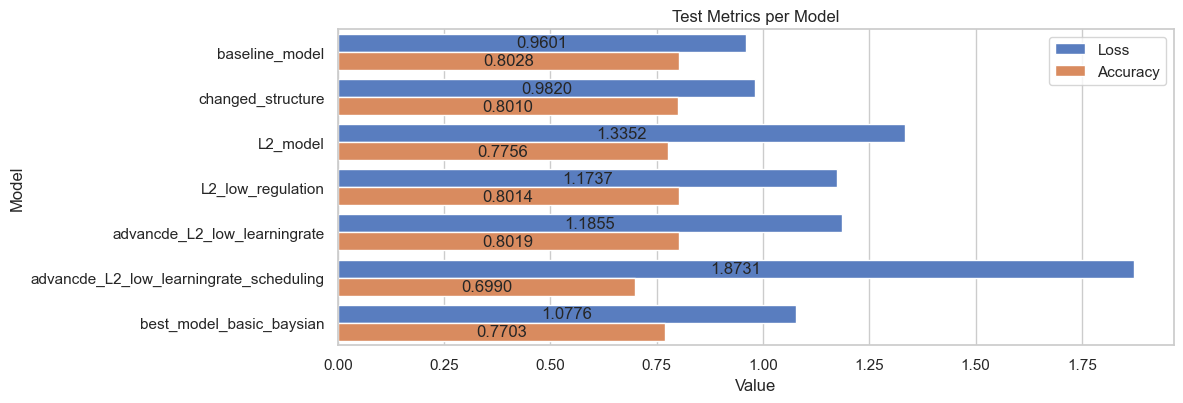

테스트 손실: 1.0776
테스트 정확도: 0.7703


In [48]:
from tensorflow.keras.models import load_model

# 저장된 최상의 모델을 불러옴
best_model = load_model('best_model_basic_baysian.h5')

# 불러온 모델로 테스트 데이터셋 평가
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)

# 모델 결과 저장
test_results = update_test_results('best_model_basic_baysian', test_loss, test_accuracy, test_results)

# 테스트 결과 비교
plot_test_results(test_results)

print(f'테스트 손실: {test_loss:.4f}')
print(f'테스트 정확도: {test_accuracy:.4f}')

- 다양한 모델의 하이퍼 파라미터를 최적화해보았지만 모델의 성능이 드라마틱하게 향상되지는 않고 있습니다.
- 과적합억제를 위한 기법들은 오히려 악영향을 미쳤고, 하이퍼파라미터 튜닝에도 한계가 있는 것 같습니다.
- 현재 배운 지식 내에서 추가적으로 해볼 수 있는 것은 두가지가 떠오릅니다.
    - 첫째, 추가적인 데이터를 투입하여 현재 구축한 최적모델에 재학습 시키는 것
    - 둘째, 동일 데이터를 텍스트 데이터에 특화된 RNN, LSTM등의 모델을 사용해 재학습하는 것
        - 제로초기화를 하는이유는 현재 모델이 80%정도의 정확도를 갖고 있으므로, 이 모델의 성능을 유지하면서 추가적인 성능 향상을 노리기 위함입니다.
    
- 하지만, 첫번째 방법을 하기위해서는 외부 데이터를 추가하는 방법밖에 없습니다. 현실적으로 쉽지 않은 문제이므로 데이터 증강으로 이를 대체해 보겠습니다.

## 모델 성능 개선 - Part 2. 추가데이터 활용 및 새로운 모델 적용

### 데이터 증강

- NLP에서 데이터 증강은 일반적인 이미지에서의 데이터 증강과는 다른 접근방법을 사용해야 합니다.
- 원본 데이터의 가벼운 조정을 하는 이미지와 달리 텍스트의 의미를 유지하면서 데이터를 변형하는 것이 핵심이기 때문입니다.
---
- 현재 분석에 사용된 데이터는 토큰화된 데이터를 원핫인코딩을한 데이터로 이미 문자가 아닌 숫자형태입니다.
- 따라서 동일 데이터를 다시 불러와서 문자 형태로 복원하여 데이터 증강을 한 이후에 원핫 인코딩을 해줘야 합니다.
- Reuters 데이터셋에는 `get_word_index` 함수를 사용해 토큰과 단어의 맵핑을 가져오는 기능을 제공합니다.

---
<텍스트 데이터 전처리 방법>
- 1. 토큰화
    - `word_tokenize`를 사용해 문장을 개별 단어로 분리합니다.
    - 단어의 단위별로 데이터를 조작하기 위해 필수적으로 필요한 처리 입니다.
- 2. 품사 태깅(Part-of-Speech Tagging)
    - `pos_tag` 함수를 사용해서 각 단어에 품사를 할당합니다.
    - 이 품사정보를 기반으로 동의어 교환시에 사용합니다.
    - 각 단어의 품사를 기반으로 문맥에 맞는 동의어로 변경하기 위해 필요한 작업입니다.
- 3. WorldNet을 이용한 동의어 찾기
    - `wordnet.synsets`를 통해 각 단어의 동의어 집합을 찾습니다.
    - 이때 `pos_tag`로 분류한 품사정보를 파라미터로 전달해 더 정확한 동의어를 찾습니다.
- (미적용) Lemmatization & Steamming
    - Lemmatization 은 각 단어들을 기본형으로 변환(ex. running → run) 해 문맥상에서 두단어가 같은 의미를 가지는 단어로 모델이 학습할 수 있도록 합니다.
    - Steamming은 단어에서 접사를 제거해서 어간을 찾도록 합니다. (ex. running → runn) 
    - 단 문맥이나, 품사는 고려하지 않는 문제가 있으나 Lemmatization 과 함께 사용하면서 그 부작용을 줄일 수 있습니다.
    - 결론적으로 Lemmatization & Steamming을 적용하면 텍스트의 일관성 향상, 특성공간 단축을 통한 계산 효율성 강화, 과적합 방지의 효과가 있습니다.
    - 다만 현재 케라스 모듈로 불러오는 데이터셋은 EDA때 확인한 바와 같이 이미 어느정도 전처리가 된 데이터인데, 결과물을 보면 Lemmatization & Steamming이 이미 처리된 것으로 보여서 여기서는 생략합니다.
   


#### 데이터 가져오기 및 데이터 증강 적용

In [49]:
import nltk
import random
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus.reader.wordnet import NOUN, VERB, ADJ, ADV
from nltk.stem import WordNetLemmatizer, PorterStemmer


# NLTK 리소스 다운로드
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')  # 품사 태깅 모델 다운로드
nltk.download('punkt')  # 문장 토큰화 모델 다운로드

# # 레마타이저 및 스테머 초기화
# lemmatizer = WordNetLemmatizer()
# stemmer = PorterStemmer()

# 데이터 로드
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000, test_split=0.2)

# 토큰-단어 매핑 생성
word_index = reuters.get_word_index()
index_to_word = {value + 3: key for key, value in word_index.items()}

# 특별한 토큰들의 매핑 추가
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token

# 시퀀스화된 데이터를 텍스트로 변환
def sequence_to_text(sequence, index_to_word):
    return ' '.join([index_to_word.get(i, '?') for i in sequence])

# NLTK 품사 태그를 WordNet 품사 태그로 변환
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return ADJ
    elif treebank_tag.startswith('V'):
        return VERB
    elif treebank_tag.startswith('N'):
        return NOUN
    elif treebank_tag.startswith('R'):
        return ADV
    else:
        return 'OTHER' # 해당사항 없는 경우 동의어 교체를 하지 않도록 처리하기 위함

# 동의어 교체
def process_text(sentence):
    # 특별한 토큰을 임시 문자열로 교체
    sentence = sentence.replace("<sos>", "TEMP_SOS").replace("<unk>", "TEMP_UNK").replace("<eos>", "TEMP_EOS")

    words = word_tokenize(sentence)  # 문장을 단어로 토큰화
    tagged_words = pos_tag(words)  # 단어에 대한 품사 태깅

    processed_words = []  # 처리된 단어 리스트 생성

    for word, tag in tagged_words:
        wn_tag = get_wordnet_pos(tag)  # NLTK 품사 태그를 WordNet 품사 태그로 변환
        if wn_tag != 'OTHER':  # wn_tag가 'OTHER'가 아닌 경우에만 동의어 처리 수행
            synsets = wn.synsets(word, pos=wn_tag)  # 단어의 동의어 세트 가져오기
            if synsets:
                synonyms = [lemma.name() for syn in synsets for lemma in syn.lemmas()]  # 동의어 추출
                if synonyms:
                    word = random.choice(synonyms)  # 랜덤으로 동의어 선택
        processed_words.append(word)  # 단어를 리스트에 추가

    processed_sentence = ' '.join(processed_words)  # 처리된 단어들을 다시 문장으로 결합

    # 임시 문자열을 원래의 토큰으로 복원
    processed_sentence = processed_sentence.replace("TEMP_SOS", "<sos>").replace("TEMP_UNK", "<unk>").replace("TEMP_EOS", "<eos>")
    
    return processed_sentence



# 데이터 증강 적용
# 훈련 데이터를 텍스트로 변환
train_text_data = [sequence_to_text(sequence, index_to_word) for sequence in train_data]

# 데이터 증강을 위한 함수들 적용
augmented_train_text_data = [process_text(text) for text in train_text_data]

# 결과 확인(샘플 1개만)
print(f"원본 문장 {0}:", train_text_data[0])
print(f"처리된 문장 {0}:", augmented_train_text_data[0])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gabe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gabe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


원본 문장 0: <sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
처리된 문장 0: <sos> <unk> <unk> say as a resolution of its december acquisition of space carbon_monoxide it await earnings per portion in 1987 of 1 15 to 1 30 dlrs per part up from 70 computed_axial_tomography in 1986 the company say pretax cyberspace should come_up to nine to 10 mln dlrs from six mln dlrs in 1986 and rental mathematical_operation revenue to 19 to 22 mln dlrs from 12 5 mln dlrs it say hard_currency menses per parcel this yr should be 2 50 to three dlrs reuter 3


In [50]:
# 학습 데이터와 검증 데이터로 나누기
augmented_train_text, augmented_val_text, augmented_train_labels, augmented_val_labels = train_test_split(
    augmented_train_text_data, train_labels, test_size=0.2, random_state=42)

# 결과 확인을 위한 출력
print("훈련 데이터 수:", len(augmented_train_text))
print("검증 데이터 수:", len(augmented_val_text))
print("테스트 데이터 수:", len(test_data))
print("레이블 종류 수:", len(set(train_labels)))

훈련 데이터 수: 7185
검증 데이터 수: 1797
테스트 데이터 수: 2246
레이블 종류 수: 46


#### 베스트 모델에 증강된 데이터 재학습 (Transfer Learning)

- 원핫 인코딩 방식으로 텍스트 데이터를 전처리 합니다. 이 방식을 사용하는 이유는 2가지 입니다.
    - 사용하려는 best_model이 단순신경망 형태이고, 이 경우에는 모델에 더 적합한 형태는 원핫인코딩이기 때문입니다.
    - 위에서 시도했던 모델중 가장 성능이 좋은 모델을 사용해 증강된 데이터를 재학습시키도록 하겠습니다.
    - 일종의 전이 학습 방법이 되겠습니다.
- 모델 성능 개선을 위한 두번째 방법으로 RNN, LSTM등을 사용할 예정이므로, 이때에는 문장을 단어의 시퀀스로 변환하여 학습 시킬 예정입니다.
    - 두 방식의 차이는 LSTM 모델 적용시에 정리하겠습니다.

In [51]:
# 최적 모델 불러오기
best_model = load_model('baseline_model.h5')

# 텍스트 데이터를 sequence 형태로 변환한 뒤 원핫 인코딩 적용
def text_to_sequence(text, word_index, unknown_token=0):
    return [word_index.get(word, unknown_token) for word in text.split()]

# 원핫 인코딩 함수
def one_hot_encoding(data, dim=10000):
    results = np.zeros((len(data), dim))
    
    for i, sequence in enumerate(data):
        # 이미 숫자 시퀀스이므로 split() 대신 바로 사용
        for index in sequence:
            if index < dim:
                results[i, index] = 1.0
    
    return results


# 증강된 데이터를 숫자 시퀀스로 변환
augmented_train_text_sequences = [text_to_sequence(sentence, word_index) for sentence in augmented_train_text]
augmented_val_text_sequences = [text_to_sequence(sentence, word_index) for sentence in augmented_val_text]
test_text_sequences = [text_to_sequence(sequence_to_text(sequence, index_to_word), word_index) for sequence in test_data]

# 원-핫 인코딩 적용
x_augmented_train_encoded = one_hot_encoding(augmented_train_text_sequences)
x_augmented_val_encoded = one_hot_encoding(augmented_val_text_sequences)
x_test_encoded = one_hot_encoding(test_text_sequences)

In [52]:
# ModelCheckpoint: 모델 저장 경로 및 설정
model_checkpoint = ModelCheckpoint(
    filepath='best_model_data_arg.h5',  # 모델을 저장할 파일 경로
    save_best_only=True,  # 가장 좋은 모델만 저장
    monitor='val_loss',  # 검증 손실을 기준으로 최적의 모델을 판단
    verbose=1  # 로그를 출력
)

# EarlyStopping: 조기 종료 조건 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준으로 조기 종료를 판단
    patience=10,  # 성능 향상이 없는 epoch를 얼마나 기다릴 것인지
    verbose=1  # 로그를 출력
)

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history8 = best_model.fit(
    x_augmented_train_encoded,  # 증강된 훈련 데이터
    to_categorical(augmented_train_labels),  # 증강된 훈련 데이터의 레이블
    epochs=100,  # 최대 epoch 수
    batch_size=512,  # 배치 크기
    validation_data=(x_augmented_val_encoded, to_categorical(augmented_val_labels)),  # 검증 데이터 및 레이블
    callbacks=[model_checkpoint, early_stopping],  # 콜백 함수 리스트
    verbose=2  # epoch마다 진행 상황을 어떻게 출력할지 결정
)

Epoch 1/100
15/15 - 0s - loss: 2.7459 - accuracy: 0.4701 - val_loss: 1.7418 - val_accuracy: 0.6110

Epoch 00001: val_loss improved from inf to 1.74180, saving model to best_model_data_arg.h5
Epoch 2/100
15/15 - 0s - loss: 1.4556 - accuracy: 0.6637 - val_loss: 1.3492 - val_accuracy: 0.7040

Epoch 00002: val_loss improved from 1.74180 to 1.34923, saving model to best_model_data_arg.h5
Epoch 3/100
15/15 - 0s - loss: 1.1536 - accuracy: 0.7247 - val_loss: 1.1858 - val_accuracy: 0.7412

Epoch 00003: val_loss improved from 1.34923 to 1.18580, saving model to best_model_data_arg.h5
Epoch 4/100
15/15 - 0s - loss: 0.9745 - accuracy: 0.7617 - val_loss: 1.1073 - val_accuracy: 0.7524

Epoch 00004: val_loss improved from 1.18580 to 1.10731, saving model to best_model_data_arg.h5
Epoch 5/100
15/15 - 0s - loss: 0.8540 - accuracy: 0.7858 - val_loss: 1.0435 - val_accuracy: 0.7618

Epoch 00005: val_loss improved from 1.10731 to 1.04345, saving model to best_model_data_arg.h5
Epoch 6/100
15/15 - 0s - loss

#### 학습 결과 확인

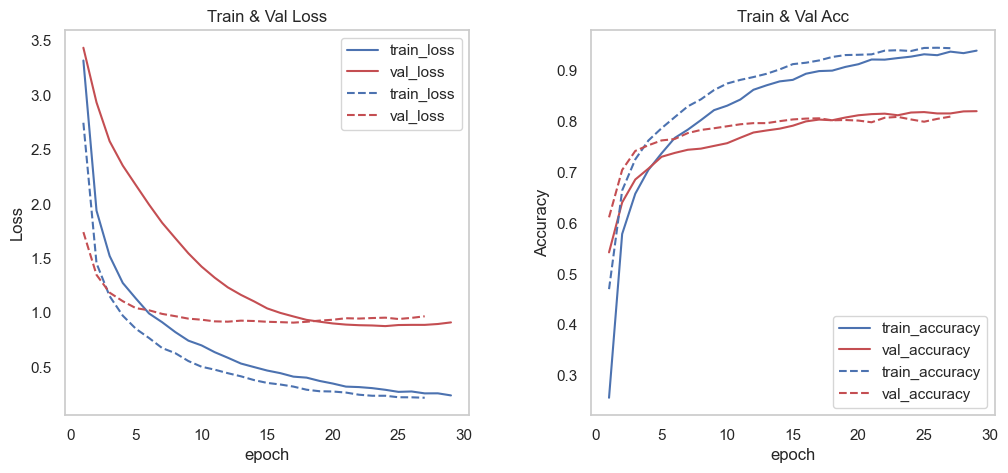

In [53]:
diff_history(history, history8) # bset 모델과 비교

71/71 [==============================] - 0s 3ms/step - loss: 1.2885 - accuracy: 0.6857


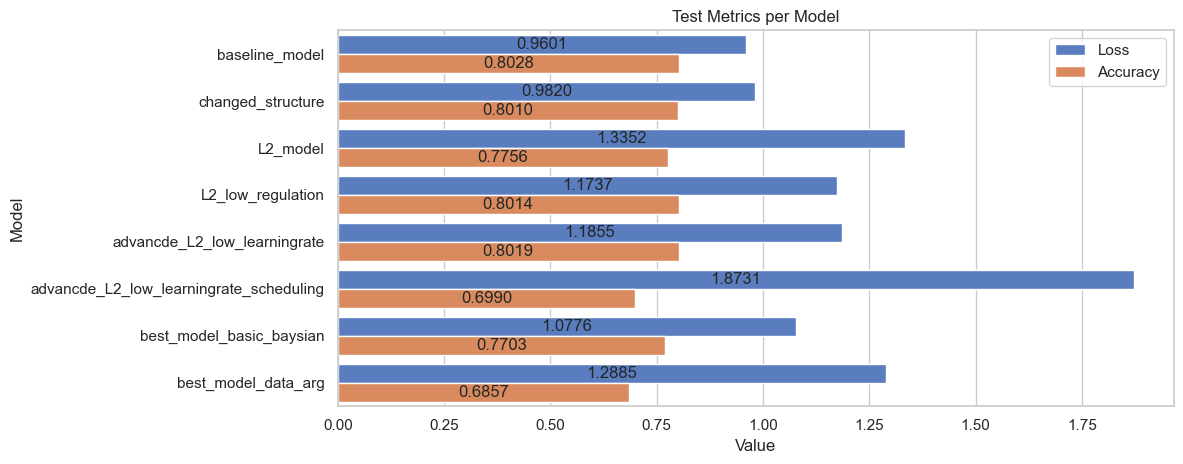

테스트 손실: 1.2885
테스트 정확도: 0.6857


In [54]:
# 저장된 최상의 모델을 불러옴
best_model = load_model('best_model_data_arg.h5')

# 불러온 모델로 테스트 데이터셋 평가
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)

# 모델 결과 저장
test_results = update_test_results('best_model_data_arg', test_loss, test_accuracy, test_results)

# 테스트 결과 비교
plot_test_results(test_results)

print(f'테스트 손실: {test_loss:.4f}')
print(f'테스트 정확도: {test_accuracy:.4f}')

- 증강된 데이터로 기존의 bset_model에 학습을 하는 경우에는 오히려 더 악화된 성능을 보여줍니다.
- 증강된 데이터자체의 품질이 좋지 못해 오히려 성능이 더 악화된 것 같습니다.
- 이제 두번재 방법으로 텍스트 데이터에 적합한 모델로 알려진 RNN과 LSTM을 사용해 학습을 진행해보겠습니다.

### RNN모델

- 기존에는 단순 신경망 형태의 모델을 사용했기 때문에 각 입력 노드가 독립적으로 작동하는 구조였고, 각 단어를 독립적인 입력으로 처리하기 위해 원핫인코딩을 사용했습니다.
- RNN이나 LSTM 모델을 사용하기 위해서는 데이터의 전처리 방식을 변경해야 합니다.
- 이 두 모델은 시퀀스 데이터를 처리하는데 특화된 모델입니다. 그렇기에 데이터의 순서 정보를 유지하기 위해 단어를 정수 인덱스로 변경하고 패딩을 통해 모든 데이터의 길이를 동일하게 맞춰줘야 합니다.
- 이 전처리를 통해 문장 내에서 단어의 순서와 문맥을 모델이 학습할 수 있게 됩니다.
---

[참고자료]


- [tf.keras.utils.pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences)
-  [Sequence Classification with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/)
- [10-03 로이터 뉴스 분류하기(Reuters News Classification)](https://wikidocs.net/22933)
- [RNN(Recurrent Neural Network) - 순환신경망](https://ohs-o.tistory.com/85)
- [[DL]one hot encoding (원 핫 인코딩 이 무엇인 지 알아보자](https://gr-st-dev.tistory.com/409)

#### 데이터 불러오기 및 전처리

- EDA단계에서 확인했듯이 로이터 데이터셋의 평균 기사수는 150~200이고 최대 길이는 2000자가 넘습니다.
- 따라서 일단은 평균치인 150으로 학습을 시켜보고 차후 변경이 필요한 경우 변경시도를 해보겠습니다.
- 모델 구조는 기존 모델에서 성능이 가장 잘 나왔던 L2_low_regulation 구조를 기반으로 SimpleRNN으로 변경하여 적용해보겠습니다.

In [55]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000 # 등장빈도 상위 10000개 데이터 사용
max_len = 150

# Reuters 데이터를 로드
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=vocab_size, test_split=0.2)

# 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#### 모델 구성 및 컴파일
- 가장 성능이 좋았던 모델 구성(배치정규화, 드롭아웃 등)을 참고하되 SimpleRNN으로 변경합니다.

In [56]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 모델 파라미터 설정
embedding_dim = 128
hidden_units = 128
num_classes = 46

# L2 규제 강도
l2_reg = l2(0.001)

# 모델 생성
model = Sequential()

# Embedding 레이어
model.add(Embedding(10000, embedding_dim, input_length=150))

# Simple RNN 레이어
model.add(SimpleRNN(hidden_units, kernel_regularizer=l2_reg))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Dropout 비율은 조정 가능

# Dense 레이어
model.add(Dense(hidden_units, kernel_regularizer=l2_reg))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Dropout 비율은 조정 가능

# 출력 레이어
model.add(Dense(num_classes, activation='softmax'))  # 46개 클래스 분류를 위한 softmax 활성화 함수

# 모델 요약 출력
model.summary()


# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 128)          1280000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               32896     
_________________________________________________________________
batch_normalization_198 (Bat (None, 128)               512       
_________________________________________________________________
dropout_197 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_297 (Dense)            (None, 128)               16512     
_________________________________________________________________
batch_normalization_199 (Bat (None, 128)               512       
_________________________________________________________________
activation_198 (Activation)  (None, 128)             

#### 모델 학습

In [57]:
# ModelCheckpoint 설정
model_checkpoint = ModelCheckpoint(
    filepath='basic_model_RNN.h5',  # 모델을 저장할 파일 경로
    save_best_only=True,  # 가장 좋은 모델만 저장
    monitor='val_loss',  # 검증 손실을 기준으로 최적의 모델을 판단
    verbose=1  # 로그를 출력
)

# EarlyStopping 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준으로 조기 종료를 판단
    patience=10,  # 성능 향상이 없는 epoch를 얼마나 기다릴 것인지
    verbose=1  # 로그를 출력
)

# 모델 학습
history9 = model.fit(
    X_train,  # 훈련 데이터
    y_train,  # 훈련 데이터 레이블
    epochs=100,  # 최대 epoch 수
    batch_size=512,  # 배치 크기
    validation_data=(X_test, y_test),  # 검증 데이터
    callbacks=[model_checkpoint, early_stopping],  # 콜백 함수 리스트
    verbose=2  # epoch마다 진행 상황을 어떻게 출력할지 결정
)

Epoch 1/100
18/18 - 2s - loss: 4.0919 - accuracy: 0.1106 - val_loss: 3.5585 - val_accuracy: 0.3620

Epoch 00001: val_loss improved from inf to 3.55847, saving model to basic_model_RNN.h5
Epoch 2/100
18/18 - 2s - loss: 2.9077 - accuracy: 0.3734 - val_loss: 3.1751 - val_accuracy: 0.4858

Epoch 00002: val_loss improved from 3.55847 to 3.17511, saving model to basic_model_RNN.h5
Epoch 3/100
18/18 - 2s - loss: 2.4196 - accuracy: 0.4842 - val_loss: 2.8102 - val_accuracy: 0.4746

Epoch 00003: val_loss improved from 3.17511 to 2.81022, saving model to basic_model_RNN.h5
Epoch 4/100
18/18 - 2s - loss: 2.1391 - accuracy: 0.5330 - val_loss: 2.7777 - val_accuracy: 0.4942

Epoch 00004: val_loss improved from 2.81022 to 2.77768, saving model to basic_model_RNN.h5
Epoch 5/100
18/18 - 2s - loss: 1.9330 - accuracy: 0.5717 - val_loss: 2.8476 - val_accuracy: 0.5102

Epoch 00005: val_loss did not improve from 2.77768
Epoch 6/100
18/18 - 2s - loss: 1.7834 - accuracy: 0.6043 - val_loss: 2.8221 - val_accurac

#### 학습 결과 확인

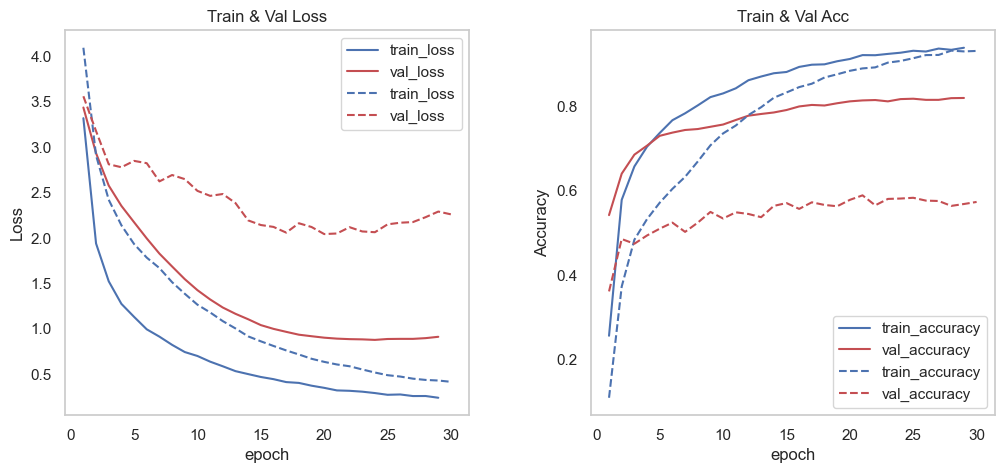

In [58]:
diff_history(history, history9) # bset 모델과 비교

71/71 [==============================] - 1s 12ms/step - loss: 2.0426 - accuracy: 0.5784


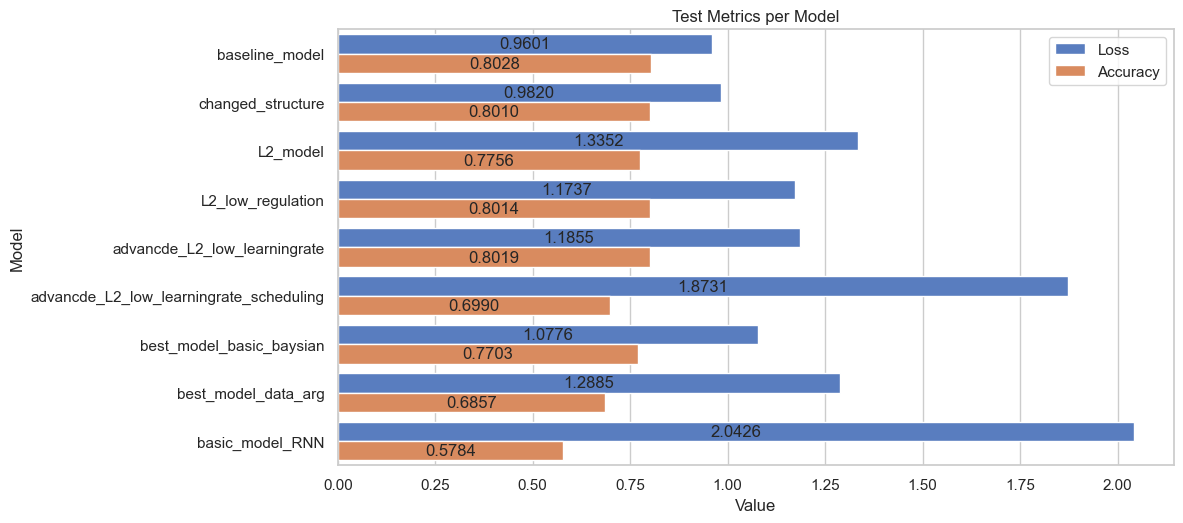

테스트 손실: 2.0426
테스트 정확도: 0.5784


In [59]:
# 모델 불러오기
loaded_model = load_model('basic_model_RNN.h5')

# 테스트 데이터에 대한 손실과 정확도 계산
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test)

# 모델 결과 저장
test_results = update_test_results('basic_model_RNN', test_loss, test_accuracy, test_results)

# 테스트 결과 비교
plot_test_results(test_results)

print(f'테스트 손실: {test_loss:.4f}')
print(f'테스트 정확도: {test_accuracy:.4f}')

- 텍스트 데이터의 특성상 RNN모델이 더 좋은 성능을 보일 것이라 예상했는데, 너무 예상외의 결과를 보여줍니다.
- 위키북스에 나온 [로이터 뉴스 분류하기(Reuters News Classification)](https://wikidocs.net/22933) 를 참고해서 재시도를 해보겠습니다.

### RNN 모델 구조 개편

- 해당 문서에서는 LSTM으로 모델을 구성했으나, 데이터 전처리시에 vocab_size를 1000으로해서 상위 빈출 단어 1000개의 단어로 문장을 표현하도록하고, 문장 길이도 100으로 조정했습니다.
- 이를 RNN모델에 적용해서 재시도를 해보겠습니다.

#### 데이터 불러오기 및 전처리

In [60]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 1000 # 등장빈도 상위 1000개 단어만 사용
max_len = 100 # 문장 최대길이를 100으로 설정

# Reuters 데이터를 로드
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=vocab_size, test_split=0.2)

# 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#### 모델 구성 및 컴파일

In [61]:
# 모델 파라미터 설정
embedding_dim = 128
hidden_units = 128
num_classes = 46

# L2 규제 강도
l2_reg = l2(0.001)

# 모델 생성
model = Sequential()

# Embedding 레이어
# 단어수의 개수에 맞게 embedding을 1000으로하고 패딩한 max_len만큼 input_length를 설정
model.add(Embedding(1000, embedding_dim, input_length=100))

# Simple RNN 레이어
model.add(SimpleRNN(hidden_units, kernel_regularizer=l2_reg))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Dropout 비율은 조정 가능

# Dense 레이어
model.add(Dense(hidden_units, kernel_regularizer=l2_reg))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Dropout 비율은 조정 가능

# 출력 레이어
model.add(Dense(num_classes, activation='softmax'))  # 46개 클래스 분류를 위한 softmax 활성화 함수

# 모델 요약 출력
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          128000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
batch_normalization_200 (Bat (None, 128)               512       
_________________________________________________________________
dropout_199 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_299 (Dense)            (None, 128)               16512     
_________________________________________________________________
batch_normalization_201 (Bat (None, 128)               512       
_________________________________________________________________
activation_199 (Activation)  (None, 128)            

In [62]:
# ModelCheckpoint 설정
model_checkpoint = ModelCheckpoint(
    filepath='basic_model_RNN_2nd.h5',  # 모델을 저장할 파일 경로
    save_best_only=True,  # 가장 좋은 모델만 저장
    monitor='val_loss',  # 검증 손실을 기준으로 최적의 모델을 판단
    verbose=1  # 로그를 출력
)

# EarlyStopping 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준으로 조기 종료를 판단
    patience=4,  # 성능 향상이 없는 epoch를 얼마나 기다릴 것인지
    verbose=1  # 로그를 출력
)

# 모델 학습
history10 = model.fit(
    X_train,  # 훈련 데이터
    y_train,  # 훈련 데이터 레이블
    epochs=100,  # 최대 epoch 수
    batch_size=512,  # 배치 크기
    validation_data=(X_test, y_test),  # 검증 데이터
    callbacks=[model_checkpoint, early_stopping],  # 콜백 함수 리스트
    verbose=2  # epoch마다 진행 상황을 어떻게 출력할지 결정
)

Epoch 1/100
18/18 - 2s - loss: 3.8324 - accuracy: 0.1649 - val_loss: 3.4038 - val_accuracy: 0.4003

Epoch 00001: val_loss improved from inf to 3.40376, saving model to basic_model_RNN_2nd.h5
Epoch 2/100
18/18 - 1s - loss: 2.8198 - accuracy: 0.4012 - val_loss: 3.1351 - val_accuracy: 0.4199

Epoch 00002: val_loss improved from 3.40376 to 3.13513, saving model to basic_model_RNN_2nd.h5
Epoch 3/100
18/18 - 1s - loss: 2.5499 - accuracy: 0.4649 - val_loss: 2.9006 - val_accuracy: 0.4822

Epoch 00003: val_loss improved from 3.13513 to 2.90059, saving model to basic_model_RNN_2nd.h5
Epoch 4/100
18/18 - 1s - loss: 2.4021 - accuracy: 0.4756 - val_loss: 2.7244 - val_accuracy: 0.5013

Epoch 00004: val_loss improved from 2.90059 to 2.72438, saving model to basic_model_RNN_2nd.h5
Epoch 5/100
18/18 - 1s - loss: 2.2978 - accuracy: 0.4953 - val_loss: 2.6753 - val_accuracy: 0.5321

Epoch 00005: val_loss improved from 2.72438 to 2.67533, saving model to basic_model_RNN_2nd.h5
Epoch 6/100
18/18 - 1s - loss

#### 학습 결과 확인

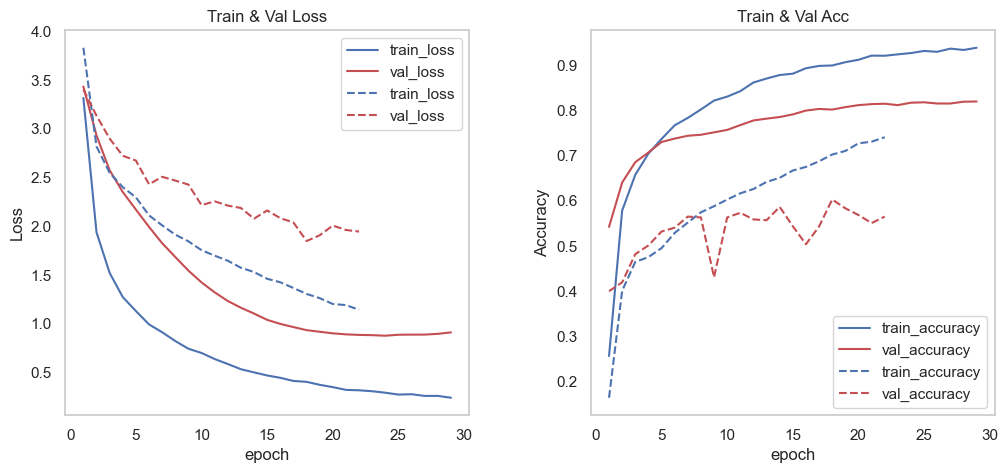

In [63]:
diff_history(history, history10) # bset 모델과 비교

71/71 [==============================] - 1s 8ms/step - loss: 1.8495 - accuracy: 0.6028


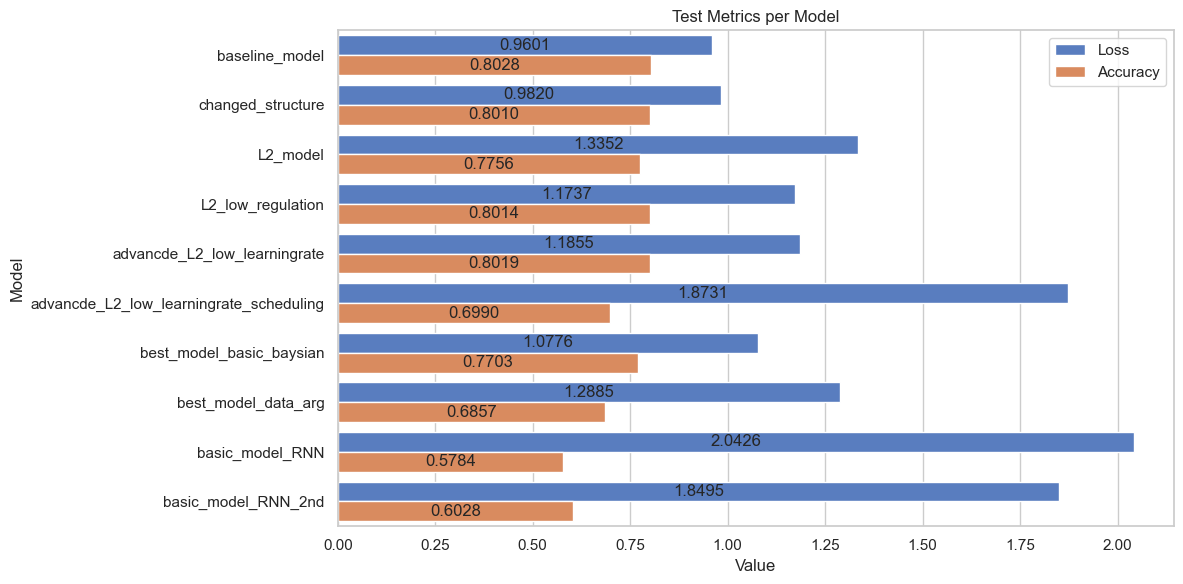

테스트 손실: 1.8495
테스트 정확도: 0.6028


In [64]:
# 모델 불러오기
loaded_model = load_model('basic_model_RNN_2nd.h5')

# 테스트 데이터에 대한 손실과 정확도 계산
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test)

# 모델 결과 저장
test_results = update_test_results('basic_model_RNN_2nd', test_loss, test_accuracy, test_results)

# 테스트 결과 비교
plot_test_results(test_results)

print(f'테스트 손실: {test_loss:.4f}')
print(f'테스트 정확도: {test_accuracy:.4f}')

- 모델에 학습되는 단어의 수를 줄이고, 문장의 길이도 100으로 패딩해 짧은 길이 내에서 단어의 특성을 최대한 학습하는 것을 목표로 하였는데, 어느정도는 성공한 것 같지만, 기본적으로 모델이 각 문장에서 단어 데이터의 특성을 잘 파악하지 못한 것 같습니다.
- 사용단어수를 늘리고, 문장 길이를 다시 늘려서 더 많은 문장을 학습할 수 있도록 조정해보겠습니다.
- 해당 시도의 결과가 좋다면 LSTM모델에도 같은 시퀀스 길이를 적용해보겠습니다.

### RNN 재시도(데이터 시퀀스 변경 ver)

#### 데이터 불러오기 및 전처리

In [65]:
vocab_size = 10000
max_len = 1000 # 문장의 길이를 100에서 1000으로 변경해 시퀀스 길이를 증가

# Reuters 데이터를 로드
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=vocab_size, test_split=0.2)

# 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#### 모델 구성 및 컴파일

In [66]:
embedding_dim = 128
hidden_units = 128
num_classes = 46  # Reuters 데이터셋의 클래스 수

model = Sequential()
model.add(Embedding(10000, embedding_dim, input_length=1000))
model.add(SimpleRNN(hidden_units, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(hidden_units, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 128)         1280000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 1000, 128)         32896     
_________________________________________________________________
dropout_201 (Dropout)        (None, 1000, 128)         0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1000, 128)         32896     
_________________________________________________________________
dropout_202 (Dropout)        (None, 1000, 128)         0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense_301 (Dense)            (None, 46)             

In [67]:
# ModelCheckpoint 설정
model_checkpoint = ModelCheckpoint(
    filepath='basic_model_RNN_3rd.h5',  # 모델을 저장할 파일 경로
    save_best_only=True,  # 가장 좋은 모델만 저장
    monitor='val_loss',  # 검증 손실을 기준으로 최적의 모델을 판단
    verbose=1  # 로그를 출력
)

# EarlyStopping 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준으로 조기 종료를 판단
    patience=10,  # 성능 향상이 없는 epoch를 얼마나 기다릴 것인지
    verbose=1  # 로그를 출력
)

# 모델 학습
history11 = model.fit(
    X_train,  # 훈련 데이터
    y_train,  # 훈련 데이터 레이블
    epochs=100,  # 최대 epoch 수
    batch_size=512,  # 배치 크기
    validation_data=(X_test, y_test),  # 검증 데이터
    callbacks=[model_checkpoint, early_stopping],  # 콜백 함수 리스트
    verbose=2  # epoch마다 진행 상황을 어떻게 출력할지 결정
)

Epoch 1/100
18/18 - 34s - loss: 2.9044 - accuracy: 0.2921 - val_loss: 2.2576 - val_accuracy: 0.4368

Epoch 00001: val_loss improved from inf to 2.25762, saving model to basic_model_RNN_3rd.h5
Epoch 2/100
18/18 - 33s - loss: 2.0412 - accuracy: 0.4861 - val_loss: 2.0534 - val_accuracy: 0.5009

Epoch 00002: val_loss improved from 2.25762 to 2.05338, saving model to basic_model_RNN_3rd.h5
Epoch 3/100
18/18 - 32s - loss: 1.6817 - accuracy: 0.5734 - val_loss: 2.0260 - val_accuracy: 0.5120

Epoch 00003: val_loss improved from 2.05338 to 2.02604, saving model to basic_model_RNN_3rd.h5
Epoch 4/100
18/18 - 33s - loss: 1.2158 - accuracy: 0.7032 - val_loss: 2.0920 - val_accuracy: 0.5027

Epoch 00004: val_loss did not improve from 2.02604
Epoch 5/100
18/18 - 33s - loss: 0.8099 - accuracy: 0.8116 - val_loss: 2.1186 - val_accuracy: 0.5254

Epoch 00005: val_loss did not improve from 2.02604
Epoch 6/100
18/18 - 33s - loss: 0.5414 - accuracy: 0.8795 - val_loss: 2.2502 - val_accuracy: 0.5089

Epoch 00006

#### 학습 결과 확인

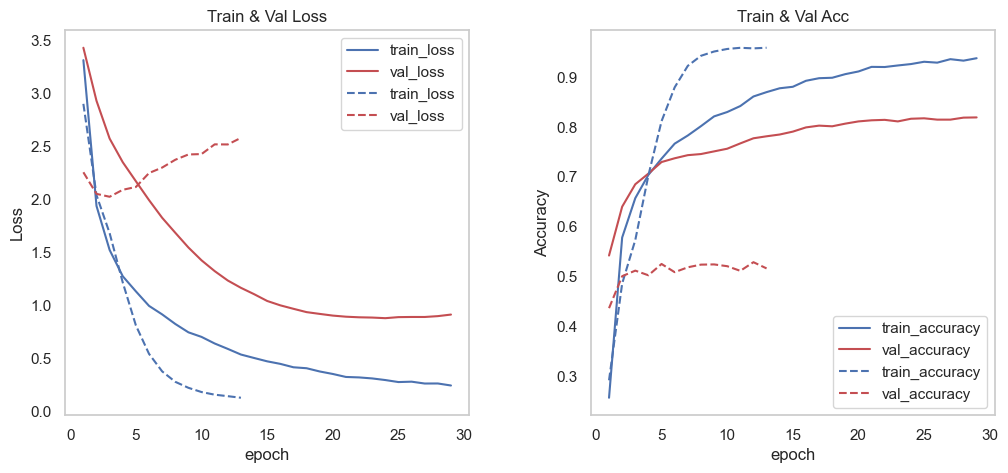

In [68]:
diff_history(history, history11) # bset 모델과 비교

71/71 [==============================] - 12s 169ms/step - loss: 2.0260 - accuracy: 0.5120


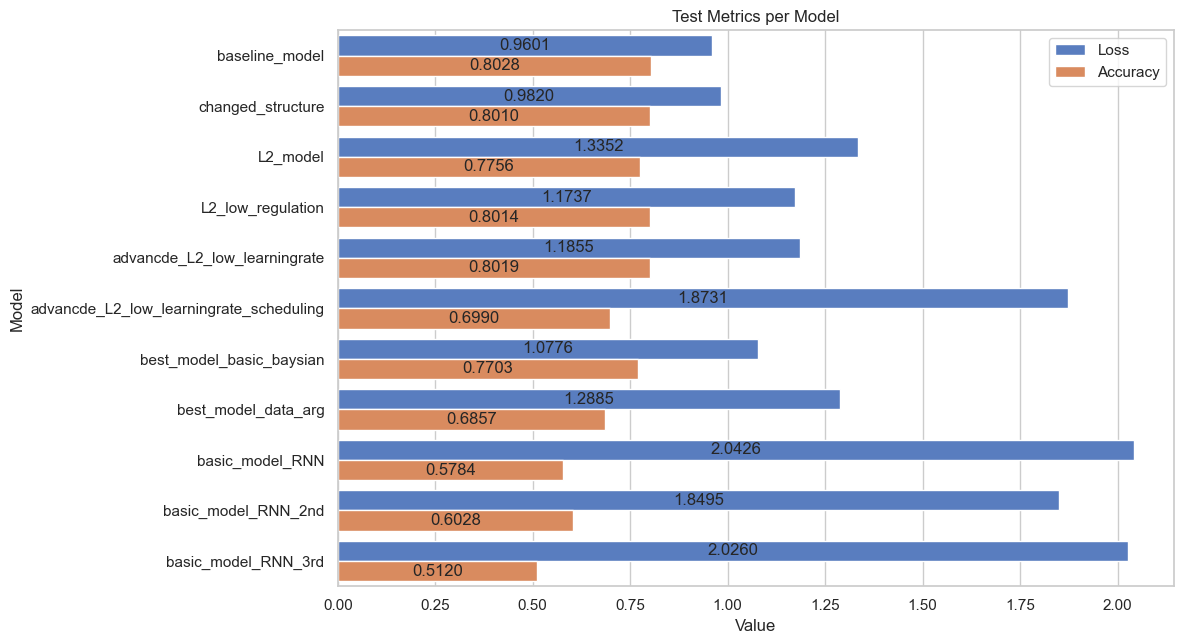

테스트 손실: 2.0260
테스트 정확도: 0.5120


In [69]:
# 모델 불러오기
loaded_model = load_model('basic_model_RNN_3rd.h5')

# 테스트 데이터에 대한 손실과 정확도 계산
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test)

# 모델 결과 저장
test_results = update_test_results('basic_model_RNN_3rd', test_loss, test_accuracy, test_results)

# 테스트 결과 비교
plot_test_results(test_results)

print(f'테스트 손실: {test_loss:.4f}')
print(f'테스트 정확도: {test_accuracy:.4f}')

- 문장의 길이를 늘려 더 많은 데이터에서 모델이 문장의 특성을 잡아내길 기대했는데 오히려 성능이 더욱 악화 되었습니다.
- 외려 문장의 길이가 길어지고 많은 단어들이 등장해서 모델이 제대로 학습을 하지 못한 것 같습니다.
- 동일한 단어수로 표현한 문장이지만, 길이가 더 짧았을때의 성능이 좋은 것을 보면 장기 의존성 문제로 인한 성능악화로 추정됩니다.
- 모델을 LSTM으로 변형하면서 문장의 길이를 줄여서 재시도를 해보면 좋을 것 같습니다.

### LSTM 모델 

- 이번에는 시퀀스 데이터에 대해 더 강건한 모델인 LSTM을 적용해보겠습니다.
- 데이터는 RNN모델에 적용한 데이터를 그대로 사용하겠습니다.

#### 데이터 불러오기 및 전처리

In [74]:
vocab_size = 1000
max_len = 100

(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=vocab_size, test_split=0.2)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#### 모델 구성 및 컴파일

In [75]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         128000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_303 (Dense)            (None, 46)                5934      
Total params: 265,518
Trainable params: 265,518
Non-trainable params: 0
_________________________________________________________________


#### 모델 학습

In [76]:
# ModelCheckpoint 설정
model_checkpoint = ModelCheckpoint(
    filepath='basic_model_LSTM.h5',  # 모델을 저장할 파일 경로
    save_best_only=True,  # 가장 좋은 모델만 저장
    monitor='val_loss',  # 검증 손실을 기준으로 최적의 모델을 판단
    verbose=1  # 로그를 출력
)

# EarlyStopping 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준으로 조기 종료를 판단
    patience=4,  # 성능 향상이 없는 epoch를 얼마나 기다릴 것인지
    verbose=1  # 로그를 출력
)

# 모델 학습
history12 = model.fit(
    X_train,  # 훈련 데이터
    y_train,  # 훈련 데이터 레이블
    epochs=100,  # 최대 epoch 수
    batch_size=512,  # 배치 크기
    validation_data=(X_test, y_test),  # 검증 데이터
    callbacks=[model_checkpoint, early_stopping],  # 콜백 함수 리스트
    verbose=2  # epoch마다 진행 상황을 어떻게 출력할지 결정
)

Epoch 1/100
18/18 - 2s - loss: 3.2352 - accuracy: 0.3314 - val_loss: 2.5369 - val_accuracy: 0.3620

Epoch 00001: val_loss improved from inf to 2.53691, saving model to basic_model_LSTM.h5
Epoch 2/100
18/18 - 0s - loss: 2.4569 - accuracy: 0.3116 - val_loss: 2.4244 - val_accuracy: 0.3620

Epoch 00002: val_loss improved from 2.53691 to 2.42438, saving model to basic_model_LSTM.h5
Epoch 3/100
18/18 - 0s - loss: 2.4008 - accuracy: 0.3517 - val_loss: 2.3994 - val_accuracy: 0.3620

Epoch 00003: val_loss improved from 2.42438 to 2.39939, saving model to basic_model_LSTM.h5
Epoch 4/100
18/18 - 0s - loss: 2.3721 - accuracy: 0.3517 - val_loss: 2.3353 - val_accuracy: 0.3620

Epoch 00004: val_loss improved from 2.39939 to 2.33533, saving model to basic_model_LSTM.h5
Epoch 5/100
18/18 - 0s - loss: 2.1566 - accuracy: 0.4063 - val_loss: 1.9983 - val_accuracy: 0.4564

Epoch 00005: val_loss improved from 2.33533 to 1.99828, saving model to basic_model_LSTM.h5
Epoch 6/100
18/18 - 0s - loss: 1.9280 - accu

#### 학습 결과 확인

71/71 [==============================] - 1s 6ms/step - loss: 1.2653 - accuracy: 0.6901


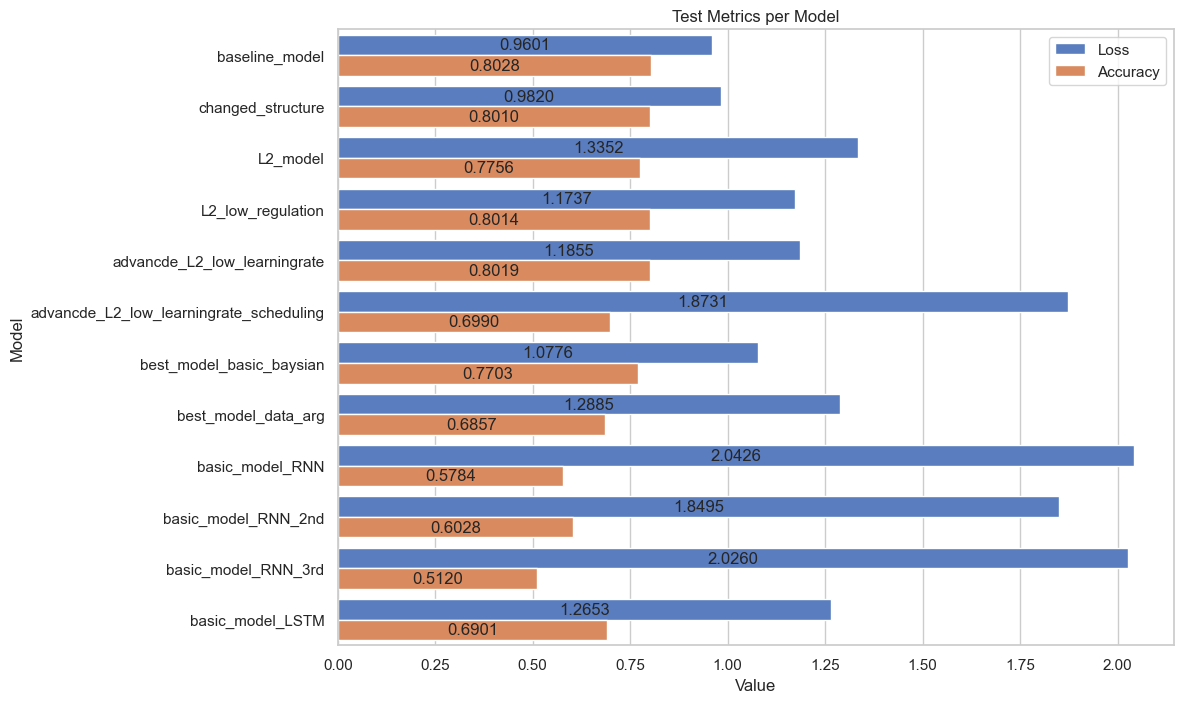

테스트 손실: 1.2653
테스트 정확도: 0.6901


In [77]:
# 모델 불러오기
loaded_model = load_model('basic_model_LSTM.h5')

# 테스트 데이터에 대한 손실과 정확도 계산
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test)

# 모델 결과 저장
test_results = update_test_results('basic_model_LSTM', test_loss, test_accuracy, test_results)

# 테스트 결과 비교
plot_test_results(test_results)

print(f'테스트 손실: {test_loss:.4f}')
print(f'테스트 정확도: {test_accuracy:.4f}')

- 장기 기억손실에 의한 문제는 어느정도 개선이 되는 듯하지만, MLP를 사용한 기본모델에 비해서는 성능이 현저히 낮습니다.
- 몇가지 최적화 방법을 시도해볼수도 있지만, RNN 모델을 기반으로 생각해볼때 베이직 모델을 뛰어넘는 성과를 내기는 힘들것 같습니다.
- 텍스트 데이터에 더 적합한 모델이라고 알려있지만, 현재의 테스크에는 적합하지 않은 모델이었던 것 같습니다.

# Closing

- 로이터 데이터셋을 분류하는 기본 신경망 구조를 베이스 모델로 하여 다양한 최적화 방법 및 과적방 방지 기법들을 시도해봤습니다.
- 기본적으로 베이스 모델의 성능이 78~80%정도로 우수하게 나온편이라 추가적인 조치들에서 드라마틱한 성능 변화를 찾아보기는 힘들었습니다.
- 가장 의외였던 것은 '텍스트 데이터에 특화된' RNN이나 LSTM의 모델이 외려 더 성능이 하락한다는 점이 었습니다.
- 파라미터나 과적합등의 조치이전에 기본 모델에서도 성능차이가 크게 난다는 점이 의외였습니다.
- 여러가지로 원인에 대해 고민을 해봤을때, 떠오르는 가장 합리적인 결론은 '데이터'와 '풀고자 하는 문제' 에 있었다고 생각합니다.

---

### 왜 RNN 이나 LSTM의 성능이 더 떨어졌을까?
- 전반적으로 주요 원인은 텍스트 데이터의 특성과 모델 구조의 차이인듯 합니다.

1. 시퀀스 길이 제한
- RNN이나 LSTM은 시퀀스 길이에 따라 성능이 달라질 수 있습니다. 베이스 모델과 동일한 조건 설정을 위해 시퀀스 길이를 100으로 설정하였을때, 성능이 떨어지는 것을 확인할 수 있었습니다.
- RNN이나 LSTM이 학습하기에는 중요한 정보가 포함되지 않았거나, 너무 길이가 짧아 충분한 맥락(context)를 학습하지 못했을 가능성이 있습니다.


2. 데이터 특성 및 모델 적합성
- 이번 테스크와 같은 뉴스 카테고리 분류의 경우, 단순한 키워드나 특정 문구의 존재 여부가 클래스 분류에 더 적합할 수 있습니다.
- 베이스 모델은 MLP로 구성되어있고, 상대적으로 짧은 시퀀스의 데이터에서 이러한 특성들을 학습해 더 좋은 성능이 나왔을 수 있습니다.
- 반면에 RNN이나 LSTM은 긴 시퀀스에서 오는 문맥적 이해에 더 초점이 맞춰진 모델이기 때문에 주어진 테스크에는 오히려 MLP모델이 더 적합할 수 있습니다.

- 이 과정을 겪으면서 선입견에 의한 모델 선택이 얼마나 테스크 달성에 문제가 되는지를 경험할 수 있었습니다.
- 질이 좋은 데이터의 확보도 중요하지만, 목적 달성을 위해 적합한 모델을 선택하는 것도 중요한 것을 깨닳았습니다.